In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
import os
import relative_accuracy as ra
from statistics import mean, stdev

In [3]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error

In [4]:
import keras_tuner as kt
from keras_tuner import RandomSearch

In [5]:
# Load all Inputs and Output Data

# 5 mins (1 step ahead)
Deep_train_5   = np.load("Deep_train_5.npz")['x'] 
Output_train_5 = np.load("Deep_train_5.npz")['y']

Deep_test_5   = np.load("Deep_test_5.npz")['x'] 
Output_test_5 = np.load("Deep_test_5.npz")['y'] 

# 15 mins (3 steps ahead)
Deep_train_15   = np.load("Deep_train_15.npz")['x'] 
Output_train_15 = np.load("Deep_train_15.npz")['y']

Deep_test_15   = np.load("Deep_test_15.npz")['x'] 
Output_test_15 = np.load("Deep_test_15.npz")['y']

# 30 mins (6 steps ahead)
Deep_train_30   = np.load("Deep_train_30.npz")['x'] 
Output_train_30 = np.load("Deep_train_30.npz")['y']

Deep_test_30   = np.load("Deep_test_30.npz")['x'] 
Output_test_30 = np.load("Deep_test_30.npz")['y']

# 60 mins (12 steps ahead)
Deep_train_60   = np.load("Deep_train_60.npz")['x'] 
Output_train_60 = np.load("Deep_train_60.npz")['y']

Deep_test_60   = np.load("Deep_test_60.npz")['x'] 
Output_test_60 = np.load("Deep_test_60.npz")['y']

In [6]:
scaler_filename = "scaler.save"
scaler = joblib.load(scaler_filename) 

C:\Users\esugom\.conda\envs\my_env\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [7]:
Test      = pd.read_csv('01test_scaled.csv', index_col=0, parse_dates=[8])

## Input

#### 5 mins

In [8]:
# Train
Xt5 = Deep_train_5
yt5 = Output_train_5
# Test
Xv5 = Deep_test_5
yv5 = Output_test_5

#### 15 mins

In [9]:
# Train
Xt15 = Deep_train_15
yt15 = Output_train_15
# Test
Xv15 = Deep_test_15
yv15 = Output_test_15

#### 30 mins

In [10]:
# Train
Xt30 = Deep_train_30
yt30 = Output_train_30
# Test
Xv30 = Deep_test_30
yv30 = Output_test_30

#### 60 mins

In [11]:
# Train
Xt60 = Deep_train_60
yt60 = Output_train_60
# Test
Xv60 = Deep_test_60
yv60 = Output_test_60

# LSTM Model

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [13]:
# We're using 7 features in our time series samples (7 spatial locations)
n_features = 7
length = 15
val_percent = 0.12962        # 2 weeks
batch_size = 32

In [14]:
input_shape = (length, n_features)

In [15]:
from tensorflow import keras

# Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [16]:
stop = keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    patience = 5,
    restore_best_weights = True)

# 5 mins ahead

In [17]:
def build_model_5(hp):
    # define model
    model_5 = Sequential()
    
    # Simple LSTM layer
    model_5.add(LSTM(units=hp.Int("Units_1", min_value=1, max_value=100, step=1),
                     activation='relu', return_sequences=True, input_shape=input_shape))
    model_5.add(LSTM(units=hp.Int("Units_2", min_value=1, max_value=100, step=1),
                     activation='relu'))
    
    # Final Prediction
    model_5.add(Dense(1))
    
    model_5.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss='mse',metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
    
    return model_5

In [18]:
tuner5 = RandomSearch(
    build_model_5,
    objective="val_loss",
    max_trials=60,
    executions_per_trial=5,
    overwrite=False,
    directory=os.path.normpath('C:/Runs'),
    project_name="6a-LSTM-5"
)

INFO:tensorflow:Reloading Oracle from existing project C:\Runs\6a-LSTM-5\oracle.json
INFO:tensorflow:Reloading Tuner from C:\Runs\6a-LSTM-5\tuner0.json


In [19]:
tuner5.search_space_summary()

Search space summary
Default search space size: 3
Units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
Units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [20]:
tuner5.search(Xt5, yt5, epochs=200,
           validation_split = val_percent,
           callbacks = [early_stop],
           verbose=2)

INFO:tensorflow:Oracle triggered exit


In [21]:
tuner5.results_summary(1)

Results summary
Results in C:\Runs\6a-LSTM-5
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
Units_1: 46
Units_2: 70
learning_rate: 0.001
Score: 0.001551397773437202


### Best Model

In [22]:
best_hp5 = tuner5.get_best_hyperparameters()[0]
model5 = tuner5.hypermodel.build(best_hp5)

In [23]:
scaler_filename = "Best_HP/6a-LSTM-5"
joblib.dump(best_hp5, scaler_filename) 

['Best_HP/6a-LSTM-5']

In [24]:
model5.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 46)            9936      
_________________________________________________________________
lstm_1 (LSTM)                (None, 70)                32760     
_________________________________________________________________
dense (Dense)                (None, 1)                 71        
Total params: 42,767
Trainable params: 42,767
Non-trainable params: 0
_________________________________________________________________


In [25]:
#model5.fit(Xt5, yt5, 
#           epochs = 100, 
#           verbose = 0)

In [26]:
#metrics5 = pd.DataFrame(model5.history.history)

In [27]:
#metrics5[['loss']].plot()

In [28]:
MSE5  = []
MAE5  = []
RMSE5 = []
MAPE5 = []

for i in range(100):
    print(f"run: {i+1}")
    model5.fit((Xt5), yt5, 
           epochs = 200, validation_split = val_percent,
           callbacks = [stop],
           verbose = 1)

    test_predictions5 = model5.predict((Xv5))

    yv5 = scaler.inverse_transform(Test.drop('Timestamp', axis = 1))
    yv5 = yv5[15:,4]

    df = Test.drop(Test.head(15).index)
    df.reset_index(inplace = True)
    df = df.drop(columns=['index','Timestamp'])
    df['f5'] = pd.Series(test_predictions5.flatten())

    test_predictions5 = scaler.inverse_transform(df)

    test_predictions5 = test_predictions5[:,4]

    MSE5.append(mean_squared_error(yv5,test_predictions5))

    MAE5.append(mean_absolute_error(yv5,test_predictions5))

    RMSE5.append(np.sqrt(mean_squared_error(yv5,test_predictions5)))

    MAPE5.append(mean_absolute_percentage_error(yv5,test_predictions5)*100)

    
    current_mse = mean_squared_error(yv5,test_predictions5)
    if all(i > current_mse for i in MSE5):
        model5.save("my_dir/6a-LSTM-5")

eval5 = [mean(MSE5), mean(MAE5), mean(RMSE5), mean(MAPE5)]
std5 = [stdev(MSE5), stdev(MAE5), stdev(RMSE5), stdev(MAPE5)]
print(eval5)

run: 1
Epoch 1/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0042 - mean_absolute_error: 0.0445 - root_mean_squared_error: 0.0650 - mean_absolute_percentage_error: 4273.1914 - val_loss: 0.0028 - val_mean_absolute_error: 0.0404 - val_root_mean_squared_error: 0.0525 - val_mean_absolute_percentage_error: 13.0429
Epoch 2/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0023 - mean_absolute_error: 0.0357 - root_mean_squared_error: 0.0479 - mean_absolute_percentage_error: 3275.6448 - val_loss: 0.0019 - val_mean_absolute_error: 0.0339 - val_root_mean_squared_error: 0.0441 - val_mean_absolute_percentage_error: 10.2711
Epoch 3/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0020 - mean_absolute_error: 0.0338 - root_mean_squared_error: 0.0452 - mean_absolute_percentage_error: 2991.7566 - val_loss: 0.0021 - val_mean_absolute_error: 0.0350 - val_root_mean_squared_error: 0.0455 - val_mean_absolute_percentage_error: 10.6872
Epoch 

Epoch 3/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0017 - mean_absolute_error: 0.0309 - root_mean_squared_error: 0.0414 - mean_absolute_percentage_error: 3253.6221 - val_loss: 0.0016 - val_mean_absolute_error: 0.0306 - val_root_mean_squared_error: 0.0399 - val_mean_absolute_percentage_error: 9.1016
Epoch 4/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0017 - mean_absolute_error: 0.0308 - root_mean_squared_error: 0.0413 - mean_absolute_percentage_error: 3408.8259 - val_loss: 0.0018 - val_mean_absolute_error: 0.0325 - val_root_mean_squared_error: 0.0422 - val_mean_absolute_percentage_error: 9.9368
Epoch 5/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0017 - mean_absolute_error: 0.0307 - root_mean_squared_error: 0.0411 - mean_absolute_percentage_error: 3597.1040 - val_loss: 0.0016 - val_mean_absolute_error: 0.0302 - val_root_mean_squared_error: 0.0394 - val_mean_absolute_percentage_error: 9.0054
Epoch 6/200
846/

Epoch 5/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0016 - mean_absolute_error: 0.0303 - root_mean_squared_error: 0.0405 - mean_absolute_percentage_error: 3078.0029 - val_loss: 0.0018 - val_mean_absolute_error: 0.0328 - val_root_mean_squared_error: 0.0429 - val_mean_absolute_percentage_error: 9.3232
Epoch 6/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0016 - mean_absolute_error: 0.0304 - root_mean_squared_error: 0.0406 - mean_absolute_percentage_error: 3507.7634 - val_loss: 0.0015 - val_mean_absolute_error: 0.0302 - val_root_mean_squared_error: 0.0392 - val_mean_absolute_percentage_error: 9.1143
Epoch 7/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0016 - mean_absolute_error: 0.0303 - root_mean_squared_error: 0.0404 - mean_absolute_percentage_error: 3382.5984 - val_loss: 0.0016 - val_mean_absolute_error: 0.0303 - val_root_mean_squared_error: 0.0396 - val_mean_absolute_percentage_error: 9.1170
Epoch 8/200
846/

run: 7
Epoch 1/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0016 - mean_absolute_error: 0.0301 - root_mean_squared_error: 0.0402 - mean_absolute_percentage_error: 3669.4719 - val_loss: 0.0016 - val_mean_absolute_error: 0.0305 - val_root_mean_squared_error: 0.0396 - val_mean_absolute_percentage_error: 9.3236
Epoch 2/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0016 - mean_absolute_error: 0.0300 - root_mean_squared_error: 0.0401 - mean_absolute_percentage_error: 3209.2637 - val_loss: 0.0016 - val_mean_absolute_error: 0.0305 - val_root_mean_squared_error: 0.0398 - val_mean_absolute_percentage_error: 9.1593
Epoch 3/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0016 - mean_absolute_error: 0.0299 - root_mean_squared_error: 0.0399 - mean_absolute_percentage_error: 3461.7483 - val_loss: 0.0016 - val_mean_absolute_error: 0.0304 - val_root_mean_squared_error: 0.0397 - val_mean_absolute_percentage_error: 9.0128
Epoch 4/2

Epoch 2/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0016 - mean_absolute_error: 0.0298 - root_mean_squared_error: 0.0398 - mean_absolute_percentage_error: 2858.1638 - val_loss: 0.0015 - val_mean_absolute_error: 0.0300 - val_root_mean_squared_error: 0.0391 - val_mean_absolute_percentage_error: 9.1670
Epoch 3/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0016 - mean_absolute_error: 0.0298 - root_mean_squared_error: 0.0398 - mean_absolute_percentage_error: 2336.6343 - val_loss: 0.0016 - val_mean_absolute_error: 0.0303 - val_root_mean_squared_error: 0.0395 - val_mean_absolute_percentage_error: 9.2212
Epoch 4/200
846/846 [==============================] - 11s 12ms/step - loss: 0.0016 - mean_absolute_error: 0.0298 - root_mean_squared_error: 0.0398 - mean_absolute_percentage_error: 2917.4380 - val_loss: 0.0016 - val_mean_absolute_error: 0.0304 - val_root_mean_squared_error: 0.0398 - val_mean_absolute_percentage_error: 9.1630
Epoch 5/200
846/

Epoch 6/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0016 - mean_absolute_error: 0.0298 - root_mean_squared_error: 0.0397 - mean_absolute_percentage_error: 3083.2625 - val_loss: 0.0015 - val_mean_absolute_error: 0.0300 - val_root_mean_squared_error: 0.0391 - val_mean_absolute_percentage_error: 9.1490
Epoch 7/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0016 - mean_absolute_error: 0.0296 - root_mean_squared_error: 0.0396 - mean_absolute_percentage_error: 3339.5449 - val_loss: 0.0015 - val_mean_absolute_error: 0.0300 - val_root_mean_squared_error: 0.0392 - val_mean_absolute_percentage_error: 9.0972
Epoch 8/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0016 - mean_absolute_error: 0.0297 - root_mean_squared_error: 0.0396 - mean_absolute_percentage_error: 2785.8245 - val_loss: 0.0016 - val_mean_absolute_error: 0.0303 - val_root_mean_squared_error: 0.0396 - val_mean_absolute_percentage_error: 8.9525
Epoch 9/200
846/

Epoch 11/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0016 - mean_absolute_error: 0.0296 - root_mean_squared_error: 0.0394 - mean_absolute_percentage_error: 2860.6523 - val_loss: 0.0015 - val_mean_absolute_error: 0.0297 - val_root_mean_squared_error: 0.0389 - val_mean_absolute_percentage_error: 8.8657
Epoch 12/200
846/846 [==============================] - 11s 12ms/step - loss: 0.0015 - mean_absolute_error: 0.0294 - root_mean_squared_error: 0.0391 - mean_absolute_percentage_error: 2742.8164 - val_loss: 0.0016 - val_mean_absolute_error: 0.0307 - val_root_mean_squared_error: 0.0398 - val_mean_absolute_percentage_error: 9.3591
Epoch 13/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0015 - mean_absolute_error: 0.0294 - root_mean_squared_error: 0.0392 - mean_absolute_percentage_error: 2918.9966 - val_loss: 0.0016 - val_mean_absolute_error: 0.0304 - val_root_mean_squared_error: 0.0397 - val_mean_absolute_percentage_error: 9.1454
Epoch 14/200


run: 18
Epoch 1/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0015 - mean_absolute_error: 0.0293 - root_mean_squared_error: 0.0390 - mean_absolute_percentage_error: 2558.7126 - val_loss: 0.0016 - val_mean_absolute_error: 0.0306 - val_root_mean_squared_error: 0.0401 - val_mean_absolute_percentage_error: 9.0730
Epoch 2/200
846/846 [==============================] - 11s 12ms/step - loss: 0.0015 - mean_absolute_error: 0.0293 - root_mean_squared_error: 0.0389 - mean_absolute_percentage_error: 2656.8743 - val_loss: 0.0016 - val_mean_absolute_error: 0.0304 - val_root_mean_squared_error: 0.0397 - val_mean_absolute_percentage_error: 9.1810
Epoch 3/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0015 - mean_absolute_error: 0.0293 - root_mean_squared_error: 0.0390 - mean_absolute_percentage_error: 2872.8269 - val_loss: 0.0015 - val_mean_absolute_error: 0.0299 - val_root_mean_squared_error: 0.0390 - val_mean_absolute_percentage_error: 8.9439
Epoch 4/

Epoch 3/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0015 - mean_absolute_error: 0.0291 - root_mean_squared_error: 0.0388 - mean_absolute_percentage_error: 2793.7305 - val_loss: 0.0015 - val_mean_absolute_error: 0.0300 - val_root_mean_squared_error: 0.0392 - val_mean_absolute_percentage_error: 8.9044
Epoch 4/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0015 - mean_absolute_error: 0.0291 - root_mean_squared_error: 0.0387 - mean_absolute_percentage_error: 2546.2632 - val_loss: 0.0015 - val_mean_absolute_error: 0.0301 - val_root_mean_squared_error: 0.0393 - val_mean_absolute_percentage_error: 8.9757
Epoch 5/200
846/846 [==============================] - 11s 12ms/step - loss: 0.0015 - mean_absolute_error: 0.0291 - root_mean_squared_error: 0.0386 - mean_absolute_percentage_error: 2346.0750 - val_loss: 0.0016 - val_mean_absolute_error: 0.0304 - val_root_mean_squared_error: 0.0397 - val_mean_absolute_percentage_error: 9.0214
Epoch 6/200
846/

Epoch 9/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0015 - mean_absolute_error: 0.0289 - root_mean_squared_error: 0.0384 - mean_absolute_percentage_error: 2816.5029 - val_loss: 0.0015 - val_mean_absolute_error: 0.0301 - val_root_mean_squared_error: 0.0393 - val_mean_absolute_percentage_error: 9.1065
Epoch 10/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0015 - mean_absolute_error: 0.0289 - root_mean_squared_error: 0.0384 - mean_absolute_percentage_error: 2488.0266 - val_loss: 0.0016 - val_mean_absolute_error: 0.0304 - val_root_mean_squared_error: 0.0396 - val_mean_absolute_percentage_error: 9.0568
Epoch 11/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0015 - mean_absolute_error: 0.0290 - root_mean_squared_error: 0.0384 - mean_absolute_percentage_error: 3059.0754 - val_loss: 0.0015 - val_mean_absolute_error: 0.0301 - val_root_mean_squared_error: 0.0393 - val_mean_absolute_percentage_error: 8.9184
run: 24
Epoch 

Epoch 3/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0015 - mean_absolute_error: 0.0289 - root_mean_squared_error: 0.0383 - mean_absolute_percentage_error: 2606.2742 - val_loss: 0.0017 - val_mean_absolute_error: 0.0317 - val_root_mean_squared_error: 0.0413 - val_mean_absolute_percentage_error: 9.7604
Epoch 4/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0015 - mean_absolute_error: 0.0289 - root_mean_squared_error: 0.0383 - mean_absolute_percentage_error: 2900.0864 - val_loss: 0.0016 - val_mean_absolute_error: 0.0301 - val_root_mean_squared_error: 0.0394 - val_mean_absolute_percentage_error: 8.9688
Epoch 5/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0015 - mean_absolute_error: 0.0288 - root_mean_squared_error: 0.0382 - mean_absolute_percentage_error: 2499.8396 - val_loss: 0.0016 - val_mean_absolute_error: 0.0303 - val_root_mean_squared_error: 0.0395 - val_mean_absolute_percentage_error: 9.0525
Epoch 6/200
846/

Epoch 4/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0015 - mean_absolute_error: 0.0288 - root_mean_squared_error: 0.0382 - mean_absolute_percentage_error: 2660.0759 - val_loss: 0.0015 - val_mean_absolute_error: 0.0298 - val_root_mean_squared_error: 0.0389 - val_mean_absolute_percentage_error: 8.9092
Epoch 5/200
846/846 [==============================] - 11s 12ms/step - loss: 0.0015 - mean_absolute_error: 0.0287 - root_mean_squared_error: 0.0381 - mean_absolute_percentage_error: 2824.1721 - val_loss: 0.0016 - val_mean_absolute_error: 0.0301 - val_root_mean_squared_error: 0.0394 - val_mean_absolute_percentage_error: 8.8995
Epoch 6/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0015 - mean_absolute_error: 0.0288 - root_mean_squared_error: 0.0381 - mean_absolute_percentage_error: 2510.9126 - val_loss: 0.0015 - val_mean_absolute_error: 0.0299 - val_root_mean_squared_error: 0.0391 - val_mean_absolute_percentage_error: 8.8948
Epoch 7/200
846/

Epoch 6/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0014 - mean_absolute_error: 0.0286 - root_mean_squared_error: 0.0380 - mean_absolute_percentage_error: 2710.8103 - val_loss: 0.0016 - val_mean_absolute_error: 0.0303 - val_root_mean_squared_error: 0.0395 - val_mean_absolute_percentage_error: 9.1958
Epoch 7/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0014 - mean_absolute_error: 0.0286 - root_mean_squared_error: 0.0378 - mean_absolute_percentage_error: 2336.5310 - val_loss: 0.0016 - val_mean_absolute_error: 0.0303 - val_root_mean_squared_error: 0.0395 - val_mean_absolute_percentage_error: 9.0856
Epoch 8/200
846/846 [==============================] - 11s 12ms/step - loss: 0.0014 - mean_absolute_error: 0.0285 - root_mean_squared_error: 0.0379 - mean_absolute_percentage_error: 2525.5408 - val_loss: 0.0016 - val_mean_absolute_error: 0.0308 - val_root_mean_squared_error: 0.0403 - val_mean_absolute_percentage_error: 9.1947
run: 33
Epoch 1/

Epoch 3/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0014 - mean_absolute_error: 0.0284 - root_mean_squared_error: 0.0377 - mean_absolute_percentage_error: 2098.1467 - val_loss: 0.0016 - val_mean_absolute_error: 0.0306 - val_root_mean_squared_error: 0.0400 - val_mean_absolute_percentage_error: 9.1667
Epoch 4/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0014 - mean_absolute_error: 0.0284 - root_mean_squared_error: 0.0377 - mean_absolute_percentage_error: 2534.6365 - val_loss: 0.0015 - val_mean_absolute_error: 0.0301 - val_root_mean_squared_error: 0.0392 - val_mean_absolute_percentage_error: 9.0624
Epoch 5/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0014 - mean_absolute_error: 0.0284 - root_mean_squared_error: 0.0377 - mean_absolute_percentage_error: 2454.0872 - val_loss: 0.0016 - val_mean_absolute_error: 0.0308 - val_root_mean_squared_error: 0.0400 - val_mean_absolute_percentage_error: 9.3449
Epoch 6/200
846/

Epoch 2/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0014 - mean_absolute_error: 0.0283 - root_mean_squared_error: 0.0375 - mean_absolute_percentage_error: 2243.3030 - val_loss: 0.0016 - val_mean_absolute_error: 0.0301 - val_root_mean_squared_error: 0.0394 - val_mean_absolute_percentage_error: 9.0540
Epoch 3/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0014 - mean_absolute_error: 0.0283 - root_mean_squared_error: 0.0375 - mean_absolute_percentage_error: 2482.7549 - val_loss: 0.0017 - val_mean_absolute_error: 0.0313 - val_root_mean_squared_error: 0.0407 - val_mean_absolute_percentage_error: 9.5869
Epoch 4/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0014 - mean_absolute_error: 0.0284 - root_mean_squared_error: 0.0376 - mean_absolute_percentage_error: 2156.0801 - val_loss: 0.0016 - val_mean_absolute_error: 0.0306 - val_root_mean_squared_error: 0.0402 - val_mean_absolute_percentage_error: 9.2450
Epoch 5/200
846/

Epoch 6/200
846/846 [==============================] - 10s 12ms/step - loss: 0.0014 - mean_absolute_error: 0.0281 - root_mean_squared_error: 0.0372 - mean_absolute_percentage_error: 2479.6565 - val_loss: 0.0016 - val_mean_absolute_error: 0.0303 - val_root_mean_squared_error: 0.0396 - val_mean_absolute_percentage_error: 9.0635
Epoch 7/200
846/846 [==============================] - 10s 12ms/step - loss: 0.0014 - mean_absolute_error: 0.0281 - root_mean_squared_error: 0.0372 - mean_absolute_percentage_error: 2776.8254 - val_loss: 0.0016 - val_mean_absolute_error: 0.0302 - val_root_mean_squared_error: 0.0396 - val_mean_absolute_percentage_error: 9.2444
Epoch 8/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0014 - mean_absolute_error: 0.0280 - root_mean_squared_error: 0.0371 - mean_absolute_percentage_error: 2512.6204 - val_loss: 0.0016 - val_mean_absolute_error: 0.0302 - val_root_mean_squared_error: 0.0395 - val_mean_absolute_percentage_error: 9.1110
Epoch 9/200
846/

run: 42
Epoch 1/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0014 - mean_absolute_error: 0.0279 - root_mean_squared_error: 0.0371 - mean_absolute_percentage_error: 2559.3523 - val_loss: 0.0016 - val_mean_absolute_error: 0.0305 - val_root_mean_squared_error: 0.0398 - val_mean_absolute_percentage_error: 9.2102
Epoch 2/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0014 - mean_absolute_error: 0.0280 - root_mean_squared_error: 0.0371 - mean_absolute_percentage_error: 2515.7031 - val_loss: 0.0016 - val_mean_absolute_error: 0.0308 - val_root_mean_squared_error: 0.0401 - val_mean_absolute_percentage_error: 9.5199
Epoch 3/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0014 - mean_absolute_error: 0.0280 - root_mean_squared_error: 0.0371 - mean_absolute_percentage_error: 2541.9192 - val_loss: 0.0016 - val_mean_absolute_error: 0.0302 - val_root_mean_squared_error: 0.0395 - val_mean_absolute_percentage_error: 9.1093
Epoch 4/

Epoch 4/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0014 - mean_absolute_error: 0.0278 - root_mean_squared_error: 0.0368 - mean_absolute_percentage_error: 2453.6265 - val_loss: 0.0017 - val_mean_absolute_error: 0.0316 - val_root_mean_squared_error: 0.0409 - val_mean_absolute_percentage_error: 10.3823
Epoch 5/200
846/846 [==============================] - 11s 12ms/step - loss: 0.0013 - mean_absolute_error: 0.0278 - root_mean_squared_error: 0.0367 - mean_absolute_percentage_error: 2376.3411 - val_loss: 0.0016 - val_mean_absolute_error: 0.0302 - val_root_mean_squared_error: 0.0396 - val_mean_absolute_percentage_error: 9.0092
Epoch 6/200
846/846 [==============================] - 11s 12ms/step - loss: 0.0013 - mean_absolute_error: 0.0278 - root_mean_squared_error: 0.0367 - mean_absolute_percentage_error: 2480.3267 - val_loss: 0.0016 - val_mean_absolute_error: 0.0302 - val_root_mean_squared_error: 0.0395 - val_mean_absolute_percentage_error: 8.9262
Epoch 7/200
846

Epoch 8/200
846/846 [==============================] - 11s 12ms/step - loss: 0.0013 - mean_absolute_error: 0.0276 - root_mean_squared_error: 0.0364 - mean_absolute_percentage_error: 2329.5823 - val_loss: 0.0016 - val_mean_absolute_error: 0.0306 - val_root_mean_squared_error: 0.0400 - val_mean_absolute_percentage_error: 8.9743
Epoch 9/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0013 - mean_absolute_error: 0.0276 - root_mean_squared_error: 0.0365 - mean_absolute_percentage_error: 1984.4615 - val_loss: 0.0016 - val_mean_absolute_error: 0.0304 - val_root_mean_squared_error: 0.0398 - val_mean_absolute_percentage_error: 9.0338
run: 47
Epoch 1/200
846/846 [==============================] - 11s 12ms/step - loss: 0.0013 - mean_absolute_error: 0.0277 - root_mean_squared_error: 0.0366 - mean_absolute_percentage_error: 2295.9404 - val_loss: 0.0017 - val_mean_absolute_error: 0.0311 - val_root_mean_squared_error: 0.0407 - val_mean_absolute_percentage_error: 9.6448
Epoch 2/

Epoch 6/200
846/846 [==============================] - 11s 12ms/step - loss: 0.0013 - mean_absolute_error: 0.0274 - root_mean_squared_error: 0.0361 - mean_absolute_percentage_error: 2391.9199 - val_loss: 0.0016 - val_mean_absolute_error: 0.0306 - val_root_mean_squared_error: 0.0400 - val_mean_absolute_percentage_error: 9.1459
Epoch 7/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0013 - mean_absolute_error: 0.0274 - root_mean_squared_error: 0.0362 - mean_absolute_percentage_error: 2392.3467 - val_loss: 0.0016 - val_mean_absolute_error: 0.0304 - val_root_mean_squared_error: 0.0398 - val_mean_absolute_percentage_error: 9.0411
Epoch 8/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0013 - mean_absolute_error: 0.0274 - root_mean_squared_error: 0.0362 - mean_absolute_percentage_error: 2008.7987 - val_loss: 0.0017 - val_mean_absolute_error: 0.0312 - val_root_mean_squared_error: 0.0408 - val_mean_absolute_percentage_error: 9.4629
Epoch 9/200
846/

Epoch 8/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0013 - mean_absolute_error: 0.0272 - root_mean_squared_error: 0.0360 - mean_absolute_percentage_error: 2206.4917 - val_loss: 0.0017 - val_mean_absolute_error: 0.0311 - val_root_mean_squared_error: 0.0408 - val_mean_absolute_percentage_error: 9.4181
Epoch 9/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0013 - mean_absolute_error: 0.0272 - root_mean_squared_error: 0.0359 - mean_absolute_percentage_error: 2073.0237 - val_loss: 0.0016 - val_mean_absolute_error: 0.0308 - val_root_mean_squared_error: 0.0402 - val_mean_absolute_percentage_error: 9.1665
Epoch 10/200
846/846 [==============================] - 11s 12ms/step - loss: 0.0013 - mean_absolute_error: 0.0271 - root_mean_squared_error: 0.0359 - mean_absolute_percentage_error: 2087.8286 - val_loss: 0.0016 - val_mean_absolute_error: 0.0304 - val_root_mean_squared_error: 0.0398 - val_mean_absolute_percentage_error: 9.1512
Epoch 11/200
84

Epoch 2/200
846/846 [==============================] - 11s 12ms/step - loss: 0.0013 - mean_absolute_error: 0.0271 - root_mean_squared_error: 0.0358 - mean_absolute_percentage_error: 2696.2451 - val_loss: 0.0016 - val_mean_absolute_error: 0.0308 - val_root_mean_squared_error: 0.0404 - val_mean_absolute_percentage_error: 9.3288
Epoch 3/200
846/846 [==============================] - 11s 12ms/step - loss: 0.0013 - mean_absolute_error: 0.0271 - root_mean_squared_error: 0.0358 - mean_absolute_percentage_error: 2317.9805 - val_loss: 0.0017 - val_mean_absolute_error: 0.0314 - val_root_mean_squared_error: 0.0412 - val_mean_absolute_percentage_error: 9.2691
Epoch 4/200
846/846 [==============================] - 10s 12ms/step - loss: 0.0013 - mean_absolute_error: 0.0270 - root_mean_squared_error: 0.0357 - mean_absolute_percentage_error: 2309.7888 - val_loss: 0.0016 - val_mean_absolute_error: 0.0311 - val_root_mean_squared_error: 0.0406 - val_mean_absolute_percentage_error: 9.3582
Epoch 5/200
846/

Epoch 5/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0013 - mean_absolute_error: 0.0270 - root_mean_squared_error: 0.0356 - mean_absolute_percentage_error: 2340.1384 - val_loss: 0.0017 - val_mean_absolute_error: 0.0316 - val_root_mean_squared_error: 0.0413 - val_mean_absolute_percentage_error: 9.5347
Epoch 6/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0013 - mean_absolute_error: 0.0269 - root_mean_squared_error: 0.0356 - mean_absolute_percentage_error: 2428.3423 - val_loss: 0.0016 - val_mean_absolute_error: 0.0306 - val_root_mean_squared_error: 0.0399 - val_mean_absolute_percentage_error: 9.0669
Epoch 7/200
846/846 [==============================] - 11s 12ms/step - loss: 0.0013 - mean_absolute_error: 0.0268 - root_mean_squared_error: 0.0355 - mean_absolute_percentage_error: 2065.5459 - val_loss: 0.0016 - val_mean_absolute_error: 0.0307 - val_root_mean_squared_error: 0.0402 - val_mean_absolute_percentage_error: 9.1713
Epoch 8/200
846/

Epoch 13/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0012 - mean_absolute_error: 0.0266 - root_mean_squared_error: 0.0352 - mean_absolute_percentage_error: 2177.6453 - val_loss: 0.0017 - val_mean_absolute_error: 0.0310 - val_root_mean_squared_error: 0.0407 - val_mean_absolute_percentage_error: 9.1391
Epoch 14/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0012 - mean_absolute_error: 0.0266 - root_mean_squared_error: 0.0352 - mean_absolute_percentage_error: 2180.3738 - val_loss: 0.0017 - val_mean_absolute_error: 0.0316 - val_root_mean_squared_error: 0.0412 - val_mean_absolute_percentage_error: 9.4186
run: 61
Epoch 1/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0012 - mean_absolute_error: 0.0268 - root_mean_squared_error: 0.0353 - mean_absolute_percentage_error: 2674.6008 - val_loss: 0.0017 - val_mean_absolute_error: 0.0317 - val_root_mean_squared_error: 0.0414 - val_mean_absolute_percentage_error: 9.3867
Epoch 

Epoch 5/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0012 - mean_absolute_error: 0.0266 - root_mean_squared_error: 0.0351 - mean_absolute_percentage_error: 1857.9667 - val_loss: 0.0018 - val_mean_absolute_error: 0.0321 - val_root_mean_squared_error: 0.0419 - val_mean_absolute_percentage_error: 9.9458
Epoch 6/200
846/846 [==============================] - 10s 12ms/step - loss: 0.0012 - mean_absolute_error: 0.0265 - root_mean_squared_error: 0.0350 - mean_absolute_percentage_error: 2237.0588 - val_loss: 0.0017 - val_mean_absolute_error: 0.0314 - val_root_mean_squared_error: 0.0411 - val_mean_absolute_percentage_error: 9.4135
run: 64
Epoch 1/200
846/846 [==============================] - 11s 12ms/step - loss: 0.0012 - mean_absolute_error: 0.0266 - root_mean_squared_error: 0.0351 - mean_absolute_percentage_error: 2355.4397 - val_loss: 0.0017 - val_mean_absolute_error: 0.0310 - val_root_mean_squared_error: 0.0407 - val_mean_absolute_percentage_error: 9.0170
Epoch 2/

Epoch 6/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0012 - mean_absolute_error: 0.0264 - root_mean_squared_error: 0.0349 - mean_absolute_percentage_error: 2323.4932 - val_loss: 0.0017 - val_mean_absolute_error: 0.0315 - val_root_mean_squared_error: 0.0411 - val_mean_absolute_percentage_error: 9.5806
Epoch 7/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0012 - mean_absolute_error: 0.0265 - root_mean_squared_error: 0.0350 - mean_absolute_percentage_error: 2176.3604 - val_loss: 0.0018 - val_mean_absolute_error: 0.0324 - val_root_mean_squared_error: 0.0423 - val_mean_absolute_percentage_error: 9.5582
Epoch 8/200
846/846 [==============================] - 10s 12ms/step - loss: 0.0017 - mean_absolute_error: 0.0292 - root_mean_squared_error: 0.0410 - mean_absolute_percentage_error: 1955.5283 - val_loss: 0.0018 - val_mean_absolute_error: 0.0324 - val_root_mean_squared_error: 0.0422 - val_mean_absolute_percentage_error: 9.5259
run: 67
Epoch 1/

Epoch 12/200
846/846 [==============================] - 11s 12ms/step - loss: 0.0012 - mean_absolute_error: 0.0262 - root_mean_squared_error: 0.0345 - mean_absolute_percentage_error: 2370.9697 - val_loss: 0.0018 - val_mean_absolute_error: 0.0323 - val_root_mean_squared_error: 0.0422 - val_mean_absolute_percentage_error: 9.9828
run: 69
Epoch 1/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0012 - mean_absolute_error: 0.0260 - root_mean_squared_error: 0.0343 - mean_absolute_percentage_error: 2198.7583 - val_loss: 0.0017 - val_mean_absolute_error: 0.0311 - val_root_mean_squared_error: 0.0407 - val_mean_absolute_percentage_error: 9.2426
Epoch 2/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0012 - mean_absolute_error: 0.0262 - root_mean_squared_error: 0.0346 - mean_absolute_percentage_error: 2270.8655 - val_loss: 0.0017 - val_mean_absolute_error: 0.0316 - val_root_mean_squared_error: 0.0414 - val_mean_absolute_percentage_error: 9.2795
Epoch 3

Epoch 11/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0012 - mean_absolute_error: 0.0260 - root_mean_squared_error: 0.0343 - mean_absolute_percentage_error: 2709.3801 - val_loss: 0.0018 - val_mean_absolute_error: 0.0318 - val_root_mean_squared_error: 0.0419 - val_mean_absolute_percentage_error: 9.4330
Epoch 12/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0012 - mean_absolute_error: 0.0260 - root_mean_squared_error: 0.0342 - mean_absolute_percentage_error: 2274.9585 - val_loss: 0.0018 - val_mean_absolute_error: 0.0321 - val_root_mean_squared_error: 0.0419 - val_mean_absolute_percentage_error: 9.9167
Epoch 13/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0012 - mean_absolute_error: 0.0260 - root_mean_squared_error: 0.0343 - mean_absolute_percentage_error: 1890.0377 - val_loss: 0.0017 - val_mean_absolute_error: 0.0316 - val_root_mean_squared_error: 0.0412 - val_mean_absolute_percentage_error: 9.4060
Epoch 14/200


Epoch 8/200
846/846 [==============================] - 11s 12ms/step - loss: 0.0011 - mean_absolute_error: 0.0257 - root_mean_squared_error: 0.0339 - mean_absolute_percentage_error: 2612.1982 - val_loss: 0.0018 - val_mean_absolute_error: 0.0322 - val_root_mean_squared_error: 0.0420 - val_mean_absolute_percentage_error: 9.6517
Epoch 9/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0012 - mean_absolute_error: 0.0261 - root_mean_squared_error: 0.0344 - mean_absolute_percentage_error: 2834.9453 - val_loss: 0.0018 - val_mean_absolute_error: 0.0324 - val_root_mean_squared_error: 0.0420 - val_mean_absolute_percentage_error: 10.2994
run: 74
Epoch 1/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0012 - mean_absolute_error: 0.0258 - root_mean_squared_error: 0.0340 - mean_absolute_percentage_error: 2345.1531 - val_loss: 0.0018 - val_mean_absolute_error: 0.0323 - val_root_mean_squared_error: 0.0423 - val_mean_absolute_percentage_error: 9.7061
Epoch 2

Epoch 3/200
846/846 [==============================] - 10s 12ms/step - loss: 0.0012 - mean_absolute_error: 0.0257 - root_mean_squared_error: 0.0339 - mean_absolute_percentage_error: 2109.4792 - val_loss: 0.0017 - val_mean_absolute_error: 0.0318 - val_root_mean_squared_error: 0.0417 - val_mean_absolute_percentage_error: 9.3595
Epoch 4/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0012 - mean_absolute_error: 0.0257 - root_mean_squared_error: 0.0340 - mean_absolute_percentage_error: 2208.7031 - val_loss: 0.0016 - val_mean_absolute_error: 0.0310 - val_root_mean_squared_error: 0.0406 - val_mean_absolute_percentage_error: 9.2022
Epoch 5/200
846/846 [==============================] - 11s 12ms/step - loss: 0.0011 - mean_absolute_error: 0.0256 - root_mean_squared_error: 0.0338 - mean_absolute_percentage_error: 2410.9541 - val_loss: 0.0018 - val_mean_absolute_error: 0.0322 - val_root_mean_squared_error: 0.0421 - val_mean_absolute_percentage_error: 9.5704
Epoch 6/200
846/

Epoch 2/200
846/846 [==============================] - 11s 12ms/step - loss: 0.0011 - mean_absolute_error: 0.0256 - root_mean_squared_error: 0.0338 - mean_absolute_percentage_error: 2994.2913 - val_loss: 0.0017 - val_mean_absolute_error: 0.0317 - val_root_mean_squared_error: 0.0415 - val_mean_absolute_percentage_error: 9.4135
Epoch 3/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0011 - mean_absolute_error: 0.0254 - root_mean_squared_error: 0.0336 - mean_absolute_percentage_error: 2190.6746 - val_loss: 0.0017 - val_mean_absolute_error: 0.0317 - val_root_mean_squared_error: 0.0415 - val_mean_absolute_percentage_error: 9.3076
Epoch 4/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0011 - mean_absolute_error: 0.0255 - root_mean_squared_error: 0.0336 - mean_absolute_percentage_error: 2653.0183 - val_loss: 0.0018 - val_mean_absolute_error: 0.0322 - val_root_mean_squared_error: 0.0423 - val_mean_absolute_percentage_error: 9.5435
Epoch 5/200
846/

Epoch 4/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0011 - mean_absolute_error: 0.0253 - root_mean_squared_error: 0.0334 - mean_absolute_percentage_error: 2459.9907 - val_loss: 0.0018 - val_mean_absolute_error: 0.0324 - val_root_mean_squared_error: 0.0423 - val_mean_absolute_percentage_error: 9.6306
Epoch 5/200
846/846 [==============================] - 11s 12ms/step - loss: 0.0011 - mean_absolute_error: 0.0253 - root_mean_squared_error: 0.0334 - mean_absolute_percentage_error: 2363.9526 - val_loss: 0.0017 - val_mean_absolute_error: 0.0318 - val_root_mean_squared_error: 0.0417 - val_mean_absolute_percentage_error: 9.2966
Epoch 6/200
846/846 [==============================] - 11s 12ms/step - loss: 0.0011 - mean_absolute_error: 0.0254 - root_mean_squared_error: 0.0334 - mean_absolute_percentage_error: 2702.9050 - val_loss: 0.0017 - val_mean_absolute_error: 0.0318 - val_root_mean_squared_error: 0.0417 - val_mean_absolute_percentage_error: 9.5507
Epoch 7/200
846/

Epoch 13/200
846/846 [==============================] - 10s 12ms/step - loss: 0.0011 - mean_absolute_error: 0.0250 - root_mean_squared_error: 0.0329 - mean_absolute_percentage_error: 2402.2314 - val_loss: 0.0018 - val_mean_absolute_error: 0.0326 - val_root_mean_squared_error: 0.0428 - val_mean_absolute_percentage_error: 9.4956
run: 85
Epoch 1/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0011 - mean_absolute_error: 0.0252 - root_mean_squared_error: 0.0331 - mean_absolute_percentage_error: 2816.6895 - val_loss: 0.0018 - val_mean_absolute_error: 0.0325 - val_root_mean_squared_error: 0.0425 - val_mean_absolute_percentage_error: 9.7148
Epoch 2/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0011 - mean_absolute_error: 0.0251 - root_mean_squared_error: 0.0331 - mean_absolute_percentage_error: 2344.5664 - val_loss: 0.0018 - val_mean_absolute_error: 0.0324 - val_root_mean_squared_error: 0.0425 - val_mean_absolute_percentage_error: 9.5471
Epoch 3

Epoch 5/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0011 - mean_absolute_error: 0.0248 - root_mean_squared_error: 0.0327 - mean_absolute_percentage_error: 2220.8455 - val_loss: 0.0017 - val_mean_absolute_error: 0.0317 - val_root_mean_squared_error: 0.0415 - val_mean_absolute_percentage_error: 9.4746
Epoch 6/200
846/846 [==============================] - 11s 12ms/step - loss: 0.0011 - mean_absolute_error: 0.0248 - root_mean_squared_error: 0.0326 - mean_absolute_percentage_error: 1976.4329 - val_loss: 0.0018 - val_mean_absolute_error: 0.0323 - val_root_mean_squared_error: 0.0423 - val_mean_absolute_percentage_error: 9.5296
Epoch 7/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0011 - mean_absolute_error: 0.0248 - root_mean_squared_error: 0.0326 - mean_absolute_percentage_error: 2535.4790 - val_loss: 0.0018 - val_mean_absolute_error: 0.0321 - val_root_mean_squared_error: 0.0421 - val_mean_absolute_percentage_error: 9.4272
Epoch 8/200
846/

Epoch 2/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0010 - mean_absolute_error: 0.0246 - root_mean_squared_error: 0.0323 - mean_absolute_percentage_error: 2350.9922 - val_loss: 0.0018 - val_mean_absolute_error: 0.0325 - val_root_mean_squared_error: 0.0426 - val_mean_absolute_percentage_error: 9.6509
Epoch 3/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0011 - mean_absolute_error: 0.0247 - root_mean_squared_error: 0.0324 - mean_absolute_percentage_error: 2391.1431 - val_loss: 0.0018 - val_mean_absolute_error: 0.0322 - val_root_mean_squared_error: 0.0423 - val_mean_absolute_percentage_error: 9.4206
Epoch 4/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0010 - mean_absolute_error: 0.0245 - root_mean_squared_error: 0.0323 - mean_absolute_percentage_error: 2464.8137 - val_loss: 0.0019 - val_mean_absolute_error: 0.0328 - val_root_mean_squared_error: 0.0432 - val_mean_absolute_percentage_error: 9.6365
Epoch 5/200
846/

Epoch 7/200
846/846 [==============================] - 10s 12ms/step - loss: 0.0010 - mean_absolute_error: 0.0245 - root_mean_squared_error: 0.0322 - mean_absolute_percentage_error: 2353.8423 - val_loss: 0.0018 - val_mean_absolute_error: 0.0325 - val_root_mean_squared_error: 0.0426 - val_mean_absolute_percentage_error: 9.5560
Epoch 8/200
846/846 [==============================] - 11s 12ms/step - loss: 0.0010 - mean_absolute_error: 0.0245 - root_mean_squared_error: 0.0322 - mean_absolute_percentage_error: 2704.9041 - val_loss: 0.0018 - val_mean_absolute_error: 0.0326 - val_root_mean_squared_error: 0.0428 - val_mean_absolute_percentage_error: 9.6302
Epoch 9/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0010 - mean_absolute_error: 0.0245 - root_mean_squared_error: 0.0322 - mean_absolute_percentage_error: 3002.5701 - val_loss: 0.0019 - val_mean_absolute_error: 0.0337 - val_root_mean_squared_error: 0.0439 - val_mean_absolute_percentage_error: 10.1846
run: 93
Epoch 1

Epoch 15/200
846/846 [==============================] - 11s 13ms/step - loss: 9.9935e-04 - mean_absolute_error: 0.0241 - root_mean_squared_error: 0.0316 - mean_absolute_percentage_error: 2245.6245 - val_loss: 0.0018 - val_mean_absolute_error: 0.0326 - val_root_mean_squared_error: 0.0427 - val_mean_absolute_percentage_error: 9.7258
Epoch 16/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0010 - mean_absolute_error: 0.0241 - root_mean_squared_error: 0.0317 - mean_absolute_percentage_error: 2286.4358 - val_loss: 0.0018 - val_mean_absolute_error: 0.0327 - val_root_mean_squared_error: 0.0429 - val_mean_absolute_percentage_error: 9.5367
Epoch 17/200
846/846 [==============================] - 11s 12ms/step - loss: 0.0010 - mean_absolute_error: 0.0242 - root_mean_squared_error: 0.0318 - mean_absolute_percentage_error: 2413.1418 - val_loss: 0.0018 - val_mean_absolute_error: 0.0326 - val_root_mean_squared_error: 0.0427 - val_mean_absolute_percentage_error: 9.5298
run: 95
E

run: 97
Epoch 1/200
846/846 [==============================] - 11s 12ms/step - loss: 9.8915e-04 - mean_absolute_error: 0.0239 - root_mean_squared_error: 0.0315 - mean_absolute_percentage_error: 2281.1562 - val_loss: 0.0019 - val_mean_absolute_error: 0.0334 - val_root_mean_squared_error: 0.0438 - val_mean_absolute_percentage_error: 9.6976
Epoch 2/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0010 - mean_absolute_error: 0.0241 - root_mean_squared_error: 0.0317 - mean_absolute_percentage_error: 2647.6597 - val_loss: 0.0019 - val_mean_absolute_error: 0.0331 - val_root_mean_squared_error: 0.0436 - val_mean_absolute_percentage_error: 9.5925
Epoch 3/200
846/846 [==============================] - 11s 13ms/step - loss: 9.9054e-04 - mean_absolute_error: 0.0239 - root_mean_squared_error: 0.0315 - mean_absolute_percentage_error: 2273.8804 - val_loss: 0.0020 - val_mean_absolute_error: 0.0341 - val_root_mean_squared_error: 0.0447 - val_mean_absolute_percentage_error: 10.0973

Epoch 6/200
846/846 [==============================] - 10s 12ms/step - loss: 9.6432e-04 - mean_absolute_error: 0.0236 - root_mean_squared_error: 0.0311 - mean_absolute_percentage_error: 2482.4988 - val_loss: 0.0020 - val_mean_absolute_error: 0.0342 - val_root_mean_squared_error: 0.0450 - val_mean_absolute_percentage_error: 10.0294
run: 100
Epoch 1/200
846/846 [==============================] - 11s 12ms/step - loss: 9.8452e-04 - mean_absolute_error: 0.0239 - root_mean_squared_error: 0.0314 - mean_absolute_percentage_error: 2331.9907 - val_loss: 0.0018 - val_mean_absolute_error: 0.0324 - val_root_mean_squared_error: 0.0424 - val_mean_absolute_percentage_error: 9.4659
Epoch 2/200
846/846 [==============================] - 10s 12ms/step - loss: 9.7819e-04 - mean_absolute_error: 0.0238 - root_mean_squared_error: 0.0313 - mean_absolute_percentage_error: 2635.7986 - val_loss: 0.0019 - val_mean_absolute_error: 0.0334 - val_root_mean_squared_error: 0.0440 - val_mean_absolute_percentage_error: 9

In [29]:
model5 = keras.models.load_model("my_dir/6a-LSTM-5")

In [115]:
runs = {'MSE': MSE5, 'MAE': MAE5, 'RMSE': RMSE5, 'MAPE': MAPE5}
table5 = pd.DataFrame(data=runs)
table5.to_csv("Results/Runs/6a-LSTM-5")

In [116]:
pd.read_csv("Results/Runs/6a-LSTM-5", index_col=0)

,MSE,MAE,RMSE,MAPE
0,519.432824,17.452961,22.791069,7.990724
1,511.095670,17.230752,22.607425,7.593702
2,508.161366,17.114340,22.542435,7.534006
3,513.240072,17.256794,22.654802,7.707298
4,514.447484,17.263902,22.681435,7.649542
...,...,...,...,...
95,645.924973,19.066434,25.415054,8.147746
96,581.365028,18.216339,24.111512,7.818842
97,630.567442,18.742355,25.111102,7.979709
98,651.073887,19.091985,25.516150,8.158843


### Evaluation on inverse_transform

In [30]:
test_predictions5 = model5.predict((Xv5))

yv5 = scaler.inverse_transform(Test.drop('Timestamp', axis = 1))
yv5 = yv5[15:,4]

df = Test.drop(Test.head(15).index)
df.reset_index(inplace = True)
df = df.drop(columns=['index','Timestamp'])
df['f5'] = pd.Series(test_predictions5.flatten())

test_predictions5 = scaler.inverse_transform(df)

test_predictions5 = test_predictions5[:,4]

# MSE5 = mean_squared_error(yv5,test_predictions5)

# MAE5 = mean_absolute_error(yv5,test_predictions5)

# RMSE5 = np.sqrt(MSE5)

# MAPE5 = mean_absolute_percentage_error(yv5,test_predictions5)*100

# eval5 = [MSE5, MAE5, RMSE5, MAPE5]
# print(eval5)

In [31]:
RA10 = ra.RA_10(np.asarray(yv5), np.asarray(test_predictions5))
RA15 = ra.RA_15(np.asarray(yv5), np.asarray(test_predictions5))
RA20 = ra.RA_20(np.asarray(yv5), np.asarray(test_predictions5))

res5 = [RA10, RA15, RA20]
print(res5)

[71.29698780184216, 87.20438137913867, 94.22454568085637]


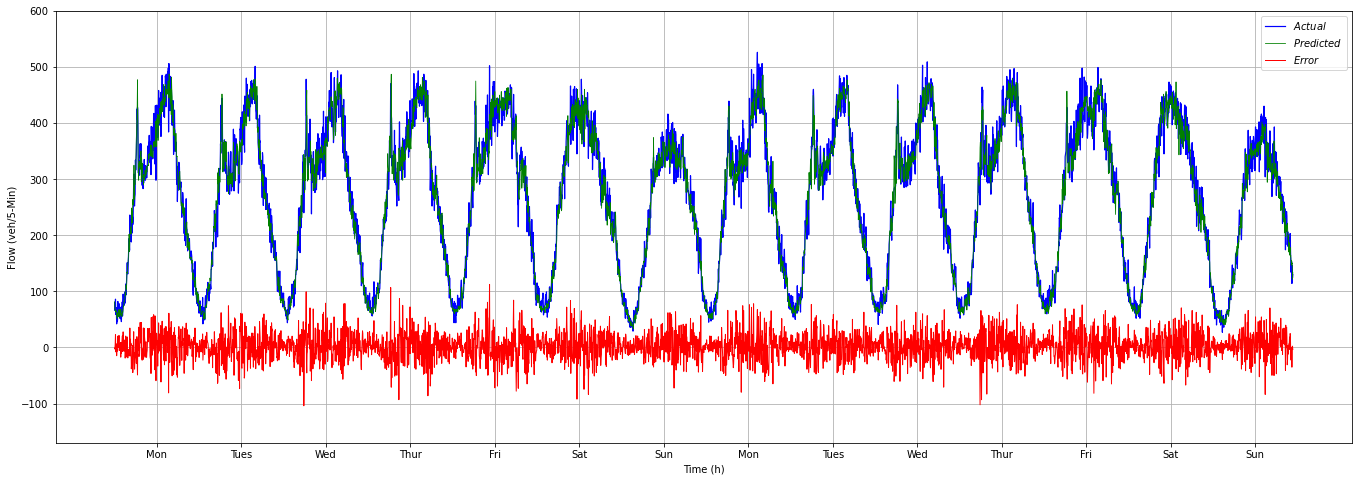

In [32]:
# Create Figure (empty canvas)
fig = plt.figure(figsize=(18,6))

# Add set of axes to figure
axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)

# Plot on that set of axes
axes.plot(yv5, lw=1.2, label=r'$Actual$', color='blue')
axes.plot(test_predictions5, lw=0.8, label=r'$Predicted$', color='green')
axes.plot((yv5-test_predictions5), lw=1, label=r'$Error$', color='red')

#axes.set_xlim(0,24)
axes.set_ylim(-170,600)
axes.set_xlabel('Time (h)')
axes.set_ylabel('Flow (veh/5-Min)')

axes.legend(loc=1)
axes.grid()

axes.set_xticks([144 + i for i in range(0, 4032, 288)])
axes.set_xticklabels(['Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']*2)

plt.show()

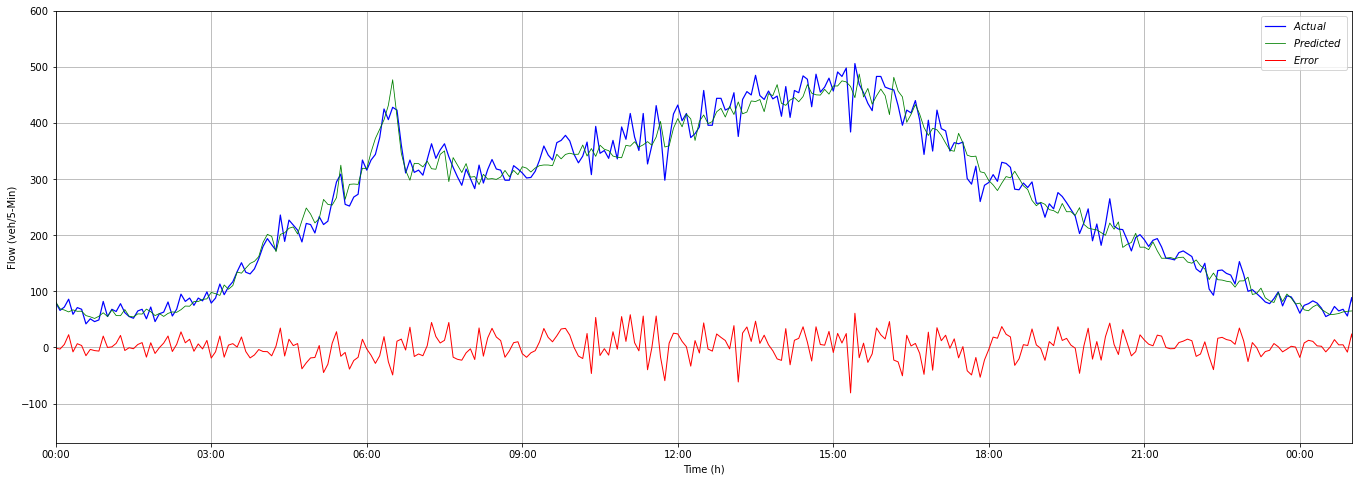

In [33]:
# Create Figure (empty canvas)
fig = plt.figure(figsize=(18,6))

# Add set of axes to figure
axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)

# Plot on that set of axes
axes.plot(yv5, lw=1.2, label=r'$Actual$', color='blue')
axes.plot(test_predictions5, lw=0.8, label=r'$Predicted$', color='green')
axes.plot((yv5-test_predictions5), lw=1, label=r'$Error$', color='red')

axes.set_xlim(0,300)
axes.set_ylim(-170,600)
axes.set_xlabel('Time (h)')
axes.set_ylabel('Flow (veh/5-Min)')

axes.legend(loc=1)
axes.grid()

axes.set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
axes.set_xticklabels(['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00','00:00'])

plt.show()

# 15 mins ahead

In [34]:
def build_model_15(hp):
    # define model
    model_15 = Sequential()
    
    # 2 layer LSTM
    model_15.add(LSTM(units=hp.Int("Units_1", min_value=1, max_value=100, step=1),
                     activation='relu', return_sequences=True, input_shape=input_shape))
    model_15.add(LSTM(units=hp.Int("Units_2", min_value=1, max_value=100, step=1),
                     activation='relu'))
    
    # Final Prediction
    model_15.add(Dense(1))
    
    model_15.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss='mse',metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
    
    return model_15

In [35]:
tuner15 = RandomSearch(
    build_model_15,
    objective="val_loss",
    max_trials=60,
    executions_per_trial=5,
    overwrite=False,
    directory=os.path.normpath('C:/Runs'),
    project_name="6a-LSTM-15"
)

INFO:tensorflow:Reloading Oracle from existing project C:\Runs\6a-LSTM-15\oracle.json
INFO:tensorflow:Reloading Tuner from C:\Runs\6a-LSTM-15\tuner0.json


In [36]:
tuner15.search_space_summary()

Search space summary
Default search space size: 3
Units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
Units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [37]:
tuner15.search(Xt15, yt15, epochs=200,
            validation_split = val_percent,
            callbacks=[early_stop], 
            verbose=2)

INFO:tensorflow:Oracle triggered exit


In [38]:
tuner15.results_summary(1)

Results summary
Results in C:\Runs\6a-LSTM-15
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
Units_1: 94
Units_2: 84
learning_rate: 0.001
Score: 0.002308266889303923


### Best Model

In [39]:
best_hp15 = tuner15.get_best_hyperparameters()[0]
model15 = tuner15.hypermodel.build(best_hp15)

In [40]:
scaler_filename = "Best_HP/6a-LSTM-15"
joblib.dump(best_hp15, scaler_filename) 

['Best_HP/6a-LSTM-15']

In [41]:
model15.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 94)            38352     
_________________________________________________________________
lstm_1 (LSTM)                (None, 84)                60144     
_________________________________________________________________
dense (Dense)                (None, 1)                 85        
Total params: 98,581
Trainable params: 98,581
Non-trainable params: 0
_________________________________________________________________


In [42]:
# model15.fit(Xt15, yt15, 
#             epochs = 100,
#             verbose = 0)

In [43]:
#metrics15 = pd.DataFrame(model15.history.history)

In [44]:
#metrics15[['loss']].plot()

In [45]:
MSE15  = []
MAE15  = []
RMSE15 = []
MAPE15 = []

for i in range(100):
    print(f"run: {i+1}")
    model15.fit((Xt15), yt15, 
            epochs = 200, validation_split = val_percent,
            callbacks = [stop],
            verbose = 1)
    
    test_predictions15 = model15.predict((Xv15))

    yv15 = scaler.inverse_transform(Test.drop('Timestamp', axis = 1))
    yv15 = yv15[17:,4]

    df = Test.drop(Test.head(17).index)
    df.reset_index(inplace = True)
    df = df.drop(columns=['index','Timestamp'])
    df['f5'] = pd.Series(test_predictions15.flatten())

    test_predictions15 = scaler.inverse_transform(df)

    test_predictions15 = test_predictions15[:,4]

    MSE15.append(mean_squared_error(yv15,test_predictions15))

    MAE15.append(mean_absolute_error(yv15,test_predictions15))

    RMSE15.append(np.sqrt(mean_squared_error(yv15,test_predictions15)))

    MAPE15.append(mean_absolute_percentage_error(yv15,test_predictions15)*100)


    current_mse = mean_squared_error(yv15,test_predictions15)
    if all(i > current_mse for i in MSE15):
        model15.save("my_dir/6a-LSTM-15")

eval15 = [mean(MSE15), mean(MAE15), mean(RMSE15), mean(MAPE15)]
std15 = [stdev(MSE15), stdev(MAE15), stdev(RMSE15), stdev(MAPE15)]
print(eval15)

run: 1
Epoch 1/200
846/846 [==============================] - 15s 17ms/step - loss: 0.0057 - mean_absolute_error: 0.0495 - root_mean_squared_error: 0.0758 - mean_absolute_percentage_error: 7798.5303 - val_loss: 0.0028 - val_mean_absolute_error: 0.0400 - val_root_mean_squared_error: 0.0533 - val_mean_absolute_percentage_error: 12.2727
Epoch 2/200
846/846 [==============================] - 14s 16ms/step - loss: 0.0031 - mean_absolute_error: 0.0407 - root_mean_squared_error: 0.0557 - mean_absolute_percentage_error: 3912.3569 - val_loss: 0.0028 - val_mean_absolute_error: 0.0397 - val_root_mean_squared_error: 0.0526 - val_mean_absolute_percentage_error: 12.1332
Epoch 3/200
846/846 [==============================] - 14s 16ms/step - loss: 0.0030 - mean_absolute_error: 0.0400 - root_mean_squared_error: 0.0545 - mean_absolute_percentage_error: 3127.8413 - val_loss: 0.0027 - val_mean_absolute_error: 0.0393 - val_root_mean_squared_error: 0.0521 - val_mean_absolute_percentage_error: 12.2307
Epoch 

Epoch 8/200
846/846 [==============================] - 14s 16ms/step - loss: 0.0023 - mean_absolute_error: 0.0359 - root_mean_squared_error: 0.0480 - mean_absolute_percentage_error: 3916.8694 - val_loss: 0.0023 - val_mean_absolute_error: 0.0369 - val_root_mean_squared_error: 0.0485 - val_mean_absolute_percentage_error: 12.0134
Epoch 9/200
846/846 [==============================] - 13s 16ms/step - loss: 0.0023 - mean_absolute_error: 0.0355 - root_mean_squared_error: 0.0475 - mean_absolute_percentage_error: 3801.7610 - val_loss: 0.0024 - val_mean_absolute_error: 0.0374 - val_root_mean_squared_error: 0.0493 - val_mean_absolute_percentage_error: 11.3484
Epoch 10/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0023 - mean_absolute_error: 0.0357 - root_mean_squared_error: 0.0479 - mean_absolute_percentage_error: 3252.6646 - val_loss: 0.0024 - val_mean_absolute_error: 0.0371 - val_root_mean_squared_error: 0.0488 - val_mean_absolute_percentage_error: 11.2653
Epoch 11/200

Epoch 7/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0022 - mean_absolute_error: 0.0347 - root_mean_squared_error: 0.0464 - mean_absolute_percentage_error: 3314.1492 - val_loss: 0.0023 - val_mean_absolute_error: 0.0365 - val_root_mean_squared_error: 0.0482 - val_mean_absolute_percentage_error: 11.2064
Epoch 8/200
846/846 [==============================] - 14s 16ms/step - loss: 0.0022 - mean_absolute_error: 0.0348 - root_mean_squared_error: 0.0465 - mean_absolute_percentage_error: 3049.3738 - val_loss: 0.0024 - val_mean_absolute_error: 0.0366 - val_root_mean_squared_error: 0.0485 - val_mean_absolute_percentage_error: 11.0510
run: 5
Epoch 1/200
846/846 [==============================] - 14s 16ms/step - loss: 0.0022 - mean_absolute_error: 0.0349 - root_mean_squared_error: 0.0467 - mean_absolute_percentage_error: 3791.5317 - val_loss: 0.0023 - val_mean_absolute_error: 0.0364 - val_root_mean_squared_error: 0.0480 - val_mean_absolute_percentage_error: 11.4632
Epoch 

Epoch 14/200
846/846 [==============================] - 14s 16ms/step - loss: 0.0021 - mean_absolute_error: 0.0340 - root_mean_squared_error: 0.0456 - mean_absolute_percentage_error: 3102.6458 - val_loss: 0.0023 - val_mean_absolute_error: 0.0364 - val_root_mean_squared_error: 0.0481 - val_mean_absolute_percentage_error: 11.4085
Epoch 15/200
846/846 [==============================] - 13s 16ms/step - loss: 0.0021 - mean_absolute_error: 0.0342 - root_mean_squared_error: 0.0457 - mean_absolute_percentage_error: 3086.3718 - val_loss: 0.0023 - val_mean_absolute_error: 0.0364 - val_root_mean_squared_error: 0.0482 - val_mean_absolute_percentage_error: 11.1344
run: 7
Epoch 1/200
846/846 [==============================] - 14s 16ms/step - loss: 0.0021 - mean_absolute_error: 0.0342 - root_mean_squared_error: 0.0456 - mean_absolute_percentage_error: 3291.2468 - val_loss: 0.0024 - val_mean_absolute_error: 0.0368 - val_root_mean_squared_error: 0.0487 - val_mean_absolute_percentage_error: 11.5217
Epoc

Epoch 5/200
846/846 [==============================] - 14s 16ms/step - loss: 0.0020 - mean_absolute_error: 0.0337 - root_mean_squared_error: 0.0450 - mean_absolute_percentage_error: 2673.2915 - val_loss: 0.0023 - val_mean_absolute_error: 0.0360 - val_root_mean_squared_error: 0.0477 - val_mean_absolute_percentage_error: 11.2613
Epoch 6/200
846/846 [==============================] - 13s 16ms/step - loss: 0.0020 - mean_absolute_error: 0.0337 - root_mean_squared_error: 0.0450 - mean_absolute_percentage_error: 2956.2776 - val_loss: 0.0025 - val_mean_absolute_error: 0.0378 - val_root_mean_squared_error: 0.0501 - val_mean_absolute_percentage_error: 11.5533
Epoch 7/200
846/846 [==============================] - 14s 16ms/step - loss: 0.0020 - mean_absolute_error: 0.0338 - root_mean_squared_error: 0.0451 - mean_absolute_percentage_error: 3098.0891 - val_loss: 0.0024 - val_mean_absolute_error: 0.0371 - val_root_mean_squared_error: 0.0491 - val_mean_absolute_percentage_error: 11.6623
Epoch 8/200
8

Epoch 6/200
846/846 [==============================] - 13s 16ms/step - loss: 0.0020 - mean_absolute_error: 0.0335 - root_mean_squared_error: 0.0447 - mean_absolute_percentage_error: 3123.4241 - val_loss: 0.0023 - val_mean_absolute_error: 0.0361 - val_root_mean_squared_error: 0.0481 - val_mean_absolute_percentage_error: 11.2310
Epoch 7/200
846/846 [==============================] - 13s 16ms/step - loss: 0.0020 - mean_absolute_error: 0.0334 - root_mean_squared_error: 0.0446 - mean_absolute_percentage_error: 3037.6658 - val_loss: 0.0023 - val_mean_absolute_error: 0.0358 - val_root_mean_squared_error: 0.0476 - val_mean_absolute_percentage_error: 11.1569
run: 13
Epoch 1/200
846/846 [==============================] - 14s 16ms/step - loss: 0.0020 - mean_absolute_error: 0.0336 - root_mean_squared_error: 0.0448 - mean_absolute_percentage_error: 3141.9058 - val_loss: 0.0023 - val_mean_absolute_error: 0.0362 - val_root_mean_squared_error: 0.0480 - val_mean_absolute_percentage_error: 11.1173
Epoch

Epoch 4/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0020 - mean_absolute_error: 0.0333 - root_mean_squared_error: 0.0443 - mean_absolute_percentage_error: 2927.2515 - val_loss: 0.0023 - val_mean_absolute_error: 0.0363 - val_root_mean_squared_error: 0.0483 - val_mean_absolute_percentage_error: 11.0880
Epoch 5/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0020 - mean_absolute_error: 0.0332 - root_mean_squared_error: 0.0443 - mean_absolute_percentage_error: 2959.8823 - val_loss: 0.0023 - val_mean_absolute_error: 0.0362 - val_root_mean_squared_error: 0.0481 - val_mean_absolute_percentage_error: 11.2566
Epoch 6/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0020 - mean_absolute_error: 0.0332 - root_mean_squared_error: 0.0443 - mean_absolute_percentage_error: 3179.5542 - val_loss: 0.0023 - val_mean_absolute_error: 0.0361 - val_root_mean_squared_error: 0.0479 - val_mean_absolute_percentage_error: 11.3396
Epoch 7/200
8

run: 18
Epoch 1/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0019 - mean_absolute_error: 0.0329 - root_mean_squared_error: 0.0439 - mean_absolute_percentage_error: 2811.5024 - val_loss: 0.0023 - val_mean_absolute_error: 0.0364 - val_root_mean_squared_error: 0.0484 - val_mean_absolute_percentage_error: 11.0534
Epoch 2/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0019 - mean_absolute_error: 0.0328 - root_mean_squared_error: 0.0437 - mean_absolute_percentage_error: 2700.7954 - val_loss: 0.0024 - val_mean_absolute_error: 0.0368 - val_root_mean_squared_error: 0.0489 - val_mean_absolute_percentage_error: 11.5895
Epoch 3/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0019 - mean_absolute_error: 0.0328 - root_mean_squared_error: 0.0436 - mean_absolute_percentage_error: 2953.6680 - val_loss: 0.0026 - val_mean_absolute_error: 0.0379 - val_root_mean_squared_error: 0.0507 - val_mean_absolute_percentage_error: 11.4128
Epoch

Epoch 9/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0019 - mean_absolute_error: 0.0326 - root_mean_squared_error: 0.0433 - mean_absolute_percentage_error: 3866.2075 - val_loss: 0.0024 - val_mean_absolute_error: 0.0366 - val_root_mean_squared_error: 0.0489 - val_mean_absolute_percentage_error: 11.4224
Epoch 10/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0019 - mean_absolute_error: 0.0324 - root_mean_squared_error: 0.0432 - mean_absolute_percentage_error: 2904.2947 - val_loss: 0.0024 - val_mean_absolute_error: 0.0367 - val_root_mean_squared_error: 0.0494 - val_mean_absolute_percentage_error: 11.1873
run: 21
Epoch 1/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0019 - mean_absolute_error: 0.0325 - root_mean_squared_error: 0.0433 - mean_absolute_percentage_error: 2706.4658 - val_loss: 0.0026 - val_mean_absolute_error: 0.0382 - val_root_mean_squared_error: 0.0506 - val_mean_absolute_percentage_error: 12.2375
Epoc

Epoch 7/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0018 - mean_absolute_error: 0.0322 - root_mean_squared_error: 0.0428 - mean_absolute_percentage_error: 2805.5833 - val_loss: 0.0025 - val_mean_absolute_error: 0.0372 - val_root_mean_squared_error: 0.0497 - val_mean_absolute_percentage_error: 11.0509
Epoch 8/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0018 - mean_absolute_error: 0.0323 - root_mean_squared_error: 0.0429 - mean_absolute_percentage_error: 3077.3345 - val_loss: 0.0025 - val_mean_absolute_error: 0.0375 - val_root_mean_squared_error: 0.0504 - val_mean_absolute_percentage_error: 11.5711
Epoch 9/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0018 - mean_absolute_error: 0.0322 - root_mean_squared_error: 0.0429 - mean_absolute_percentage_error: 3312.4131 - val_loss: 0.0024 - val_mean_absolute_error: 0.0368 - val_root_mean_squared_error: 0.0491 - val_mean_absolute_percentage_error: 11.1764
run: 24
Epoch

Epoch 7/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0018 - mean_absolute_error: 0.0321 - root_mean_squared_error: 0.0428 - mean_absolute_percentage_error: 2960.8333 - val_loss: 0.0024 - val_mean_absolute_error: 0.0364 - val_root_mean_squared_error: 0.0485 - val_mean_absolute_percentage_error: 11.1107
Epoch 8/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0018 - mean_absolute_error: 0.0320 - root_mean_squared_error: 0.0425 - mean_absolute_percentage_error: 2766.7935 - val_loss: 0.0025 - val_mean_absolute_error: 0.0376 - val_root_mean_squared_error: 0.0504 - val_mean_absolute_percentage_error: 11.3423
Epoch 9/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0018 - mean_absolute_error: 0.0319 - root_mean_squared_error: 0.0425 - mean_absolute_percentage_error: 2897.5676 - val_loss: 0.0025 - val_mean_absolute_error: 0.0368 - val_root_mean_squared_error: 0.0495 - val_mean_absolute_percentage_error: 11.4910
Epoch 10/200


Epoch 9/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0018 - mean_absolute_error: 0.0318 - root_mean_squared_error: 0.0422 - mean_absolute_percentage_error: 3570.7952 - val_loss: 0.0024 - val_mean_absolute_error: 0.0363 - val_root_mean_squared_error: 0.0487 - val_mean_absolute_percentage_error: 11.3094
Epoch 10/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0018 - mean_absolute_error: 0.0317 - root_mean_squared_error: 0.0421 - mean_absolute_percentage_error: 2797.0107 - val_loss: 0.0025 - val_mean_absolute_error: 0.0374 - val_root_mean_squared_error: 0.0503 - val_mean_absolute_percentage_error: 11.6077
Epoch 11/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0018 - mean_absolute_error: 0.0317 - root_mean_squared_error: 0.0421 - mean_absolute_percentage_error: 3084.4053 - val_loss: 0.0025 - val_mean_absolute_error: 0.0370 - val_root_mean_squared_error: 0.0497 - val_mean_absolute_percentage_error: 10.9980
Epoch 12/20

Epoch 7/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0017 - mean_absolute_error: 0.0315 - root_mean_squared_error: 0.0418 - mean_absolute_percentage_error: 2864.1519 - val_loss: 0.0025 - val_mean_absolute_error: 0.0372 - val_root_mean_squared_error: 0.0499 - val_mean_absolute_percentage_error: 11.1450
Epoch 8/200
846/846 [==============================] - 15s 17ms/step - loss: 0.0017 - mean_absolute_error: 0.0313 - root_mean_squared_error: 0.0416 - mean_absolute_percentage_error: 3105.5112 - val_loss: 0.0025 - val_mean_absolute_error: 0.0372 - val_root_mean_squared_error: 0.0503 - val_mean_absolute_percentage_error: 11.4338
Epoch 9/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0017 - mean_absolute_error: 0.0314 - root_mean_squared_error: 0.0416 - mean_absolute_percentage_error: 2929.6934 - val_loss: 0.0025 - val_mean_absolute_error: 0.0370 - val_root_mean_squared_error: 0.0496 - val_mean_absolute_percentage_error: 11.2835
Epoch 10/200


run: 34
Epoch 1/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0017 - mean_absolute_error: 0.0314 - root_mean_squared_error: 0.0416 - mean_absolute_percentage_error: 3142.5342 - val_loss: 0.0025 - val_mean_absolute_error: 0.0372 - val_root_mean_squared_error: 0.0499 - val_mean_absolute_percentage_error: 11.2531
Epoch 2/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0017 - mean_absolute_error: 0.0313 - root_mean_squared_error: 0.0416 - mean_absolute_percentage_error: 3198.1760 - val_loss: 0.0026 - val_mean_absolute_error: 0.0376 - val_root_mean_squared_error: 0.0507 - val_mean_absolute_percentage_error: 11.3404
Epoch 3/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0017 - mean_absolute_error: 0.0313 - root_mean_squared_error: 0.0416 - mean_absolute_percentage_error: 2777.2231 - val_loss: 0.0026 - val_mean_absolute_error: 0.0375 - val_root_mean_squared_error: 0.0509 - val_mean_absolute_percentage_error: 11.3547
Epoch

Epoch 12/200
846/846 [==============================] - 14s 16ms/step - loss: 0.0017 - mean_absolute_error: 0.0309 - root_mean_squared_error: 0.0410 - mean_absolute_percentage_error: 3058.5576 - val_loss: 0.0025 - val_mean_absolute_error: 0.0375 - val_root_mean_squared_error: 0.0503 - val_mean_absolute_percentage_error: 11.2523
Epoch 13/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0017 - mean_absolute_error: 0.0309 - root_mean_squared_error: 0.0410 - mean_absolute_percentage_error: 3672.1785 - val_loss: 0.0026 - val_mean_absolute_error: 0.0377 - val_root_mean_squared_error: 0.0506 - val_mean_absolute_percentage_error: 11.6350
run: 36
Epoch 1/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0017 - mean_absolute_error: 0.0309 - root_mean_squared_error: 0.0410 - mean_absolute_percentage_error: 2967.2563 - val_loss: 0.0026 - val_mean_absolute_error: 0.0379 - val_root_mean_squared_error: 0.0508 - val_mean_absolute_percentage_error: 11.6923
Epo

Epoch 5/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0017 - mean_absolute_error: 0.0306 - root_mean_squared_error: 0.0406 - mean_absolute_percentage_error: 3149.3274 - val_loss: 0.0027 - val_mean_absolute_error: 0.0385 - val_root_mean_squared_error: 0.0515 - val_mean_absolute_percentage_error: 11.5226
Epoch 6/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0016 - mean_absolute_error: 0.0305 - root_mean_squared_error: 0.0405 - mean_absolute_percentage_error: 3209.8752 - val_loss: 0.0027 - val_mean_absolute_error: 0.0383 - val_root_mean_squared_error: 0.0516 - val_mean_absolute_percentage_error: 11.3490
Epoch 7/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0016 - mean_absolute_error: 0.0303 - root_mean_squared_error: 0.0403 - mean_absolute_percentage_error: 3490.1414 - val_loss: 0.0027 - val_mean_absolute_error: 0.0385 - val_root_mean_squared_error: 0.0519 - val_mean_absolute_percentage_error: 12.0260
Epoch 8/200
8

Epoch 4/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0016 - mean_absolute_error: 0.0304 - root_mean_squared_error: 0.0403 - mean_absolute_percentage_error: 2838.0869 - val_loss: 0.0026 - val_mean_absolute_error: 0.0382 - val_root_mean_squared_error: 0.0513 - val_mean_absolute_percentage_error: 12.1140
Epoch 5/200
846/846 [==============================] - 14s 16ms/step - loss: 0.0016 - mean_absolute_error: 0.0303 - root_mean_squared_error: 0.0403 - mean_absolute_percentage_error: 2566.6855 - val_loss: 0.0027 - val_mean_absolute_error: 0.0384 - val_root_mean_squared_error: 0.0522 - val_mean_absolute_percentage_error: 11.7090
Epoch 6/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0016 - mean_absolute_error: 0.0302 - root_mean_squared_error: 0.0401 - mean_absolute_percentage_error: 2778.7998 - val_loss: 0.0026 - val_mean_absolute_error: 0.0378 - val_root_mean_squared_error: 0.0510 - val_mean_absolute_percentage_error: 11.4246
Epoch 7/200
8

Epoch 4/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0016 - mean_absolute_error: 0.0300 - root_mean_squared_error: 0.0397 - mean_absolute_percentage_error: 3209.1743 - val_loss: 0.0027 - val_mean_absolute_error: 0.0383 - val_root_mean_squared_error: 0.0518 - val_mean_absolute_percentage_error: 11.5674
Epoch 5/200
846/846 [==============================] - 14s 16ms/step - loss: 0.0016 - mean_absolute_error: 0.0300 - root_mean_squared_error: 0.0397 - mean_absolute_percentage_error: 2727.0498 - val_loss: 0.0026 - val_mean_absolute_error: 0.0379 - val_root_mean_squared_error: 0.0511 - val_mean_absolute_percentage_error: 11.5128
Epoch 6/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0016 - mean_absolute_error: 0.0301 - root_mean_squared_error: 0.0399 - mean_absolute_percentage_error: 3145.0913 - val_loss: 0.0027 - val_mean_absolute_error: 0.0385 - val_root_mean_squared_error: 0.0520 - val_mean_absolute_percentage_error: 11.8218
Epoch 7/200
8

Epoch 8/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0015 - mean_absolute_error: 0.0297 - root_mean_squared_error: 0.0393 - mean_absolute_percentage_error: 3283.6902 - val_loss: 0.0027 - val_mean_absolute_error: 0.0381 - val_root_mean_squared_error: 0.0518 - val_mean_absolute_percentage_error: 11.6796
Epoch 9/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0015 - mean_absolute_error: 0.0296 - root_mean_squared_error: 0.0392 - mean_absolute_percentage_error: 2848.3225 - val_loss: 0.0027 - val_mean_absolute_error: 0.0386 - val_root_mean_squared_error: 0.0524 - val_mean_absolute_percentage_error: 11.8726
Epoch 10/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0015 - mean_absolute_error: 0.0295 - root_mean_squared_error: 0.0392 - mean_absolute_percentage_error: 3218.8936 - val_loss: 0.0027 - val_mean_absolute_error: 0.0383 - val_root_mean_squared_error: 0.0517 - val_mean_absolute_percentage_error: 11.9075
Epoch 11/200

Epoch 9/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0015 - mean_absolute_error: 0.0294 - root_mean_squared_error: 0.0388 - mean_absolute_percentage_error: 3270.8552 - val_loss: 0.0027 - val_mean_absolute_error: 0.0384 - val_root_mean_squared_error: 0.0523 - val_mean_absolute_percentage_error: 12.1043
Epoch 10/200
846/846 [==============================] - 14s 16ms/step - loss: 0.0015 - mean_absolute_error: 0.0292 - root_mean_squared_error: 0.0387 - mean_absolute_percentage_error: 2994.2544 - val_loss: 0.0028 - val_mean_absolute_error: 0.0392 - val_root_mean_squared_error: 0.0530 - val_mean_absolute_percentage_error: 11.8146
run: 49
Epoch 1/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0015 - mean_absolute_error: 0.0293 - root_mean_squared_error: 0.0388 - mean_absolute_percentage_error: 3613.5710 - val_loss: 0.0027 - val_mean_absolute_error: 0.0382 - val_root_mean_squared_error: 0.0515 - val_mean_absolute_percentage_error: 11.6859
Epoc

Epoch 15/200
846/846 [==============================] - 14s 16ms/step - loss: 0.0014 - mean_absolute_error: 0.0287 - root_mean_squared_error: 0.0381 - mean_absolute_percentage_error: 3317.1887 - val_loss: 0.0029 - val_mean_absolute_error: 0.0397 - val_root_mean_squared_error: 0.0541 - val_mean_absolute_percentage_error: 11.9042
Epoch 16/200
846/846 [==============================] - 14s 16ms/step - loss: 0.0015 - mean_absolute_error: 0.0289 - root_mean_squared_error: 0.0382 - mean_absolute_percentage_error: 3369.8391 - val_loss: 0.0028 - val_mean_absolute_error: 0.0390 - val_root_mean_squared_error: 0.0530 - val_mean_absolute_percentage_error: 12.0508
Epoch 17/200
846/846 [==============================] - 14s 16ms/step - loss: 0.0015 - mean_absolute_error: 0.0288 - root_mean_squared_error: 0.0381 - mean_absolute_percentage_error: 3306.9595 - val_loss: 0.0028 - val_mean_absolute_error: 0.0387 - val_root_mean_squared_error: 0.0527 - val_mean_absolute_percentage_error: 11.7447
run: 51
Ep

Epoch 23/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0014 - mean_absolute_error: 0.0282 - root_mean_squared_error: 0.0373 - mean_absolute_percentage_error: 3204.6833 - val_loss: 0.0029 - val_mean_absolute_error: 0.0399 - val_root_mean_squared_error: 0.0539 - val_mean_absolute_percentage_error: 12.5385
run: 52
Epoch 1/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0014 - mean_absolute_error: 0.0282 - root_mean_squared_error: 0.0373 - mean_absolute_percentage_error: 3419.9714 - val_loss: 0.0029 - val_mean_absolute_error: 0.0394 - val_root_mean_squared_error: 0.0535 - val_mean_absolute_percentage_error: 11.8779
Epoch 2/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0014 - mean_absolute_error: 0.0282 - root_mean_squared_error: 0.0374 - mean_absolute_percentage_error: 3194.2856 - val_loss: 0.0029 - val_mean_absolute_error: 0.0397 - val_root_mean_squared_error: 0.0539 - val_mean_absolute_percentage_error: 12.0954
Epoc

Epoch 4/200
846/846 [==============================] - 14s 16ms/step - loss: 0.0013 - mean_absolute_error: 0.0278 - root_mean_squared_error: 0.0367 - mean_absolute_percentage_error: 3136.2703 - val_loss: 0.0030 - val_mean_absolute_error: 0.0400 - val_root_mean_squared_error: 0.0545 - val_mean_absolute_percentage_error: 12.1190
Epoch 5/200
846/846 [==============================] - 14s 16ms/step - loss: 0.0014 - mean_absolute_error: 0.0279 - root_mean_squared_error: 0.0368 - mean_absolute_percentage_error: 3077.3904 - val_loss: 0.0028 - val_mean_absolute_error: 0.0391 - val_root_mean_squared_error: 0.0527 - val_mean_absolute_percentage_error: 12.0668
Epoch 6/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0013 - mean_absolute_error: 0.0277 - root_mean_squared_error: 0.0366 - mean_absolute_percentage_error: 3009.8015 - val_loss: 0.0030 - val_mean_absolute_error: 0.0403 - val_root_mean_squared_error: 0.0544 - val_mean_absolute_percentage_error: 12.2012
Epoch 7/200
8

Epoch 6/200
846/846 [==============================] - 14s 16ms/step - loss: 0.0013 - mean_absolute_error: 0.0274 - root_mean_squared_error: 0.0363 - mean_absolute_percentage_error: 3000.7063 - val_loss: 0.0030 - val_mean_absolute_error: 0.0400 - val_root_mean_squared_error: 0.0546 - val_mean_absolute_percentage_error: 11.8299
Epoch 7/200
846/846 [==============================] - 14s 16ms/step - loss: 0.0013 - mean_absolute_error: 0.0275 - root_mean_squared_error: 0.0363 - mean_absolute_percentage_error: 2974.5266 - val_loss: 0.0029 - val_mean_absolute_error: 0.0394 - val_root_mean_squared_error: 0.0536 - val_mean_absolute_percentage_error: 12.2807
Epoch 8/200
846/846 [==============================] - 14s 16ms/step - loss: 0.0013 - mean_absolute_error: 0.0275 - root_mean_squared_error: 0.0362 - mean_absolute_percentage_error: 2950.3718 - val_loss: 0.0029 - val_mean_absolute_error: 0.0397 - val_root_mean_squared_error: 0.0539 - val_mean_absolute_percentage_error: 11.9504
Epoch 9/200
8

Epoch 12/200
846/846 [==============================] - 14s 16ms/step - loss: 0.0013 - mean_absolute_error: 0.0270 - root_mean_squared_error: 0.0356 - mean_absolute_percentage_error: 3236.0908 - val_loss: 0.0030 - val_mean_absolute_error: 0.0405 - val_root_mean_squared_error: 0.0551 - val_mean_absolute_percentage_error: 12.3152
run: 60
Epoch 1/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0013 - mean_absolute_error: 0.0271 - root_mean_squared_error: 0.0358 - mean_absolute_percentage_error: 2724.4331 - val_loss: 0.0030 - val_mean_absolute_error: 0.0402 - val_root_mean_squared_error: 0.0546 - val_mean_absolute_percentage_error: 12.0227
Epoch 2/200
846/846 [==============================] - 14s 16ms/step - loss: 0.0013 - mean_absolute_error: 0.0271 - root_mean_squared_error: 0.0358 - mean_absolute_percentage_error: 3290.2427 - val_loss: 0.0029 - val_mean_absolute_error: 0.0399 - val_root_mean_squared_error: 0.0540 - val_mean_absolute_percentage_error: 11.9558
Epoc

Epoch 6/200
846/846 [==============================] - 14s 16ms/step - loss: 0.0013 - mean_absolute_error: 0.0270 - root_mean_squared_error: 0.0356 - mean_absolute_percentage_error: 3041.3140 - val_loss: 0.0029 - val_mean_absolute_error: 0.0396 - val_root_mean_squared_error: 0.0535 - val_mean_absolute_percentage_error: 11.9815
Epoch 7/200
846/846 [==============================] - 14s 16ms/step - loss: 0.0012 - mean_absolute_error: 0.0265 - root_mean_squared_error: 0.0350 - mean_absolute_percentage_error: 2982.1975 - val_loss: 0.0030 - val_mean_absolute_error: 0.0402 - val_root_mean_squared_error: 0.0544 - val_mean_absolute_percentage_error: 12.4641
Epoch 8/200
846/846 [==============================] - 14s 16ms/step - loss: 0.0012 - mean_absolute_error: 0.0266 - root_mean_squared_error: 0.0350 - mean_absolute_percentage_error: 3498.9553 - val_loss: 0.0030 - val_mean_absolute_error: 0.0405 - val_root_mean_squared_error: 0.0552 - val_mean_absolute_percentage_error: 12.3800
Epoch 9/200
8

Epoch 10/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0012 - mean_absolute_error: 0.0261 - root_mean_squared_error: 0.0344 - mean_absolute_percentage_error: 2858.9758 - val_loss: 0.0030 - val_mean_absolute_error: 0.0403 - val_root_mean_squared_error: 0.0549 - val_mean_absolute_percentage_error: 12.0303
Epoch 11/200
846/846 [==============================] - 14s 16ms/step - loss: 0.0012 - mean_absolute_error: 0.0261 - root_mean_squared_error: 0.0344 - mean_absolute_percentage_error: 3119.0581 - val_loss: 0.0031 - val_mean_absolute_error: 0.0410 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_percentage_error: 11.9227
Epoch 12/200
846/846 [==============================] - 14s 16ms/step - loss: 0.0012 - mean_absolute_error: 0.0261 - root_mean_squared_error: 0.0343 - mean_absolute_percentage_error: 3161.4329 - val_loss: 0.0030 - val_mean_absolute_error: 0.0404 - val_root_mean_squared_error: 0.0545 - val_mean_absolute_percentage_error: 12.1886
Epoch 13/2

Epoch 5/200
846/846 [==============================] - 14s 16ms/step - loss: 0.0012 - mean_absolute_error: 0.0258 - root_mean_squared_error: 0.0340 - mean_absolute_percentage_error: 3623.3418 - val_loss: 0.0030 - val_mean_absolute_error: 0.0406 - val_root_mean_squared_error: 0.0549 - val_mean_absolute_percentage_error: 12.4460
Epoch 6/200
846/846 [==============================] - 14s 16ms/step - loss: 0.0011 - mean_absolute_error: 0.0258 - root_mean_squared_error: 0.0339 - mean_absolute_percentage_error: 2979.8730 - val_loss: 0.0032 - val_mean_absolute_error: 0.0417 - val_root_mean_squared_error: 0.0566 - val_mean_absolute_percentage_error: 12.9966
Epoch 7/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0012 - mean_absolute_error: 0.0259 - root_mean_squared_error: 0.0339 - mean_absolute_percentage_error: 3343.7305 - val_loss: 0.0031 - val_mean_absolute_error: 0.0411 - val_root_mean_squared_error: 0.0557 - val_mean_absolute_percentage_error: 12.5232
Epoch 8/200
8

Epoch 14/200
846/846 [==============================] - 15s 18ms/step - loss: 0.0011 - mean_absolute_error: 0.0253 - root_mean_squared_error: 0.0333 - mean_absolute_percentage_error: 2875.7051 - val_loss: 0.0031 - val_mean_absolute_error: 0.0416 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_percentage_error: 12.5332
Epoch 15/200
846/846 [==============================] - 13s 16ms/step - loss: 0.0011 - mean_absolute_error: 0.0253 - root_mean_squared_error: 0.0333 - mean_absolute_percentage_error: 2897.7002 - val_loss: 0.0032 - val_mean_absolute_error: 0.0421 - val_root_mean_squared_error: 0.0569 - val_mean_absolute_percentage_error: 12.3267
run: 70
Epoch 1/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0011 - mean_absolute_error: 0.0254 - root_mean_squared_error: 0.0334 - mean_absolute_percentage_error: 2848.7021 - val_loss: 0.0032 - val_mean_absolute_error: 0.0411 - val_root_mean_squared_error: 0.0562 - val_mean_absolute_percentage_error: 12.0658
Epo

Epoch 3/200
846/846 [==============================] - 13s 16ms/step - loss: 0.0011 - mean_absolute_error: 0.0252 - root_mean_squared_error: 0.0330 - mean_absolute_percentage_error: 3214.8201 - val_loss: 0.0031 - val_mean_absolute_error: 0.0409 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_percentage_error: 12.1666
Epoch 4/200
846/846 [==============================] - 14s 16ms/step - loss: 0.0011 - mean_absolute_error: 0.0249 - root_mean_squared_error: 0.0327 - mean_absolute_percentage_error: 3348.2908 - val_loss: 0.0031 - val_mean_absolute_error: 0.0412 - val_root_mean_squared_error: 0.0556 - val_mean_absolute_percentage_error: 12.0420
Epoch 5/200
846/846 [==============================] - 14s 16ms/step - loss: 0.0011 - mean_absolute_error: 0.0250 - root_mean_squared_error: 0.0328 - mean_absolute_percentage_error: 2698.0408 - val_loss: 0.0033 - val_mean_absolute_error: 0.0421 - val_root_mean_squared_error: 0.0571 - val_mean_absolute_percentage_error: 12.4587
Epoch 6/200
8

Epoch 6/200
846/846 [==============================] - 14s 16ms/step - loss: 0.0011 - mean_absolute_error: 0.0248 - root_mean_squared_error: 0.0324 - mean_absolute_percentage_error: 3228.4702 - val_loss: 0.0032 - val_mean_absolute_error: 0.0416 - val_root_mean_squared_error: 0.0562 - val_mean_absolute_percentage_error: 12.4604
Epoch 7/200
846/846 [==============================] - 14s 16ms/step - loss: 0.0010 - mean_absolute_error: 0.0245 - root_mean_squared_error: 0.0322 - mean_absolute_percentage_error: 3353.2603 - val_loss: 0.0033 - val_mean_absolute_error: 0.0420 - val_root_mean_squared_error: 0.0573 - val_mean_absolute_percentage_error: 12.3533
Epoch 8/200
846/846 [==============================] - 14s 16ms/step - loss: 0.0010 - mean_absolute_error: 0.0246 - root_mean_squared_error: 0.0322 - mean_absolute_percentage_error: 3064.0210 - val_loss: 0.0032 - val_mean_absolute_error: 0.0416 - val_root_mean_squared_error: 0.0563 - val_mean_absolute_percentage_error: 12.6227
Epoch 9/200
8

Epoch 7/200
846/846 [==============================] - 14s 16ms/step - loss: 0.0014 - mean_absolute_error: 0.0287 - root_mean_squared_error: 0.0378 - mean_absolute_percentage_error: 2991.6138 - val_loss: 0.0028 - val_mean_absolute_error: 0.0396 - val_root_mean_squared_error: 0.0530 - val_mean_absolute_percentage_error: 11.9527
Epoch 8/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0013 - mean_absolute_error: 0.0278 - root_mean_squared_error: 0.0366 - mean_absolute_percentage_error: 3280.9875 - val_loss: 0.0029 - val_mean_absolute_error: 0.0396 - val_root_mean_squared_error: 0.0534 - val_mean_absolute_percentage_error: 12.1586
run: 77
Epoch 1/200
846/846 [==============================] - 14s 16ms/step - loss: 0.0019 - mean_absolute_error: 0.0326 - root_mean_squared_error: 0.0436 - mean_absolute_percentage_error: 2957.0149 - val_loss: 0.0026 - val_mean_absolute_error: 0.0382 - val_root_mean_squared_error: 0.0511 - val_mean_absolute_percentage_error: 12.0209
Epoch

Epoch 6/200
846/846 [==============================] - 14s 16ms/step - loss: 0.0010 - mean_absolute_error: 0.0245 - root_mean_squared_error: 0.0320 - mean_absolute_percentage_error: 2967.8948 - val_loss: 0.0032 - val_mean_absolute_error: 0.0420 - val_root_mean_squared_error: 0.0568 - val_mean_absolute_percentage_error: 12.3964
Epoch 7/200
846/846 [==============================] - 14s 16ms/step - loss: 0.0010 - mean_absolute_error: 0.0246 - root_mean_squared_error: 0.0323 - mean_absolute_percentage_error: 2651.7092 - val_loss: 0.0032 - val_mean_absolute_error: 0.0419 - val_root_mean_squared_error: 0.0564 - val_mean_absolute_percentage_error: 12.6789
Epoch 8/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0010 - mean_absolute_error: 0.0245 - root_mean_squared_error: 0.0320 - mean_absolute_percentage_error: 2869.7073 - val_loss: 0.0031 - val_mean_absolute_error: 0.0409 - val_root_mean_squared_error: 0.0557 - val_mean_absolute_percentage_error: 12.2193
Epoch 9/200
8

Epoch 4/200
846/846 [==============================] - 14s 17ms/step - loss: 9.8952e-04 - mean_absolute_error: 0.0241 - root_mean_squared_error: 0.0315 - mean_absolute_percentage_error: 2660.7974 - val_loss: 0.0031 - val_mean_absolute_error: 0.0414 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_percentage_error: 12.1252
Epoch 5/200
846/846 [==============================] - 14s 16ms/step - loss: 9.9146e-04 - mean_absolute_error: 0.0241 - root_mean_squared_error: 0.0315 - mean_absolute_percentage_error: 3083.7495 - val_loss: 0.0033 - val_mean_absolute_error: 0.0424 - val_root_mean_squared_error: 0.0575 - val_mean_absolute_percentage_error: 12.5526
Epoch 6/200
846/846 [==============================] - 14s 16ms/step - loss: 9.8457e-04 - mean_absolute_error: 0.0240 - root_mean_squared_error: 0.0314 - mean_absolute_percentage_error: 2842.7803 - val_loss: 0.0031 - val_mean_absolute_error: 0.0414 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_percentage_error: 12.4163
E

Epoch 13/200
846/846 [==============================] - 14s 17ms/step - loss: 9.0165e-04 - mean_absolute_error: 0.0230 - root_mean_squared_error: 0.0300 - mean_absolute_percentage_error: 3026.0859 - val_loss: 0.0033 - val_mean_absolute_error: 0.0420 - val_root_mean_squared_error: 0.0573 - val_mean_absolute_percentage_error: 12.3397
Epoch 14/200
846/846 [==============================] - 14s 17ms/step - loss: 9.0843e-04 - mean_absolute_error: 0.0231 - root_mean_squared_error: 0.0301 - mean_absolute_percentage_error: 2710.2473 - val_loss: 0.0033 - val_mean_absolute_error: 0.0421 - val_root_mean_squared_error: 0.0577 - val_mean_absolute_percentage_error: 12.3199
run: 88
Epoch 1/200
846/846 [==============================] - 14s 17ms/step - loss: 9.0799e-04 - mean_absolute_error: 0.0231 - root_mean_squared_error: 0.0301 - mean_absolute_percentage_error: 3141.9368 - val_loss: 0.0035 - val_mean_absolute_error: 0.0434 - val_root_mean_squared_error: 0.0588 - val_mean_absolute_percentage_error:

Epoch 6/200
846/846 [==============================] - 14s 16ms/step - loss: 8.7870e-04 - mean_absolute_error: 0.0228 - root_mean_squared_error: 0.0296 - mean_absolute_percentage_error: 3104.0471 - val_loss: 0.0033 - val_mean_absolute_error: 0.0422 - val_root_mean_squared_error: 0.0577 - val_mean_absolute_percentage_error: 12.6210
run: 90
Epoch 1/200
846/846 [==============================] - 14s 17ms/step - loss: 0.0011 - mean_absolute_error: 0.0258 - root_mean_squared_error: 0.0337 - mean_absolute_percentage_error: 3141.9001 - val_loss: 0.0032 - val_mean_absolute_error: 0.0412 - val_root_mean_squared_error: 0.0565 - val_mean_absolute_percentage_error: 12.1220
Epoch 2/200
846/846 [==============================] - 14s 16ms/step - loss: 9.4890e-04 - mean_absolute_error: 0.0237 - root_mean_squared_error: 0.0308 - mean_absolute_percentage_error: 2455.6216 - val_loss: 0.0033 - val_mean_absolute_error: 0.0423 - val_root_mean_squared_error: 0.0577 - val_mean_absolute_percentage_error: 12.38

Epoch 7/200
846/846 [==============================] - 14s 16ms/step - loss: 8.7792e-04 - mean_absolute_error: 0.0227 - root_mean_squared_error: 0.0296 - mean_absolute_percentage_error: 2941.7070 - val_loss: 0.0033 - val_mean_absolute_error: 0.0421 - val_root_mean_squared_error: 0.0575 - val_mean_absolute_percentage_error: 12.4721
Epoch 8/200
846/846 [==============================] - 14s 16ms/step - loss: 8.6418e-04 - mean_absolute_error: 0.0226 - root_mean_squared_error: 0.0294 - mean_absolute_percentage_error: 2809.2744 - val_loss: 0.0034 - val_mean_absolute_error: 0.0430 - val_root_mean_squared_error: 0.0583 - val_mean_absolute_percentage_error: 12.5966
Epoch 9/200
846/846 [==============================] - 14s 17ms/step - loss: 8.5766e-04 - mean_absolute_error: 0.0225 - root_mean_squared_error: 0.0293 - mean_absolute_percentage_error: 2872.4375 - val_loss: 0.0034 - val_mean_absolute_error: 0.0427 - val_root_mean_squared_error: 0.0581 - val_mean_absolute_percentage_error: 12.6798
r

846/846 [==============================] - 14s 16ms/step - loss: 8.1435e-04 - mean_absolute_error: 0.0219 - root_mean_squared_error: 0.0285 - mean_absolute_percentage_error: 2582.5630 - val_loss: 0.0034 - val_mean_absolute_error: 0.0429 - val_root_mean_squared_error: 0.0586 - val_mean_absolute_percentage_error: 12.5499
Epoch 3/200
846/846 [==============================] - 14s 17ms/step - loss: 7.9306e-04 - mean_absolute_error: 0.0217 - root_mean_squared_error: 0.0282 - mean_absolute_percentage_error: 2702.6777 - val_loss: 0.0035 - val_mean_absolute_error: 0.0434 - val_root_mean_squared_error: 0.0593 - val_mean_absolute_percentage_error: 12.9187
Epoch 4/200
846/846 [==============================] - 14s 16ms/step - loss: 7.9724e-04 - mean_absolute_error: 0.0217 - root_mean_squared_error: 0.0282 - mean_absolute_percentage_error: 2887.6924 - val_loss: 0.0034 - val_mean_absolute_error: 0.0431 - val_root_mean_squared_error: 0.0587 - val_mean_absolute_percentage_error: 12.6477
Epoch 5/200
8

In [46]:
model15 = keras.models.load_model("my_dir/6a-LSTM-15")

In [117]:
runs = {'MSE': MSE15, 'MAE': MAE15, 'RMSE': RMSE15, 'MAPE': MAPE15}
table15 = pd.DataFrame(data=runs)
table15.to_csv("Results/Runs/6a-LSTM-15")

In [118]:
pd.read_csv("Results/Runs/6a-LSTM-15", index_col=0)

,MSE,MAE,RMSE,MAPE
0,749.856695,21.139466,27.383511,9.560874
1,735.895592,21.028930,27.127396,9.794416
2,708.217803,20.467212,26.612362,9.190122
3,711.383317,20.566494,26.671770,9.297762
4,697.588716,20.472867,26.411905,9.401013
...,...,...,...,...
95,1002.973480,24.026319,31.669757,10.283368
96,974.714649,23.657966,31.220420,10.090269
97,1020.457992,24.141198,31.944608,10.315351
98,992.026249,23.822977,31.496448,10.364869


### Evaluation on inverse_transform

In [47]:
test_predictions15 = model15.predict(Xv15)

yv15 = scaler.inverse_transform(Test.drop('Timestamp', axis = 1))
yv15 = yv15[17:,4]

df = Test.drop(Test.head(17).index)
df.reset_index(inplace = True)
df = df.drop(columns=['index','Timestamp'])
df['f5'] = pd.Series(test_predictions15.flatten())

test_predictions15 = scaler.inverse_transform(df)

test_predictions15 = test_predictions15[:,4]

# MSE15 = mean_squared_error(yv15,test_predictions15)

# MAE15 = mean_absolute_error(yv15,test_predictions15)

# RMSE15 = np.sqrt(MSE15)

# MAPE15 = mean_absolute_percentage_error(yv15,test_predictions15)*100

# eval15 = [MSE15, MAE15, RMSE15, MAPE15]
# print(eval15)

In [48]:
RA10 = ra.RA_10(np.asarray(yv15), np.asarray(test_predictions15))
RA15 = ra.RA_15(np.asarray(yv15), np.asarray(test_predictions15))
RA20 = ra.RA_20(np.asarray(yv15), np.asarray(test_predictions15))

res15 = [RA10, RA15, RA20]
print(res15)

[61.22042341220424, 78.13200498132005, 88.44333748443337]


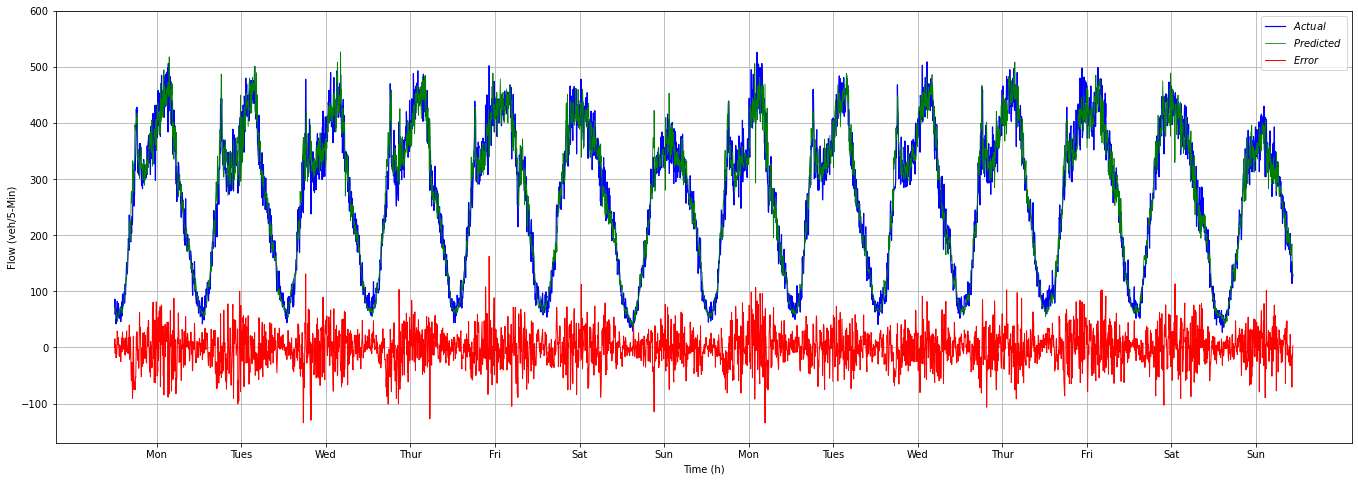

In [49]:
# Create Figure (empty canvas)
fig = plt.figure(figsize=(18,6))

# Add set of axes to figure
axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)

# Plot on that set of axes
axes.plot(yv15, lw=1.2, label=r'$Actual$', color='blue')
axes.plot(test_predictions15, lw=0.8, label=r'$Predicted$', color='green')
axes.plot((yv15-test_predictions15), lw=1, label=r'$Error$', color='red')

#axes.set_xlim(0,24)
axes.set_ylim(-170,600)
axes.set_xlabel('Time (h)')
axes.set_ylabel('Flow (veh/5-Min)')

axes.legend(loc=1)
axes.grid()

axes.set_xticks([144 + i for i in range(0, 4032, 288)])
axes.set_xticklabels(['Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']*2)

plt.show()

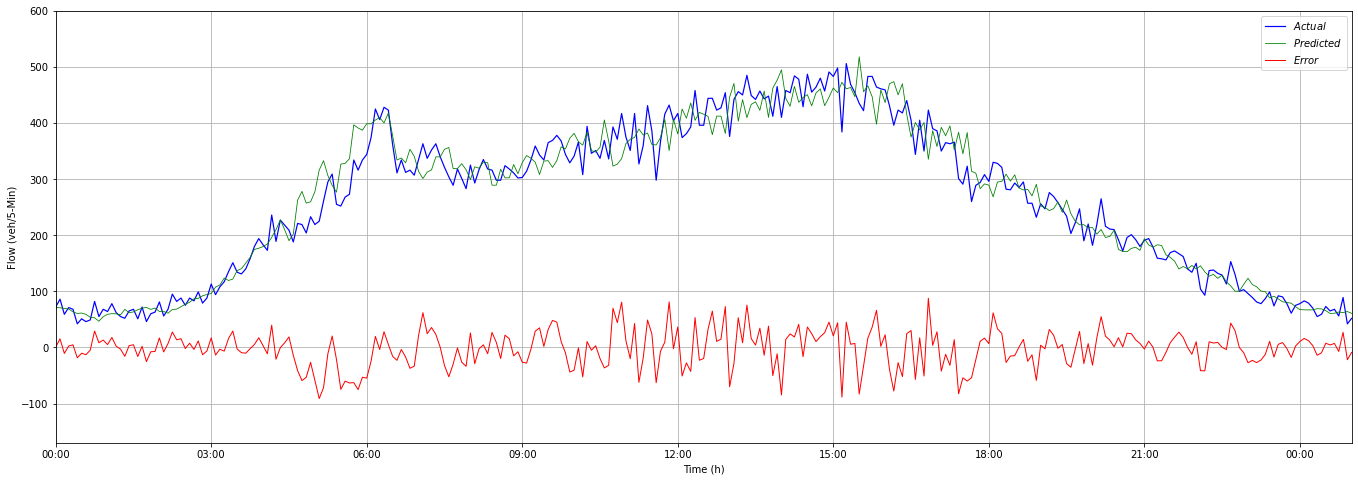

In [50]:
# Create Figure (empty canvas)
fig = plt.figure(figsize=(18,6))

# Add set of axes to figure
axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)

# Plot on that set of axes
axes.plot(yv15, lw=1.2, label=r'$Actual$', color='blue')
axes.plot(test_predictions15, lw=0.8, label=r'$Predicted$', color='green')
axes.plot((yv15-test_predictions15), lw=1, label=r'$Error$', color='red')

axes.set_xlim(0,300)
axes.set_ylim(-170,600)
axes.set_xlabel('Time (h)')
axes.set_ylabel('Flow (veh/5-Min)')

axes.legend(loc=1)
axes.grid()

axes.set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
axes.set_xticklabels(['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00','00:00'])

plt.show()

# 30 mins ahead

In [51]:
def build_model_30(hp):
    # define model
    model_30 = Sequential()
    
    # 2 layer LSTM
    model_30.add(LSTM(units=hp.Int("Units_1", min_value=1, max_value=100, step=1),
                     activation='relu', return_sequences=True, input_shape=input_shape))
    model_30.add(LSTM(units=hp.Int("Units_2", min_value=1, max_value=100, step=1),
                     activation='relu'))
    
    # Final Prediction
    model_30.add(Dense(1))
    
    model_30.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss='mse',metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
    
    return model_30

In [52]:
tuner30 = RandomSearch(
    build_model_30,
    objective="val_loss",
    max_trials=60,
    executions_per_trial=5,
    overwrite=False,
    directory=os.path.normpath('C:/Runs'),
    project_name="6a-LSTM-30",
)

INFO:tensorflow:Reloading Oracle from existing project C:\Runs\6a-LSTM-30\oracle.json
INFO:tensorflow:Reloading Tuner from C:\Runs\6a-LSTM-30\tuner0.json


In [53]:
tuner30.search_space_summary()

Search space summary
Default search space size: 3
Units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
Units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [54]:
tuner30.search(Xt30, yt30, epochs=200,
            validation_split = val_percent,
            callbacks=[early_stop],
            verbose=2)

INFO:tensorflow:Oracle triggered exit


In [55]:
tuner30.results_summary(1)

Results summary
Results in C:\Runs\6a-LSTM-30
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
Units_1: 49
Units_2: 88
learning_rate: 0.001
Score: 0.002561424020677805


### Best Model

In [56]:
best_hp30 = tuner30.get_best_hyperparameters()[0]
model30 = tuner30.hypermodel.build(best_hp30)

In [57]:
scaler_filename = "Best_HP/6a-LSTM-30"
joblib.dump(best_hp30, scaler_filename) 

['Best_HP/6a-LSTM-30']

In [58]:
model30.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 49)            11172     
_________________________________________________________________
lstm_1 (LSTM)                (None, 88)                48576     
_________________________________________________________________
dense (Dense)                (None, 1)                 89        
Total params: 59,837
Trainable params: 59,837
Non-trainable params: 0
_________________________________________________________________


In [59]:
# model30.fit(Xt30, yt30, 
#             epochs = 100,
#             verbose = 0)

In [60]:
#metrics30 = pd.DataFrame(model30.history.history)

In [61]:
#metrics30[['loss']].plot()

In [62]:
MSE30  = []
MAE30  = []
RMSE30 = []
MAPE30 = []

for i in range(100):
    print(f"run: {i+1}")
    model30.fit((Xt30), yt30, 
            epochs = 200, validation_split = val_percent,
            callbacks = [stop],
            verbose = 1)
    
    test_predictions30 = model30.predict((Xv30))

    yv30 = scaler.inverse_transform(Test.drop('Timestamp', axis = 1))
    yv30 = yv30[20:,4]

    df = Test.drop(Test.head(20).index)
    df.reset_index(inplace = True)
    df = df.drop(columns=['index','Timestamp'])
    df['f5'] = pd.Series(test_predictions30.flatten())

    test_predictions30 = scaler.inverse_transform(df)

    test_predictions30 = test_predictions30[:,4]

    MSE30.append(mean_squared_error(yv30,test_predictions30))

    MAE30.append(mean_absolute_error(yv30,test_predictions30))

    RMSE30.append(np.sqrt(mean_squared_error(yv30,test_predictions30)))

    MAPE30.append(mean_absolute_percentage_error(yv30,test_predictions30)*100)


    current_mse = mean_squared_error(yv30,test_predictions30)
    if all(i > current_mse for i in MSE30):
        model30.save("my_dir/6a-LSTM-30")

eval30 = [mean(MSE30), mean(MAE30), mean(RMSE30), mean(MAPE30)]
std30 = [stdev(MSE30), stdev(MAE30), stdev(RMSE30), stdev(MAPE30)]
print(eval30)

run: 1
Epoch 1/200
846/846 [==============================] - 13s 15ms/step - loss: 0.0070 - mean_absolute_error: 0.0574 - root_mean_squared_error: 0.0838 - mean_absolute_percentage_error: 6365.9985 - val_loss: 0.0034 - val_mean_absolute_error: 0.0433 - val_root_mean_squared_error: 0.0583 - val_mean_absolute_percentage_error: 13.1938
Epoch 2/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0039 - mean_absolute_error: 0.0456 - root_mean_squared_error: 0.0624 - mean_absolute_percentage_error: 4689.0088 - val_loss: 0.0035 - val_mean_absolute_error: 0.0447 - val_root_mean_squared_error: 0.0592 - val_mean_absolute_percentage_error: 14.1622
Epoch 3/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0035 - mean_absolute_error: 0.0436 - root_mean_squared_error: 0.0593 - mean_absolute_percentage_error: 4988.3848 - val_loss: 0.0032 - val_mean_absolute_error: 0.0424 - val_root_mean_squared_error: 0.0564 - val_mean_absolute_percentage_error: 12.9701
Epoch 

run: 2
Epoch 1/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0026 - mean_absolute_error: 0.0383 - root_mean_squared_error: 0.0514 - mean_absolute_percentage_error: 4139.1733 - val_loss: 0.0026 - val_mean_absolute_error: 0.0389 - val_root_mean_squared_error: 0.0514 - val_mean_absolute_percentage_error: 11.7711
Epoch 2/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0026 - mean_absolute_error: 0.0378 - root_mean_squared_error: 0.0509 - mean_absolute_percentage_error: 4236.5781 - val_loss: 0.0028 - val_mean_absolute_error: 0.0400 - val_root_mean_squared_error: 0.0528 - val_mean_absolute_percentage_error: 12.6148
Epoch 3/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0026 - mean_absolute_error: 0.0380 - root_mean_squared_error: 0.0510 - mean_absolute_percentage_error: 4406.7212 - val_loss: 0.0026 - val_mean_absolute_error: 0.0383 - val_root_mean_squared_error: 0.0508 - val_mean_absolute_percentage_error: 11.6382
Epoch 

Epoch 6/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0025 - mean_absolute_error: 0.0371 - root_mean_squared_error: 0.0497 - mean_absolute_percentage_error: 3798.0991 - val_loss: 0.0026 - val_mean_absolute_error: 0.0391 - val_root_mean_squared_error: 0.0513 - val_mean_absolute_percentage_error: 12.2754
Epoch 7/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0025 - mean_absolute_error: 0.0370 - root_mean_squared_error: 0.0496 - mean_absolute_percentage_error: 3957.2966 - val_loss: 0.0027 - val_mean_absolute_error: 0.0398 - val_root_mean_squared_error: 0.0524 - val_mean_absolute_percentage_error: 12.6268
Epoch 8/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0024 - mean_absolute_error: 0.0369 - root_mean_squared_error: 0.0494 - mean_absolute_percentage_error: 3809.3250 - val_loss: 0.0026 - val_mean_absolute_error: 0.0388 - val_root_mean_squared_error: 0.0512 - val_mean_absolute_percentage_error: 11.6893
Epoch 9/200
8

Epoch 9/200
846/846 [==============================] - 11s 14ms/step - loss: 0.0024 - mean_absolute_error: 0.0361 - root_mean_squared_error: 0.0485 - mean_absolute_percentage_error: 3535.7173 - val_loss: 0.0027 - val_mean_absolute_error: 0.0398 - val_root_mean_squared_error: 0.0521 - val_mean_absolute_percentage_error: 12.4941
Epoch 10/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0024 - mean_absolute_error: 0.0362 - root_mean_squared_error: 0.0486 - mean_absolute_percentage_error: 3624.6506 - val_loss: 0.0026 - val_mean_absolute_error: 0.0386 - val_root_mean_squared_error: 0.0509 - val_mean_absolute_percentage_error: 12.0456
Epoch 11/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0024 - mean_absolute_error: 0.0363 - root_mean_squared_error: 0.0487 - mean_absolute_percentage_error: 3747.2578 - val_loss: 0.0026 - val_mean_absolute_error: 0.0382 - val_root_mean_squared_error: 0.0507 - val_mean_absolute_percentage_error: 11.5971
Epoch 12/20

run: 9
Epoch 1/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0023 - mean_absolute_error: 0.0358 - root_mean_squared_error: 0.0480 - mean_absolute_percentage_error: 3605.2334 - val_loss: 0.0026 - val_mean_absolute_error: 0.0380 - val_root_mean_squared_error: 0.0507 - val_mean_absolute_percentage_error: 11.5102
Epoch 2/200
846/846 [==============================] - 11s 14ms/step - loss: 0.0023 - mean_absolute_error: 0.0357 - root_mean_squared_error: 0.0480 - mean_absolute_percentage_error: 4282.6851 - val_loss: 0.0026 - val_mean_absolute_error: 0.0390 - val_root_mean_squared_error: 0.0513 - val_mean_absolute_percentage_error: 11.7236
Epoch 3/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0023 - mean_absolute_error: 0.0357 - root_mean_squared_error: 0.0480 - mean_absolute_percentage_error: 3546.6235 - val_loss: 0.0028 - val_mean_absolute_error: 0.0407 - val_root_mean_squared_error: 0.0533 - val_mean_absolute_percentage_error: 13.2039
Epoch 

Epoch 7/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0022 - mean_absolute_error: 0.0352 - root_mean_squared_error: 0.0473 - mean_absolute_percentage_error: 4024.3887 - val_loss: 0.0026 - val_mean_absolute_error: 0.0391 - val_root_mean_squared_error: 0.0512 - val_mean_absolute_percentage_error: 11.9657
Epoch 8/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0022 - mean_absolute_error: 0.0354 - root_mean_squared_error: 0.0474 - mean_absolute_percentage_error: 3957.4641 - val_loss: 0.0027 - val_mean_absolute_error: 0.0388 - val_root_mean_squared_error: 0.0517 - val_mean_absolute_percentage_error: 11.7461
run: 12
Epoch 1/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0023 - mean_absolute_error: 0.0354 - root_mean_squared_error: 0.0475 - mean_absolute_percentage_error: 3983.9844 - val_loss: 0.0026 - val_mean_absolute_error: 0.0385 - val_root_mean_squared_error: 0.0511 - val_mean_absolute_percentage_error: 11.9645
Epoch

Epoch 6/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0022 - mean_absolute_error: 0.0351 - root_mean_squared_error: 0.0471 - mean_absolute_percentage_error: 3591.4128 - val_loss: 0.0027 - val_mean_absolute_error: 0.0397 - val_root_mean_squared_error: 0.0523 - val_mean_absolute_percentage_error: 11.9658
Epoch 7/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0022 - mean_absolute_error: 0.0349 - root_mean_squared_error: 0.0469 - mean_absolute_percentage_error: 3187.5837 - val_loss: 0.0026 - val_mean_absolute_error: 0.0382 - val_root_mean_squared_error: 0.0505 - val_mean_absolute_percentage_error: 11.4800
Epoch 8/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0022 - mean_absolute_error: 0.0349 - root_mean_squared_error: 0.0468 - mean_absolute_percentage_error: 3608.0249 - val_loss: 0.0025 - val_mean_absolute_error: 0.0379 - val_root_mean_squared_error: 0.0502 - val_mean_absolute_percentage_error: 11.5796
Epoch 9/200
8

Epoch 10/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0022 - mean_absolute_error: 0.0349 - root_mean_squared_error: 0.0467 - mean_absolute_percentage_error: 3561.0891 - val_loss: 0.0026 - val_mean_absolute_error: 0.0391 - val_root_mean_squared_error: 0.0515 - val_mean_absolute_percentage_error: 12.2086
Epoch 11/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0022 - mean_absolute_error: 0.0347 - root_mean_squared_error: 0.0464 - mean_absolute_percentage_error: 2989.5374 - val_loss: 0.0026 - val_mean_absolute_error: 0.0387 - val_root_mean_squared_error: 0.0515 - val_mean_absolute_percentage_error: 11.6405
run: 17
Epoch 1/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0022 - mean_absolute_error: 0.0346 - root_mean_squared_error: 0.0464 - mean_absolute_percentage_error: 3355.5178 - val_loss: 0.0027 - val_mean_absolute_error: 0.0388 - val_root_mean_squared_error: 0.0517 - val_mean_absolute_percentage_error: 11.8973
Epo

Epoch 4/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0021 - mean_absolute_error: 0.0344 - root_mean_squared_error: 0.0461 - mean_absolute_percentage_error: 3495.8003 - val_loss: 0.0026 - val_mean_absolute_error: 0.0387 - val_root_mean_squared_error: 0.0514 - val_mean_absolute_percentage_error: 12.2348
Epoch 5/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0021 - mean_absolute_error: 0.0343 - root_mean_squared_error: 0.0459 - mean_absolute_percentage_error: 3488.1433 - val_loss: 0.0027 - val_mean_absolute_error: 0.0392 - val_root_mean_squared_error: 0.0516 - val_mean_absolute_percentage_error: 11.9818
Epoch 6/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0021 - mean_absolute_error: 0.0343 - root_mean_squared_error: 0.0461 - mean_absolute_percentage_error: 3094.3848 - val_loss: 0.0028 - val_mean_absolute_error: 0.0399 - val_root_mean_squared_error: 0.0533 - val_mean_absolute_percentage_error: 12.3947
run: 20
Epoch

Epoch 5/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0021 - mean_absolute_error: 0.0343 - root_mean_squared_error: 0.0459 - mean_absolute_percentage_error: 3623.4060 - val_loss: 0.0029 - val_mean_absolute_error: 0.0406 - val_root_mean_squared_error: 0.0536 - val_mean_absolute_percentage_error: 12.2642
Epoch 6/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0021 - mean_absolute_error: 0.0341 - root_mean_squared_error: 0.0458 - mean_absolute_percentage_error: 3215.7302 - val_loss: 0.0026 - val_mean_absolute_error: 0.0386 - val_root_mean_squared_error: 0.0508 - val_mean_absolute_percentage_error: 11.7627
Epoch 7/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0021 - mean_absolute_error: 0.0342 - root_mean_squared_error: 0.0458 - mean_absolute_percentage_error: 3430.9119 - val_loss: 0.0027 - val_mean_absolute_error: 0.0390 - val_root_mean_squared_error: 0.0519 - val_mean_absolute_percentage_error: 12.0309
Epoch 8/200
8

Epoch 6/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0021 - mean_absolute_error: 0.0340 - root_mean_squared_error: 0.0456 - mean_absolute_percentage_error: 3219.2617 - val_loss: 0.0026 - val_mean_absolute_error: 0.0384 - val_root_mean_squared_error: 0.0505 - val_mean_absolute_percentage_error: 11.8600
Epoch 7/200
846/846 [==============================] - 11s 14ms/step - loss: 0.0021 - mean_absolute_error: 0.0338 - root_mean_squared_error: 0.0453 - mean_absolute_percentage_error: 3511.9834 - val_loss: 0.0026 - val_mean_absolute_error: 0.0386 - val_root_mean_squared_error: 0.0512 - val_mean_absolute_percentage_error: 12.0514
Epoch 8/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0021 - mean_absolute_error: 0.0339 - root_mean_squared_error: 0.0453 - mean_absolute_percentage_error: 2956.1465 - val_loss: 0.0026 - val_mean_absolute_error: 0.0386 - val_root_mean_squared_error: 0.0512 - val_mean_absolute_percentage_error: 11.7679
Epoch 9/200
8

Epoch 11/200
846/846 [==============================] - 11s 14ms/step - loss: 0.0020 - mean_absolute_error: 0.0333 - root_mean_squared_error: 0.0446 - mean_absolute_percentage_error: 3803.3523 - val_loss: 0.0026 - val_mean_absolute_error: 0.0387 - val_root_mean_squared_error: 0.0513 - val_mean_absolute_percentage_error: 11.6967
Epoch 12/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0020 - mean_absolute_error: 0.0332 - root_mean_squared_error: 0.0444 - mean_absolute_percentage_error: 3426.9695 - val_loss: 0.0027 - val_mean_absolute_error: 0.0396 - val_root_mean_squared_error: 0.0522 - val_mean_absolute_percentage_error: 11.9942
Epoch 13/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0020 - mean_absolute_error: 0.0332 - root_mean_squared_error: 0.0444 - mean_absolute_percentage_error: 3209.6492 - val_loss: 0.0027 - val_mean_absolute_error: 0.0401 - val_root_mean_squared_error: 0.0524 - val_mean_absolute_percentage_error: 12.0443
Epoch 14/2

Epoch 2/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0020 - mean_absolute_error: 0.0331 - root_mean_squared_error: 0.0444 - mean_absolute_percentage_error: 3045.4451 - val_loss: 0.0026 - val_mean_absolute_error: 0.0388 - val_root_mean_squared_error: 0.0514 - val_mean_absolute_percentage_error: 12.0031
Epoch 3/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0020 - mean_absolute_error: 0.0332 - root_mean_squared_error: 0.0443 - mean_absolute_percentage_error: 3378.3633 - val_loss: 0.0026 - val_mean_absolute_error: 0.0386 - val_root_mean_squared_error: 0.0511 - val_mean_absolute_percentage_error: 11.7446
Epoch 4/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0020 - mean_absolute_error: 0.0330 - root_mean_squared_error: 0.0442 - mean_absolute_percentage_error: 3612.6912 - val_loss: 0.0027 - val_mean_absolute_error: 0.0393 - val_root_mean_squared_error: 0.0517 - val_mean_absolute_percentage_error: 11.7836
Epoch 5/200
8

Epoch 14/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0019 - mean_absolute_error: 0.0327 - root_mean_squared_error: 0.0437 - mean_absolute_percentage_error: 3480.9004 - val_loss: 0.0026 - val_mean_absolute_error: 0.0390 - val_root_mean_squared_error: 0.0514 - val_mean_absolute_percentage_error: 11.7665
Epoch 15/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0019 - mean_absolute_error: 0.0327 - root_mean_squared_error: 0.0437 - mean_absolute_percentage_error: 3680.5669 - val_loss: 0.0027 - val_mean_absolute_error: 0.0393 - val_root_mean_squared_error: 0.0519 - val_mean_absolute_percentage_error: 11.8219
Epoch 16/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0019 - mean_absolute_error: 0.0327 - root_mean_squared_error: 0.0437 - mean_absolute_percentage_error: 4194.5508 - val_loss: 0.0026 - val_mean_absolute_error: 0.0390 - val_root_mean_squared_error: 0.0511 - val_mean_absolute_percentage_error: 11.6676
Epoch 17/2

Epoch 6/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0019 - mean_absolute_error: 0.0324 - root_mean_squared_error: 0.0433 - mean_absolute_percentage_error: 3157.5906 - val_loss: 0.0028 - val_mean_absolute_error: 0.0397 - val_root_mean_squared_error: 0.0525 - val_mean_absolute_percentage_error: 12.0435
Epoch 7/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0019 - mean_absolute_error: 0.0324 - root_mean_squared_error: 0.0434 - mean_absolute_percentage_error: 3617.7341 - val_loss: 0.0029 - val_mean_absolute_error: 0.0405 - val_root_mean_squared_error: 0.0538 - val_mean_absolute_percentage_error: 12.2968
run: 35
Epoch 1/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0019 - mean_absolute_error: 0.0324 - root_mean_squared_error: 0.0434 - mean_absolute_percentage_error: 3824.2815 - val_loss: 0.0027 - val_mean_absolute_error: 0.0395 - val_root_mean_squared_error: 0.0524 - val_mean_absolute_percentage_error: 11.8928
Epoch

run: 38
Epoch 1/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0019 - mean_absolute_error: 0.0323 - root_mean_squared_error: 0.0431 - mean_absolute_percentage_error: 3140.3740 - val_loss: 0.0028 - val_mean_absolute_error: 0.0400 - val_root_mean_squared_error: 0.0529 - val_mean_absolute_percentage_error: 12.0817
Epoch 2/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0019 - mean_absolute_error: 0.0323 - root_mean_squared_error: 0.0431 - mean_absolute_percentage_error: 3634.3447 - val_loss: 0.0028 - val_mean_absolute_error: 0.0398 - val_root_mean_squared_error: 0.0526 - val_mean_absolute_percentage_error: 12.0264
Epoch 3/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0019 - mean_absolute_error: 0.0324 - root_mean_squared_error: 0.0432 - mean_absolute_percentage_error: 3335.9971 - val_loss: 0.0027 - val_mean_absolute_error: 0.0391 - val_root_mean_squared_error: 0.0520 - val_mean_absolute_percentage_error: 11.9230
Epoch

Epoch 3/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0018 - mean_absolute_error: 0.0321 - root_mean_squared_error: 0.0428 - mean_absolute_percentage_error: 3657.6604 - val_loss: 0.0028 - val_mean_absolute_error: 0.0401 - val_root_mean_squared_error: 0.0525 - val_mean_absolute_percentage_error: 12.2079
Epoch 4/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0018 - mean_absolute_error: 0.0319 - root_mean_squared_error: 0.0427 - mean_absolute_percentage_error: 3479.3962 - val_loss: 0.0030 - val_mean_absolute_error: 0.0413 - val_root_mean_squared_error: 0.0545 - val_mean_absolute_percentage_error: 12.6696
Epoch 5/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0018 - mean_absolute_error: 0.0321 - root_mean_squared_error: 0.0428 - mean_absolute_percentage_error: 3728.1902 - val_loss: 0.0028 - val_mean_absolute_error: 0.0401 - val_root_mean_squared_error: 0.0533 - val_mean_absolute_percentage_error: 12.3293
Epoch 6/200
8

Epoch 2/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0018 - mean_absolute_error: 0.0319 - root_mean_squared_error: 0.0426 - mean_absolute_percentage_error: 3483.1021 - val_loss: 0.0029 - val_mean_absolute_error: 0.0403 - val_root_mean_squared_error: 0.0535 - val_mean_absolute_percentage_error: 11.9396
Epoch 3/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0018 - mean_absolute_error: 0.0318 - root_mean_squared_error: 0.0424 - mean_absolute_percentage_error: 3772.0779 - val_loss: 0.0028 - val_mean_absolute_error: 0.0397 - val_root_mean_squared_error: 0.0526 - val_mean_absolute_percentage_error: 12.0498
Epoch 4/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0018 - mean_absolute_error: 0.0317 - root_mean_squared_error: 0.0424 - mean_absolute_percentage_error: 4351.9688 - val_loss: 0.0027 - val_mean_absolute_error: 0.0394 - val_root_mean_squared_error: 0.0522 - val_mean_absolute_percentage_error: 12.2321
Epoch 5/200
8

Epoch 9/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0018 - mean_absolute_error: 0.0315 - root_mean_squared_error: 0.0420 - mean_absolute_percentage_error: 3472.4854 - val_loss: 0.0028 - val_mean_absolute_error: 0.0399 - val_root_mean_squared_error: 0.0531 - val_mean_absolute_percentage_error: 12.4482
run: 46
Epoch 1/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0018 - mean_absolute_error: 0.0317 - root_mean_squared_error: 0.0423 - mean_absolute_percentage_error: 3697.4421 - val_loss: 0.0029 - val_mean_absolute_error: 0.0404 - val_root_mean_squared_error: 0.0535 - val_mean_absolute_percentage_error: 12.1997
Epoch 2/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0018 - mean_absolute_error: 0.0315 - root_mean_squared_error: 0.0420 - mean_absolute_percentage_error: 3573.3037 - val_loss: 0.0028 - val_mean_absolute_error: 0.0400 - val_root_mean_squared_error: 0.0530 - val_mean_absolute_percentage_error: 11.7482
Epoch

Epoch 4/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0017 - mean_absolute_error: 0.0314 - root_mean_squared_error: 0.0418 - mean_absolute_percentage_error: 3405.5042 - val_loss: 0.0028 - val_mean_absolute_error: 0.0399 - val_root_mean_squared_error: 0.0532 - val_mean_absolute_percentage_error: 12.0926
Epoch 5/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0018 - mean_absolute_error: 0.0316 - root_mean_squared_error: 0.0420 - mean_absolute_percentage_error: 3745.8906 - val_loss: 0.0028 - val_mean_absolute_error: 0.0400 - val_root_mean_squared_error: 0.0533 - val_mean_absolute_percentage_error: 12.3709
Epoch 6/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0018 - mean_absolute_error: 0.0314 - root_mean_squared_error: 0.0419 - mean_absolute_percentage_error: 3688.6267 - val_loss: 0.0027 - val_mean_absolute_error: 0.0394 - val_root_mean_squared_error: 0.0521 - val_mean_absolute_percentage_error: 11.8836
Epoch 7/200
8

run: 51
Epoch 1/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0017 - mean_absolute_error: 0.0312 - root_mean_squared_error: 0.0416 - mean_absolute_percentage_error: 3698.5918 - val_loss: 0.0028 - val_mean_absolute_error: 0.0402 - val_root_mean_squared_error: 0.0533 - val_mean_absolute_percentage_error: 12.0982
Epoch 2/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0017 - mean_absolute_error: 0.0311 - root_mean_squared_error: 0.0415 - mean_absolute_percentage_error: 3573.7510 - val_loss: 0.0029 - val_mean_absolute_error: 0.0401 - val_root_mean_squared_error: 0.0535 - val_mean_absolute_percentage_error: 12.1911
Epoch 3/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0017 - mean_absolute_error: 0.0312 - root_mean_squared_error: 0.0415 - mean_absolute_percentage_error: 3339.0120 - val_loss: 0.0028 - val_mean_absolute_error: 0.0401 - val_root_mean_squared_error: 0.0534 - val_mean_absolute_percentage_error: 12.0740
Epoch

Epoch 7/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0025 - mean_absolute_error: 0.0361 - root_mean_squared_error: 0.0497 - mean_absolute_percentage_error: 3785.7441 - val_loss: 0.0028 - val_mean_absolute_error: 0.0402 - val_root_mean_squared_error: 0.0533 - val_mean_absolute_percentage_error: 12.5269
Epoch 8/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0020 - mean_absolute_error: 0.0336 - root_mean_squared_error: 0.0451 - mean_absolute_percentage_error: 4018.7710 - val_loss: 0.0027 - val_mean_absolute_error: 0.0390 - val_root_mean_squared_error: 0.0520 - val_mean_absolute_percentage_error: 11.8319
Epoch 9/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0019 - mean_absolute_error: 0.0325 - root_mean_squared_error: 0.0435 - mean_absolute_percentage_error: 3358.6938 - val_loss: 0.0027 - val_mean_absolute_error: 0.0397 - val_root_mean_squared_error: 0.0523 - val_mean_absolute_percentage_error: 12.2128
Epoch 10/200


Epoch 11/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0017 - mean_absolute_error: 0.0309 - root_mean_squared_error: 0.0411 - mean_absolute_percentage_error: 3605.1694 - val_loss: 0.0028 - val_mean_absolute_error: 0.0399 - val_root_mean_squared_error: 0.0529 - val_mean_absolute_percentage_error: 12.2896
run: 56
Epoch 1/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0028 - mean_absolute_error: 0.0362 - root_mean_squared_error: 0.0527 - mean_absolute_percentage_error: 3806.9753 - val_loss: 0.0030 - val_mean_absolute_error: 0.0413 - val_root_mean_squared_error: 0.0551 - val_mean_absolute_percentage_error: 12.3456
Epoch 2/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0026 - mean_absolute_error: 0.0378 - root_mean_squared_error: 0.0513 - mean_absolute_percentage_error: 3490.6543 - val_loss: 0.0027 - val_mean_absolute_error: 0.0393 - val_root_mean_squared_error: 0.0522 - val_mean_absolute_percentage_error: 12.0768
Epoc

Epoch 5/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0017 - mean_absolute_error: 0.0309 - root_mean_squared_error: 0.0410 - mean_absolute_percentage_error: 3470.1086 - val_loss: 0.0029 - val_mean_absolute_error: 0.0410 - val_root_mean_squared_error: 0.0543 - val_mean_absolute_percentage_error: 12.2704
Epoch 6/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0017 - mean_absolute_error: 0.0309 - root_mean_squared_error: 0.0410 - mean_absolute_percentage_error: 3568.8110 - val_loss: 0.0027 - val_mean_absolute_error: 0.0392 - val_root_mean_squared_error: 0.0522 - val_mean_absolute_percentage_error: 11.9636
Epoch 7/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0017 - mean_absolute_error: 0.0309 - root_mean_squared_error: 0.0410 - mean_absolute_percentage_error: 3995.9285 - val_loss: 0.0028 - val_mean_absolute_error: 0.0400 - val_root_mean_squared_error: 0.0530 - val_mean_absolute_percentage_error: 12.1146
Epoch 8/200
8

Epoch 6/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0017 - mean_absolute_error: 0.0310 - root_mean_squared_error: 0.0414 - mean_absolute_percentage_error: 3260.7856 - val_loss: 0.0029 - val_mean_absolute_error: 0.0406 - val_root_mean_squared_error: 0.0537 - val_mean_absolute_percentage_error: 12.1943
Epoch 7/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0016 - mean_absolute_error: 0.0305 - root_mean_squared_error: 0.0406 - mean_absolute_percentage_error: 3746.9861 - val_loss: 0.0029 - val_mean_absolute_error: 0.0405 - val_root_mean_squared_error: 0.0539 - val_mean_absolute_percentage_error: 12.3628
Epoch 8/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0016 - mean_absolute_error: 0.0306 - root_mean_squared_error: 0.0406 - mean_absolute_percentage_error: 3788.3169 - val_loss: 0.0030 - val_mean_absolute_error: 0.0411 - val_root_mean_squared_error: 0.0546 - val_mean_absolute_percentage_error: 12.6710
Epoch 9/200
8

Epoch 7/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0016 - mean_absolute_error: 0.0302 - root_mean_squared_error: 0.0401 - mean_absolute_percentage_error: 3670.8271 - val_loss: 0.0030 - val_mean_absolute_error: 0.0411 - val_root_mean_squared_error: 0.0545 - val_mean_absolute_percentage_error: 12.1795
Epoch 8/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0016 - mean_absolute_error: 0.0303 - root_mean_squared_error: 0.0402 - mean_absolute_percentage_error: 3756.2754 - val_loss: 0.0029 - val_mean_absolute_error: 0.0409 - val_root_mean_squared_error: 0.0542 - val_mean_absolute_percentage_error: 12.3556
Epoch 9/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0016 - mean_absolute_error: 0.0302 - root_mean_squared_error: 0.0401 - mean_absolute_percentage_error: 3713.7429 - val_loss: 0.0030 - val_mean_absolute_error: 0.0411 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_percentage_error: 12.4257
Epoch 10/200


Epoch 6/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0016 - mean_absolute_error: 0.0301 - root_mean_squared_error: 0.0399 - mean_absolute_percentage_error: 3326.9204 - val_loss: 0.0030 - val_mean_absolute_error: 0.0412 - val_root_mean_squared_error: 0.0548 - val_mean_absolute_percentage_error: 12.5980
run: 68
Epoch 1/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0016 - mean_absolute_error: 0.0303 - root_mean_squared_error: 0.0402 - mean_absolute_percentage_error: 3289.6440 - val_loss: 0.0029 - val_mean_absolute_error: 0.0403 - val_root_mean_squared_error: 0.0535 - val_mean_absolute_percentage_error: 12.1439
Epoch 2/200
846/846 [==============================] - 11s 14ms/step - loss: 0.0016 - mean_absolute_error: 0.0302 - root_mean_squared_error: 0.0401 - mean_absolute_percentage_error: 3363.1638 - val_loss: 0.0030 - val_mean_absolute_error: 0.0415 - val_root_mean_squared_error: 0.0551 - val_mean_absolute_percentage_error: 12.2285
Epoch

Epoch 13/200
846/846 [==============================] - 11s 14ms/step - loss: 0.0016 - mean_absolute_error: 0.0300 - root_mean_squared_error: 0.0398 - mean_absolute_percentage_error: 3274.3987 - val_loss: 0.0029 - val_mean_absolute_error: 0.0407 - val_root_mean_squared_error: 0.0540 - val_mean_absolute_percentage_error: 12.1854
Epoch 14/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0016 - mean_absolute_error: 0.0299 - root_mean_squared_error: 0.0396 - mean_absolute_percentage_error: 3772.4729 - val_loss: 0.0030 - val_mean_absolute_error: 0.0409 - val_root_mean_squared_error: 0.0546 - val_mean_absolute_percentage_error: 12.4102
Epoch 15/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0016 - mean_absolute_error: 0.0299 - root_mean_squared_error: 0.0397 - mean_absolute_percentage_error: 3805.9097 - val_loss: 0.0030 - val_mean_absolute_error: 0.0415 - val_root_mean_squared_error: 0.0552 - val_mean_absolute_percentage_error: 12.3873
Epoch 16/2

Epoch 4/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0015 - mean_absolute_error: 0.0290 - root_mean_squared_error: 0.0384 - mean_absolute_percentage_error: 3556.7954 - val_loss: 0.0031 - val_mean_absolute_error: 0.0417 - val_root_mean_squared_error: 0.0554 - val_mean_absolute_percentage_error: 12.6561
Epoch 5/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0015 - mean_absolute_error: 0.0291 - root_mean_squared_error: 0.0385 - mean_absolute_percentage_error: 3422.2854 - val_loss: 0.0030 - val_mean_absolute_error: 0.0411 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_percentage_error: 12.1426
Epoch 6/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0015 - mean_absolute_error: 0.0291 - root_mean_squared_error: 0.0386 - mean_absolute_percentage_error: 3535.8137 - val_loss: 0.0031 - val_mean_absolute_error: 0.0412 - val_root_mean_squared_error: 0.0554 - val_mean_absolute_percentage_error: 12.3651
Epoch 7/200
8

Epoch 5/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0015 - mean_absolute_error: 0.0296 - root_mean_squared_error: 0.0392 - mean_absolute_percentage_error: 3464.4265 - val_loss: 0.0030 - val_mean_absolute_error: 0.0411 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_percentage_error: 12.5910
Epoch 6/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0015 - mean_absolute_error: 0.0294 - root_mean_squared_error: 0.0390 - mean_absolute_percentage_error: 3710.6108 - val_loss: 0.0029 - val_mean_absolute_error: 0.0406 - val_root_mean_squared_error: 0.0542 - val_mean_absolute_percentage_error: 12.2600
Epoch 7/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0015 - mean_absolute_error: 0.0294 - root_mean_squared_error: 0.0390 - mean_absolute_percentage_error: 3224.3779 - val_loss: 0.0030 - val_mean_absolute_error: 0.0411 - val_root_mean_squared_error: 0.0546 - val_mean_absolute_percentage_error: 12.5437
Epoch 8/200
8

Epoch 2/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0019 - mean_absolute_error: 0.0325 - root_mean_squared_error: 0.0435 - mean_absolute_percentage_error: 3470.6418 - val_loss: 0.0028 - val_mean_absolute_error: 0.0397 - val_root_mean_squared_error: 0.0526 - val_mean_absolute_percentage_error: 11.9813
Epoch 3/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0018 - mean_absolute_error: 0.0316 - root_mean_squared_error: 0.0422 - mean_absolute_percentage_error: 3344.2615 - val_loss: 0.0028 - val_mean_absolute_error: 0.0397 - val_root_mean_squared_error: 0.0527 - val_mean_absolute_percentage_error: 11.7957
Epoch 4/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0019 - mean_absolute_error: 0.0321 - root_mean_squared_error: 0.0432 - mean_absolute_percentage_error: 3357.8828 - val_loss: 0.0029 - val_mean_absolute_error: 0.0402 - val_root_mean_squared_error: 0.0535 - val_mean_absolute_percentage_error: 12.3858
Epoch 5/200
8

Epoch 5/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0016 - mean_absolute_error: 0.0305 - root_mean_squared_error: 0.0404 - mean_absolute_percentage_error: 3724.2563 - val_loss: 0.0030 - val_mean_absolute_error: 0.0411 - val_root_mean_squared_error: 0.0546 - val_mean_absolute_percentage_error: 12.2362
Epoch 6/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0016 - mean_absolute_error: 0.0300 - root_mean_squared_error: 0.0398 - mean_absolute_percentage_error: 3426.1033 - val_loss: 0.0030 - val_mean_absolute_error: 0.0407 - val_root_mean_squared_error: 0.0546 - val_mean_absolute_percentage_error: 12.2172
Epoch 7/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0016 - mean_absolute_error: 0.0299 - root_mean_squared_error: 0.0396 - mean_absolute_percentage_error: 3332.2664 - val_loss: 0.0030 - val_mean_absolute_error: 0.0410 - val_root_mean_squared_error: 0.0546 - val_mean_absolute_percentage_error: 12.2919
Epoch 8/200
8

Epoch 13/200
846/846 [==============================] - 11s 14ms/step - loss: 0.0015 - mean_absolute_error: 0.0292 - root_mean_squared_error: 0.0386 - mean_absolute_percentage_error: 3365.0918 - val_loss: 0.0031 - val_mean_absolute_error: 0.0416 - val_root_mean_squared_error: 0.0556 - val_mean_absolute_percentage_error: 12.4919
Epoch 14/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0015 - mean_absolute_error: 0.0292 - root_mean_squared_error: 0.0386 - mean_absolute_percentage_error: 3362.8762 - val_loss: 0.0030 - val_mean_absolute_error: 0.0408 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_percentage_error: 12.0953
Epoch 15/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0015 - mean_absolute_error: 0.0290 - root_mean_squared_error: 0.0384 - mean_absolute_percentage_error: 3314.9485 - val_loss: 0.0030 - val_mean_absolute_error: 0.0411 - val_root_mean_squared_error: 0.0552 - val_mean_absolute_percentage_error: 12.3843
run: 83
Ep

Epoch 2/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0015 - mean_absolute_error: 0.0288 - root_mean_squared_error: 0.0382 - mean_absolute_percentage_error: 3646.8552 - val_loss: 0.0031 - val_mean_absolute_error: 0.0419 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_percentage_error: 12.5018
Epoch 3/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0015 - mean_absolute_error: 0.0290 - root_mean_squared_error: 0.0384 - mean_absolute_percentage_error: 3707.5662 - val_loss: 0.0031 - val_mean_absolute_error: 0.0416 - val_root_mean_squared_error: 0.0553 - val_mean_absolute_percentage_error: 12.3376
Epoch 4/200
846/846 [==============================] - 11s 14ms/step - loss: 0.0015 - mean_absolute_error: 0.0289 - root_mean_squared_error: 0.0381 - mean_absolute_percentage_error: 3406.8352 - val_loss: 0.0031 - val_mean_absolute_error: 0.0419 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_percentage_error: 12.5060
Epoch 5/200
8

Epoch 4/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0014 - mean_absolute_error: 0.0286 - root_mean_squared_error: 0.0378 - mean_absolute_percentage_error: 3270.7437 - val_loss: 0.0031 - val_mean_absolute_error: 0.0421 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_percentage_error: 12.4905
Epoch 5/200
846/846 [==============================] - 11s 14ms/step - loss: 0.0014 - mean_absolute_error: 0.0286 - root_mean_squared_error: 0.0377 - mean_absolute_percentage_error: 3322.6289 - val_loss: 0.0031 - val_mean_absolute_error: 0.0420 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_percentage_error: 12.5965
Epoch 6/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0014 - mean_absolute_error: 0.0285 - root_mean_squared_error: 0.0376 - mean_absolute_percentage_error: 3332.4521 - val_loss: 0.0031 - val_mean_absolute_error: 0.0419 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_percentage_error: 12.6248
run: 88
Epoch

Epoch 12/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0014 - mean_absolute_error: 0.0281 - root_mean_squared_error: 0.0371 - mean_absolute_percentage_error: 3125.5242 - val_loss: 0.0031 - val_mean_absolute_error: 0.0419 - val_root_mean_squared_error: 0.0557 - val_mean_absolute_percentage_error: 12.5026
Epoch 13/200
846/846 [==============================] - 11s 14ms/step - loss: 0.0014 - mean_absolute_error: 0.0281 - root_mean_squared_error: 0.0372 - mean_absolute_percentage_error: 3425.6509 - val_loss: 0.0030 - val_mean_absolute_error: 0.0411 - val_root_mean_squared_error: 0.0545 - val_mean_absolute_percentage_error: 12.1682
Epoch 14/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0014 - mean_absolute_error: 0.0281 - root_mean_squared_error: 0.0370 - mean_absolute_percentage_error: 3409.1287 - val_loss: 0.0032 - val_mean_absolute_error: 0.0425 - val_root_mean_squared_error: 0.0565 - val_mean_absolute_percentage_error: 12.6193
Epoch 15/2

Epoch 5/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0013 - mean_absolute_error: 0.0278 - root_mean_squared_error: 0.0366 - mean_absolute_percentage_error: 3584.9602 - val_loss: 0.0031 - val_mean_absolute_error: 0.0421 - val_root_mean_squared_error: 0.0558 - val_mean_absolute_percentage_error: 12.5157
Epoch 6/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0013 - mean_absolute_error: 0.0278 - root_mean_squared_error: 0.0367 - mean_absolute_percentage_error: 3262.4658 - val_loss: 0.0031 - val_mean_absolute_error: 0.0416 - val_root_mean_squared_error: 0.0553 - val_mean_absolute_percentage_error: 12.4888
Epoch 7/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0013 - mean_absolute_error: 0.0278 - root_mean_squared_error: 0.0366 - mean_absolute_percentage_error: 3520.9705 - val_loss: 0.0032 - val_mean_absolute_error: 0.0420 - val_root_mean_squared_error: 0.0563 - val_mean_absolute_percentage_error: 12.4247
run: 92
Epoch

Epoch 9/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0013 - mean_absolute_error: 0.0276 - root_mean_squared_error: 0.0364 - mean_absolute_percentage_error: 3153.6838 - val_loss: 0.0032 - val_mean_absolute_error: 0.0425 - val_root_mean_squared_error: 0.0567 - val_mean_absolute_percentage_error: 12.4920
run: 95
Epoch 1/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0013 - mean_absolute_error: 0.0275 - root_mean_squared_error: 0.0364 - mean_absolute_percentage_error: 3391.1450 - val_loss: 0.0032 - val_mean_absolute_error: 0.0424 - val_root_mean_squared_error: 0.0564 - val_mean_absolute_percentage_error: 12.6812
Epoch 2/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0013 - mean_absolute_error: 0.0275 - root_mean_squared_error: 0.0363 - mean_absolute_percentage_error: 3420.3420 - val_loss: 0.0031 - val_mean_absolute_error: 0.0420 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_percentage_error: 12.4919
Epoch

Epoch 5/200
846/846 [==============================] - 11s 13ms/step - loss: 0.0013 - mean_absolute_error: 0.0275 - root_mean_squared_error: 0.0362 - mean_absolute_percentage_error: 3445.6743 - val_loss: 0.0031 - val_mean_absolute_error: 0.0420 - val_root_mean_squared_error: 0.0557 - val_mean_absolute_percentage_error: 12.2472
Epoch 6/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0013 - mean_absolute_error: 0.0276 - root_mean_squared_error: 0.0363 - mean_absolute_percentage_error: 3154.1143 - val_loss: 0.0032 - val_mean_absolute_error: 0.0427 - val_root_mean_squared_error: 0.0567 - val_mean_absolute_percentage_error: 12.5412
Epoch 7/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0013 - mean_absolute_error: 0.0275 - root_mean_squared_error: 0.0362 - mean_absolute_percentage_error: 3778.2417 - val_loss: 0.0031 - val_mean_absolute_error: 0.0421 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_percentage_error: 12.5682
run: 98
Epoch

Epoch 10/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0013 - mean_absolute_error: 0.0273 - root_mean_squared_error: 0.0360 - mean_absolute_percentage_error: 3190.4497 - val_loss: 0.0031 - val_mean_absolute_error: 0.0421 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_percentage_error: 12.4534
Epoch 11/200
846/846 [==============================] - 11s 14ms/step - loss: 0.0013 - mean_absolute_error: 0.0273 - root_mean_squared_error: 0.0358 - mean_absolute_percentage_error: 2872.1199 - val_loss: 0.0032 - val_mean_absolute_error: 0.0423 - val_root_mean_squared_error: 0.0563 - val_mean_absolute_percentage_error: 12.5649
Epoch 12/200
846/846 [==============================] - 12s 14ms/step - loss: 0.0013 - mean_absolute_error: 0.0271 - root_mean_squared_error: 0.0356 - mean_absolute_percentage_error: 3034.3074 - val_loss: 0.0033 - val_mean_absolute_error: 0.0429 - val_root_mean_squared_error: 0.0572 - val_mean_absolute_percentage_error: 12.9274
[864.37317

In [63]:
model30 = keras.models.load_model("my_dir/6a-LSTM-30")

In [119]:
runs = {'MSE': MSE30, 'MAE': MAE30, 'RMSE': RMSE30, 'MAPE': MAPE30}
table30 = pd.DataFrame(data=runs)
table30.to_csv("Results/Runs/6a-LSTM-30")

In [120]:
pd.read_csv("Results/Runs/6a-LSTM-30", index_col=0)

,MSE,MAE,RMSE,MAPE
0,821.650084,22.133541,28.664439,10.116296
1,803.770249,21.654047,28.350842,9.636520
2,816.208736,21.938895,28.569367,9.722445
3,818.131518,21.991708,28.602998,9.819211
4,805.975846,21.915747,28.389714,9.779619
...,...,...,...,...
95,995.859291,23.931718,31.557238,10.475835
96,978.050398,23.809648,31.273797,10.299619
97,1009.869833,24.180327,31.778449,10.745521
98,1015.410770,24.274725,31.865511,10.490411


### Evaluation on inverse_transform

In [64]:
test_predictions30 = model30.predict(Xv30)

yv30 = scaler.inverse_transform(Test.drop('Timestamp', axis = 1))
yv30 = yv30[20:,4]

df = Test.drop(Test.head(20).index)
df.reset_index(inplace = True)
df = df.drop(columns=['index','Timestamp'])
df['f5'] = pd.Series(test_predictions30.flatten())

test_predictions30 = scaler.inverse_transform(df)

test_predictions30 = test_predictions30[:,4]

# MSE30 = mean_squared_error(yv30,test_predictions30)

# MAE30 = mean_absolute_error(yv30,test_predictions30)

# RMSE30 = np.sqrt(MSE30)

# MAPE30 = mean_absolute_percentage_error(yv30,test_predictions30)*100

# eval30 = [MSE30, MAE30, RMSE30, MAPE30]
# print(eval30)

In [65]:
RA10 = ra.RA_10(np.asarray(yv30), np.asarray(test_predictions30))
RA15 = ra.RA_15(np.asarray(yv30), np.asarray(test_predictions30))
RA20 = ra.RA_20(np.asarray(yv30), np.asarray(test_predictions30))

res30 = [RA10, RA15, RA20]
print(res30)

[60.29411764705882, 77.06879361914257, 86.64007976071785]


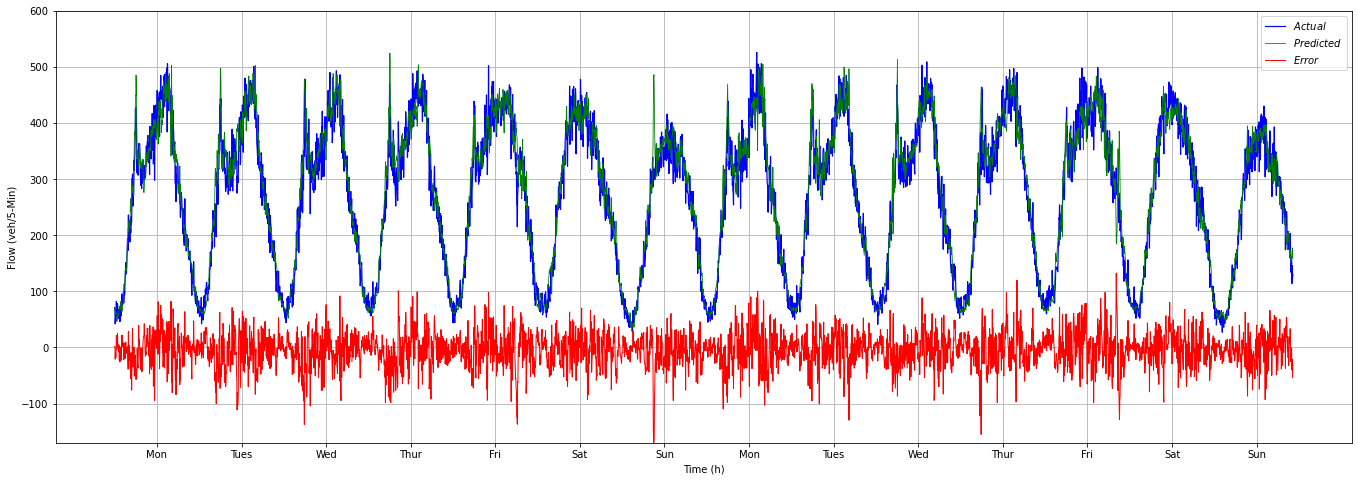

In [66]:
# Create Figure (empty canvas)
fig = plt.figure(figsize=(18,6))

# Add set of axes to figure
axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)

# Plot on that set of axes
axes.plot(yv30, lw=1.2, label=r'$Actual$', color='blue')
axes.plot(test_predictions30, lw=0.8, label=r'$Predicted$', color='green')
axes.plot((yv30-test_predictions30), lw=1, label=r'$Error$', color='red')

#axes.set_xlim(0,24)
axes.set_ylim(-170,600)
axes.set_xlabel('Time (h)')
axes.set_ylabel('Flow (veh/5-Min)')

axes.legend(loc=1)
axes.grid()

axes.set_xticks([144 + i for i in range(0, 4032, 288)])
axes.set_xticklabels(['Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']*2)

plt.show()

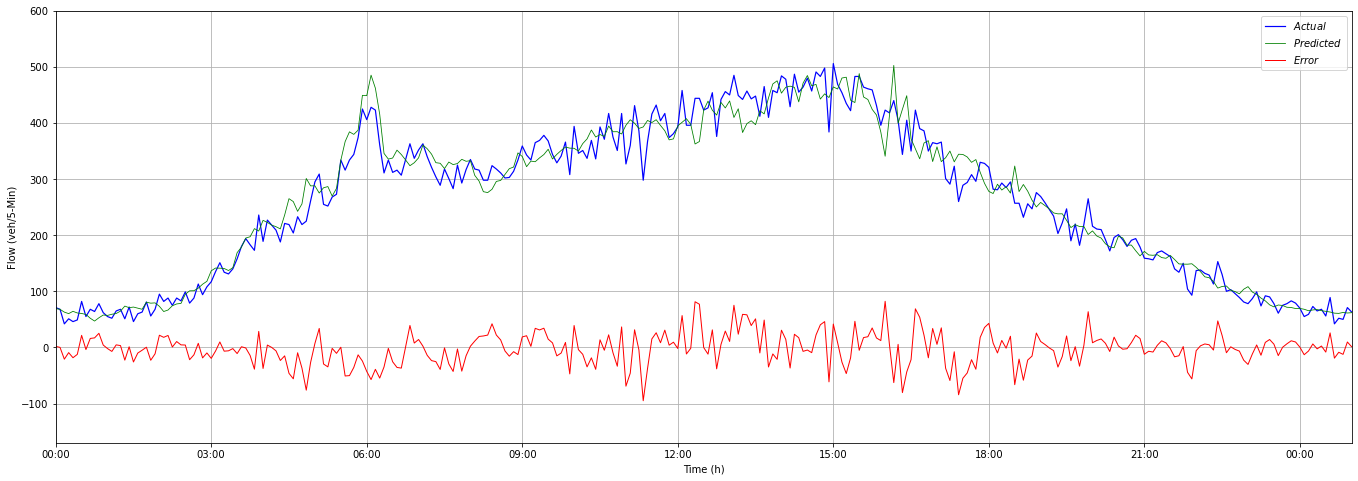

In [67]:
# Create Figure (empty canvas)
fig = plt.figure(figsize=(18,6))

# Add set of axes to figure
axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)

# Plot on that set of axes
axes.plot(yv30, lw=1.2, label=r'$Actual$', color='blue')
axes.plot(test_predictions30, lw=0.8, label=r'$Predicted$', color='green')
axes.plot((yv30-test_predictions30), lw=1, label=r'$Error$', color='red')

axes.set_xlim(0,300)
axes.set_ylim(-170,600)
axes.set_xlabel('Time (h)')
axes.set_ylabel('Flow (veh/5-Min)')

axes.legend(loc=1)
axes.grid()

axes.set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
axes.set_xticklabels(['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00','00:00'])

plt.show()

# 60 mins ahead

In [94]:
def build_model_60(hp):
    # define model
    model_60 = Sequential()
    
    # 2 layer LSTM
    model_60.add(LSTM(units=hp.Int("Units_1", min_value=1, max_value=100, step=1),
                     activation='relu', return_sequences=True, input_shape=input_shape))
    model_60.add(LSTM(units=hp.Int("Units_2", min_value=1, max_value=100, step=1),
                     activation='relu'))
    
    # Final Prediction
    model_60.add(Dense(1))
    
    model_60.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss='mse',metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
    
    return model_60

In [95]:
tuner60 = RandomSearch(
    build_model_60,
    objective="val_loss",
    max_trials=60,
    executions_per_trial=5,
    overwrite=False,
    directory=os.path.normpath('C:/Runs'),
    project_name="6a-LSTM-60",
)

INFO:tensorflow:Reloading Oracle from existing project C:\Runs\6a-LSTM-60\oracle.json
INFO:tensorflow:Reloading Tuner from C:\Runs\6a-LSTM-60\tuner0.json


In [96]:
tuner60.search_space_summary()

Search space summary
Default search space size: 3
Units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
Units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [97]:
tuner60.search(Xt60, yt60, epochs=200,
            validation_split = val_percent,
            callbacks=[early_stop],
            verbose=2)

INFO:tensorflow:Oracle triggered exit


In [98]:
tuner60.results_summary(1)

Results summary
Results in C:\Runs\6a-LSTM-60
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
Units_1: 82
Units_2: 42
learning_rate: 0.01
Score: 0.003140839282423258


### Best Model

In [99]:
best_hp60 = tuner60.get_best_hyperparameters()[0]
model60 = tuner60.hypermodel.build(best_hp60)

In [100]:
scaler_filename = "Best_HP/6a-LSTM-60"
joblib.dump(best_hp60, scaler_filename) 

['Best_HP/6a-LSTM-60']

In [101]:
model60.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 82)            29520     
_________________________________________________________________
lstm_1 (LSTM)                (None, 42)                21000     
_________________________________________________________________
dense (Dense)                (None, 1)                 43        
Total params: 50,563
Trainable params: 50,563
Non-trainable params: 0
_________________________________________________________________


In [102]:
# model60.fit(Xt60, yt60, 
#             epochs = 100,
#             verbose = 0)

In [103]:
# metrics60 = pd.DataFrame(model60.history.history)

In [104]:
# metrics60[['loss']].plot()

In [105]:
MSE60  = []
MAE60  = []
RMSE60 = []
MAPE60 = []

for i in range(100):
    print(f"run: {i+1}")
    model60.fit((Xt60), yt60, 
            epochs = 200, validation_split = val_percent,
            callbacks = [stop],
            verbose = 1
            )
    
    test_predictions60 = model60.predict((Xv60))
    
    yv60 = scaler.inverse_transform(Test.drop('Timestamp', axis = 1))
    yv60 = yv60[26:,4]

    df = Test.drop(Test.head(26).index)
    df.reset_index(inplace = True)
    df = df.drop(columns=['index','Timestamp'])
    df['f5'] = pd.Series(test_predictions60.flatten())

    test_predictions60 = scaler.inverse_transform(df)

    test_predictions60 = test_predictions60[:,4]
    
    MSE60.append(mean_squared_error(yv60,test_predictions60))

    MAE60.append(mean_absolute_error(yv60,test_predictions60))

    RMSE60.append(np.sqrt(mean_squared_error(yv60,test_predictions60)))

    MAPE60.append(mean_absolute_percentage_error(yv60,test_predictions60)*100)

    
    current_mse = mean_squared_error(yv60,test_predictions60)
    if all(i > current_mse for i in MSE60):
        model60.save("my_dir/6a-LSTM-60")

eval60 = [mean(MSE60), mean(MAE60), mean(RMSE60), mean(MAPE60)]
std60 = [stdev(MSE60), stdev(MAE60), stdev(RMSE60), stdev(MAPE60)]
print(eval60)

run: 1
Epoch 1/200
846/846 [==============================] - 19s 22ms/step - loss: 0.0120 - mean_absolute_error: 0.0740 - root_mean_squared_error: 0.1094 - mean_absolute_percentage_error: 13198.0762 - val_loss: 0.0055 - val_mean_absolute_error: 0.0576 - val_root_mean_squared_error: 0.0742 - val_mean_absolute_percentage_error: 19.1566
Epoch 2/200
846/846 [==============================] - 19s 23ms/step - loss: 0.0054 - mean_absolute_error: 0.0555 - root_mean_squared_error: 0.0733 - mean_absolute_percentage_error: 7324.9355 - val_loss: 0.0073 - val_mean_absolute_error: 0.0694 - val_root_mean_squared_error: 0.0855 - val_mean_absolute_percentage_error: 26.2153ot_mean_squared_error: 0.0734 - mean_abs
Epoch 3/200
846/846 [==============================] - 17s 20ms/step - loss: 0.0049 - mean_absolute_error: 0.0524 - root_mean_squared_error: 0.0697 - mean_absolute_percentage_error: 5100.8301 - val_loss: 0.0047 - val_mean_absolute_error: 0.0528 - val_root_mean_squared_error: 0.0685 - val_mean_

846/846 [==============================] - 16s 19ms/step - loss: 0.0034 - mean_absolute_error: 0.0439 - root_mean_squared_error: 0.0581 - mean_absolute_percentage_error: 7427.8154 - val_loss: 0.0036 - val_mean_absolute_error: 0.0468 - val_root_mean_squared_error: 0.0604 - val_mean_absolute_percentage_error: 15.3889
Epoch 2/200
846/846 [==============================] - 16s 18ms/step - loss: 0.0033 - mean_absolute_error: 0.0434 - root_mean_squared_error: 0.0575 - mean_absolute_percentage_error: 5781.7222 - val_loss: 0.0036 - val_mean_absolute_error: 0.0458 - val_root_mean_squared_error: 0.0601 - val_mean_absolute_percentage_error: 13.8511
Epoch 3/200
846/846 [==============================] - 15s 17ms/step - loss: 0.0033 - mean_absolute_error: 0.0435 - root_mean_squared_error: 0.0576 - mean_absolute_percentage_error: 7138.9287 - val_loss: 0.0040 - val_mean_absolute_error: 0.0493 - val_root_mean_squared_error: 0.0631 - val_mean_absolute_percentage_error: 17.9759
Epoch 4/200
846/846 [====

846/846 [==============================] - 15s 18ms/step - loss: 0.0063 - mean_absolute_error: 0.0483 - root_mean_squared_error: 0.0792 - mean_absolute_percentage_error: 6639.6021 - val_loss: 0.0041 - val_mean_absolute_error: 0.0488 - val_root_mean_squared_error: 0.0641 - val_mean_absolute_percentage_error: 16.1237
Epoch 9/200
846/846 [==============================] - 15s 17ms/step - loss: 0.0040 - mean_absolute_error: 0.0473 - root_mean_squared_error: 0.0634 - mean_absolute_percentage_error: 6209.0249 - val_loss: 0.0033 - val_mean_absolute_error: 0.0436 - val_root_mean_squared_error: 0.0571 - val_mean_absolute_percentage_error: 13.52571 - mean_absolute_error: 0.0480 - root_mean_squared_error: 0.0642 - mean_absolute_percentage_ - ETA: 3s - loss: 0.0041 - mean_absolute_error: 0.0478 - root_mean_squared_error: 0.0640  - ETA: 0s - loss: 0.0040 - mean_absolute_error: 0.0475 - root_mean_squared_error: 0.0635 - mean_absolute_percentage_error: 6
Epoch 10/200
846/846 [========================

Epoch 5/200
846/846 [==============================] - 15s 17ms/step - loss: 0.0061 - mean_absolute_error: 0.0589 - root_mean_squared_error: 0.0782 - mean_absolute_percentage_error: 7706.5005 - val_loss: 0.0051 - val_mean_absolute_error: 0.0555 - val_root_mean_squared_error: 0.0715 - val_mean_absolute_percentage_error: 20.4089
Epoch 6/200
846/846 [==============================] - 15s 17ms/step - loss: 0.0054 - mean_absolute_error: 0.0554 - root_mean_squared_error: 0.0732 - mean_absolute_percentage_error: 7257.5503 - val_loss: 0.0060 - val_mean_absolute_error: 0.0600 - val_root_mean_squared_error: 0.0774 - val_mean_absolute_percentage_error: 18.4372
Epoch 7/200
846/846 [==============================] - 15s 17ms/step - loss: 0.0051 - mean_absolute_error: 0.0541 - root_mean_squared_error: 0.0716 - mean_absolute_percentage_error: 5681.0151 - val_loss: 0.0051 - val_mean_absolute_error: 0.0543 - val_root_mean_squared_error: 0.0713 - val_mean_absolute_percentage_error: 18.1409_squared_error

846/846 [==============================] - 15s 18ms/step - loss: 0.0056 - mean_absolute_error: 0.0569 - root_mean_squared_error: 0.0749 - mean_absolute_percentage_error: 8133.9736 - val_loss: 0.0053 - val_mean_absolute_error: 0.0557 - val_root_mean_squared_error: 0.0730 - val_mean_absolute_percentage_error: 17.7633
run: 19
Epoch 1/200
846/846 [==============================] - 16s 19ms/step - loss: 250.8283 - mean_absolute_error: 0.7535 - root_mean_squared_error: 15.8376 - mean_absolute_percentage_error: 7297.9644 - val_loss: 0.0185 - val_mean_absolute_error: 0.1093 - val_root_mean_squared_error: 0.1360 - val_mean_absolute_percentage_error: 40.9059
Epoch 2/200
846/846 [==============================] - 15s 18ms/step - loss: 0.0290 - mean_absolute_error: 0.1338 - root_mean_squared_error: 0.1703 - mean_absolute_percentage_error: 14316.8691 - val_loss: 0.0370 - val_mean_absolute_error: 0.1572 - val_root_mean_squared_error: 0.1922 - val_mean_absolute_percentage_error: 65.6333
Epoch 3/200
8

Epoch 18/200
846/846 [==============================] - 16s 18ms/step - loss: 0.0104 - mean_absolute_error: 0.0793 - root_mean_squared_error: 0.1018 - mean_absolute_percentage_error: 9705.3672 - val_loss: 0.0100 - val_mean_absolute_error: 0.0772 - val_root_mean_squared_error: 0.1000 - val_mean_absolute_percentage_error: 25.5932
Epoch 19/200
846/846 [==============================] - 15s 17ms/step - loss: 0.0103 - mean_absolute_error: 0.0792 - root_mean_squared_error: 0.1017 - mean_absolute_percentage_error: 9725.1240 - val_loss: 0.0100 - val_mean_absolute_error: 0.0772 - val_root_mean_squared_error: 0.0999 - val_mean_absolute_percentage_error: 25.6509
Epoch 20/200
846/846 [==============================] - 15s 18ms/step - loss: 0.0103 - mean_absolute_error: 0.0791 - root_mean_squared_error: 0.1016 - mean_absolute_percentage_error: 10003.9736 - val_loss: 0.0099 - val_mean_absolute_error: 0.0769 - val_root_mean_squared_error: 0.0995 - val_mean_absolute_percentage_error: 25.4819
Epoch 21/

846/846 [==============================] - 15s 18ms/step - loss: 0.0073 - mean_absolute_error: 0.0656 - root_mean_squared_error: 0.0852 - mean_absolute_percentage_error: 8368.5840 - val_loss: 0.0072 - val_mean_absolute_error: 0.0649 - val_root_mean_squared_error: 0.0849 - val_mean_absolute_percentage_error: 22.0482
Epoch 4/200
846/846 [==============================] - 15s 18ms/step - loss: 0.0072 - mean_absolute_error: 0.0654 - root_mean_squared_error: 0.0851 - mean_absolute_percentage_error: 8686.3457 - val_loss: 0.0072 - val_mean_absolute_error: 0.0648 - val_root_mean_squared_error: 0.0847 - val_mean_absolute_percentage_error: 22.1187
Epoch 5/200
846/846 [==============================] - 15s 18ms/step - loss: 0.0072 - mean_absolute_error: 0.0652 - root_mean_squared_error: 0.0849 - mean_absolute_percentage_error: 8782.2354 - val_loss: 0.0072 - val_mean_absolute_error: 0.0649 - val_root_mean_squared_error: 0.0848 - val_mean_absolute_percentage_error: 21.7668
Epoch 6/200
846/846 [====

846/846 [==============================] - 15s 18ms/step - loss: 0.0063 - mean_absolute_error: 0.0608 - root_mean_squared_error: 0.0795 - mean_absolute_percentage_error: 7842.6401 - val_loss: 0.0061 - val_mean_absolute_error: 0.0591 - val_root_mean_squared_error: 0.0782 - val_mean_absolute_percentage_error: 19.7270s: 0.0063 - mean_absolute_error: 0 - ETA: 2s - loss: 0.0064 - mean_absolute_error: 0.0610 - root_mean_squared_error: 0.0797 - mea
Epoch 8/200
846/846 [==============================] - 15s 18ms/step - loss: 0.0064 - mean_absolute_error: 0.0610 - root_mean_squared_error: 0.0798 - mean_absolute_percentage_error: 7742.5649 - val_loss: 0.0063 - val_mean_absolute_error: 0.0607 - val_root_mean_squared_error: 0.0796 - val_mean_absolute_percentage_error: 21.5180
run: 29
Epoch 1/200
846/846 [==============================] - 15s 18ms/step - loss: 0.0064 - mean_absolute_error: 0.0612 - root_mean_squared_error: 0.0801 - mean_absolute_percentage_error: 7473.3916 - val_loss: 0.0071 - val_

Epoch 14/200
846/846 [==============================] - 15s 18ms/step - loss: 0.0058 - mean_absolute_error: 0.0579 - root_mean_squared_error: 0.0761 - mean_absolute_percentage_error: 7962.5747 - val_loss: 0.0061 - val_mean_absolute_error: 0.0570 - val_root_mean_squared_error: 0.0782 - val_mean_absolute_percentage_error: 19.0515
Epoch 15/200
846/846 [==============================] - 16s 19ms/step - loss: 0.0058 - mean_absolute_error: 0.0579 - root_mean_squared_error: 0.0761 - mean_absolute_percentage_error: 7523.0952 - val_loss: 0.0116 - val_mean_absolute_error: 0.0583 - val_root_mean_squared_error: 0.1078 - val_mean_absolute_percentage_error: 20.0731
Epoch 16/200
846/846 [==============================] - 15s 18ms/step - loss: 0.0058 - mean_absolute_error: 0.0581 - root_mean_squared_error: 0.0762 - mean_absolute_percentage_error: 7307.7920 - val_loss: 0.0056 - val_mean_absolute_error: 0.0568 - val_root_mean_squared_error: 0.0751 - val_mean_absolute_percentage_error: 19.4778
Epoch 17/2

Epoch 2/200
846/846 [==============================] - 15s 17ms/step - loss: 0.0056 - mean_absolute_error: 0.0570 - root_mean_squared_error: 0.0750 - mean_absolute_percentage_error: 7385.3477 - val_loss: 0.0055 - val_mean_absolute_error: 0.0561 - val_root_mean_squared_error: 0.0741 - val_mean_absolute_percentage_error: 18.8227
Epoch 3/200
846/846 [==============================] - 16s 18ms/step - loss: 0.0056 - mean_absolute_error: 0.0570 - root_mean_squared_error: 0.0750 - mean_absolute_percentage_error: 7388.3691 - val_loss: 0.0055 - val_mean_absolute_error: 0.0561 - val_root_mean_squared_error: 0.0741 - val_mean_absolute_percentage_error: 18.8260
Epoch 4/200
846/846 [==============================] - 15s 18ms/step - loss: 0.0056 - mean_absolute_error: 0.0570 - root_mean_squared_error: 0.0750 - mean_absolute_percentage_error: 7390.2881 - val_loss: 0.0055 - val_mean_absolute_error: 0.0561 - val_root_mean_squared_error: 0.0741 - val_mean_absolute_percentage_error: 18.8315
Epoch 5/200
8

846/846 [==============================] - 15s 18ms/step - loss: 0.0108 - mean_absolute_error: 0.0819 - root_mean_squared_error: 0.1041 - mean_absolute_percentage_error: 9887.2734 - val_loss: 0.0105 - val_mean_absolute_error: 0.0801 - val_root_mean_squared_error: 0.1027 - val_mean_absolute_percentage_error: 26.9542
Epoch 3/200
846/846 [==============================] - 15s 18ms/step - loss: 0.0108 - mean_absolute_error: 0.0817 - root_mean_squared_error: 0.1038 - mean_absolute_percentage_error: 9570.6572 - val_loss: 0.0102 - val_mean_absolute_error: 0.0788 - val_root_mean_squared_error: 0.1009 - val_mean_absolute_percentage_error: 27.4274
Epoch 4/200
846/846 [==============================] - 16s 19ms/step - loss: 0.0107 - mean_absolute_error: 0.0816 - root_mean_squared_error: 0.1036 - mean_absolute_percentage_error: 9767.2637 - val_loss: 0.0099 - val_mean_absolute_error: 0.0780 - val_root_mean_squared_error: 0.0997 - val_mean_absolute_percentage_error: 28.0499
Epoch 5/200
846/846 [====

Epoch 8/200
846/846 [==============================] - 15s 18ms/step - loss: 0.0066 - mean_absolute_error: 0.0614 - root_mean_squared_error: 0.0812 - mean_absolute_percentage_error: 4431.8984 - val_loss: 0.0055 - val_mean_absolute_error: 0.0585 - val_root_mean_squared_error: 0.0742 - val_mean_absolute_percentage_error: 19.7844
Epoch 9/200
846/846 [==============================] - 15s 18ms/step - loss: 0.0058 - mean_absolute_error: 0.0571 - root_mean_squared_error: 0.0762 - mean_absolute_percentage_error: 7884.6147 - val_loss: 0.0099 - val_mean_absolute_error: 0.0764 - val_root_mean_squared_error: 0.0993 - val_mean_absolute_percentage_error: 19.7701
Epoch 10/200
846/846 [==============================] - 16s 19ms/step - loss: 0.0053 - mean_absolute_error: 0.0549 - root_mean_squared_error: 0.0728 - mean_absolute_percentage_error: 5700.0771 - val_loss: 0.0044 - val_mean_absolute_error: 0.0500 - val_root_mean_squared_error: 0.0663 - val_mean_absolute_percentage_error: 15.2225: 0.0053 - me

Epoch 5/200
846/846 [==============================] - 15s 17ms/step - loss: 0.0042 - mean_absolute_error: 0.0490 - root_mean_squared_error: 0.0650 - mean_absolute_percentage_error: 7243.4375 - val_loss: 0.0041 - val_mean_absolute_error: 0.0486 - val_root_mean_squared_error: 0.0640 - val_mean_absolute_percentage_error: 14.8258
Epoch 6/200
846/846 [==============================] - 15s 18ms/step - loss: 0.0042 - mean_absolute_error: 0.0490 - root_mean_squared_error: 0.0651 - mean_absolute_percentage_error: 7010.1943 - val_loss: 0.0041 - val_mean_absolute_error: 0.0485 - val_root_mean_squared_error: 0.0638 - val_mean_absolute_percentage_error: 14.8458
Epoch 7/200
846/846 [==============================] - 15s 18ms/step - loss: 0.0042 - mean_absolute_error: 0.0490 - root_mean_squared_error: 0.0651 - mean_absolute_percentage_error: 7070.5488 - val_loss: 0.0042 - val_mean_absolute_error: 0.0490 - val_root_mean_squared_error: 0.0646 - val_mean_absolute_percentage_error: 15.5570
Epoch 8/200
8

Epoch 8/200
846/846 [==============================] - 15s 18ms/step - loss: 0.0040 - mean_absolute_error: 0.0473 - root_mean_squared_error: 0.0629 - mean_absolute_percentage_error: 6330.9390 - val_loss: 0.0039 - val_mean_absolute_error: 0.0484 - val_root_mean_squared_error: 0.0627 - val_mean_absolute_percentage_error: 15.0060ot_mean_squared_error: 0.0629 - mean_absolute_percentage_error: 6378.1
run: 45
Epoch 1/200
846/846 [==============================] - 15s 18ms/step - loss: 0.0041 - mean_absolute_error: 0.0484 - root_mean_squared_error: 0.0643 - mean_absolute_percentage_error: 6616.5547 - val_loss: 0.0045 - val_mean_absolute_error: 0.0511 - val_root_mean_squared_error: 0.0670 - val_mean_absolute_percentage_error: 14.85831 - root_mean_squared_error: 0.0640 - mean_absolu - ETA: 7s - loss: 0.0041 - mean_absolute_error: 0.0482 - root_mean_squared_error: 0.0643 - mean
Epoch 2/200
846/846 [==============================] - 15s 18ms/step - loss: 0.0042 - mean_absolute_error: 0.0486 - roo

846/846 [==============================] - 15s 17ms/step - loss: 0.0033 - mean_absolute_error: 0.0433 - root_mean_squared_error: 0.0576 - mean_absolute_percentage_error: 6078.0146 - val_loss: 0.0035 - val_mean_absolute_error: 0.0450 - val_root_mean_squared_error: 0.0590 - val_mean_absolute_percentage_error: 13.6635
Epoch 7/200
846/846 [==============================] - 15s 18ms/step - loss: 0.0033 - mean_absolute_error: 0.0431 - root_mean_squared_error: 0.0575 - mean_absolute_percentage_error: 6239.3140 - val_loss: 0.0036 - val_mean_absolute_error: 0.0458 - val_root_mean_squared_error: 0.0597 - val_mean_absolute_percentage_error: 13.8345
run: 50
Epoch 1/200
846/846 [==============================] - 15s 18ms/step - loss: 0.0033 - mean_absolute_error: 0.0431 - root_mean_squared_error: 0.0574 - mean_absolute_percentage_error: 6341.3555 - val_loss: 0.0035 - val_mean_absolute_error: 0.0452 - val_root_mean_squared_error: 0.0593 - val_mean_absolute_percentage_error: 13.6726
Epoch 2/200
846/8

846/846 [==============================] - 16s 19ms/step - loss: 0.0031 - mean_absolute_error: 0.0419 - root_mean_squared_error: 0.0560 - mean_absolute_percentage_error: 5973.8398 - val_loss: 0.0033 - val_mean_absolute_error: 0.0439 - val_root_mean_squared_error: 0.0578 - val_mean_absolute_percentage_error: 13.6074
Epoch 4/200
846/846 [==============================] - 15s 18ms/step - loss: 0.0031 - mean_absolute_error: 0.0418 - root_mean_squared_error: 0.0560 - mean_absolute_percentage_error: 5909.8550 - val_loss: 0.0034 - val_mean_absolute_error: 0.0439 - val_root_mean_squared_error: 0.0579 - val_mean_absolute_percentage_error: 13.6631- mean_absolute_error: 0.0421 - root_
Epoch 5/200
846/846 [==============================] - 15s 18ms/step - loss: 0.0031 - mean_absolute_error: 0.0418 - root_mean_squared_error: 0.0560 - mean_absolute_percentage_error: 5831.1743 - val_loss: 0.0034 - val_mean_absolute_error: 0.0439 - val_root_mean_squared_error: 0.0579 - val_mean_absolute_percentage_err

846/846 [==============================] - 15s 18ms/step - loss: 0.0134 - mean_absolute_error: 0.0878 - root_mean_squared_error: 0.1158 - mean_absolute_percentage_error: 5271.7500 - val_loss: 0.0109 - val_mean_absolute_error: 0.0798 - val_root_mean_squared_error: 0.1044 - val_mean_absolute_percentage_error: 31.3074 loss: 0.0138 - mean_absolute_error: 0.0889 - root_mean_squared_error: 0.1176 - mean_absolute_ - ETA: 1s - loss: 0.0137 - mean_absolute_error: 0.0885 - root_mean_squared_error: 0.1170 - mean_absolute_pe
Epoch 16/200
846/846 [==============================] - 15s 17ms/step - loss: 0.0175 - mean_absolute_error: 0.0875 - root_mean_squared_error: 0.1322 - mean_absolute_percentage_error: 5639.1045 - val_loss: 0.0126 - val_mean_absolute_error: 0.0860 - val_root_mean_squared_error: 0.1123 - val_mean_absolute_percentage_error: 32.6475
Epoch 17/200
846/846 [==============================] - 16s 18ms/step - loss: 0.0190 - mean_absolute_error: 0.0978 - root_mean_squared_error: 0.1379 - 

846/846 [==============================] - 15s 18ms/step - loss: 11797.3203 - mean_absolute_error: 0.9860 - root_mean_squared_error: 108.6155 - mean_absolute_percentage_error: 10022.5898 - val_loss: 0.0147 - val_mean_absolute_error: 0.0968 - val_root_mean_squared_error: 0.1211 - val_mean_absolute_percentage_error: 37.2694
Epoch 3/200
846/846 [==============================] - 15s 18ms/step - loss: 0.0118 - mean_absolute_error: 0.0829 - root_mean_squared_error: 0.1086 - mean_absolute_percentage_error: 7941.4331 - val_loss: 0.0084 - val_mean_absolute_error: 0.0720 - val_root_mean_squared_error: 0.0915 - val_mean_absolute_percentage_error: 28.1724
Epoch 4/200
846/846 [==============================] - 15s 17ms/step - loss: 0.0215 - mean_absolute_error: 0.0895 - root_mean_squared_error: 0.1468 - mean_absolute_percentage_error: 9787.5811 - val_loss: 1.6475 - val_mean_absolute_error: 0.1038 - val_root_mean_squared_error: 1.2835 - val_mean_absolute_percentage_error: 31.1018
Epoch 5/200
846/84

Epoch 3/200
846/846 [==============================] - 16s 18ms/step - loss: 0.0068 - mean_absolute_error: 0.0630 - root_mean_squared_error: 0.0824 - mean_absolute_percentage_error: 9869.3711 - val_loss: 0.0057 - val_mean_absolute_error: 0.0585 - val_root_mean_squared_error: 0.0756 - val_mean_absolute_percentage_error: 20.3707
Epoch 4/200
846/846 [==============================] - 15s 18ms/step - loss: 0.0064 - mean_absolute_error: 0.0613 - root_mean_squared_error: 0.0801 - mean_absolute_percentage_error: 9068.7490 - val_loss: 0.0055 - val_mean_absolute_error: 0.0575 - val_root_mean_squared_error: 0.0740 - val_mean_absolute_percentage_error: 19.7914
Epoch 5/200
846/846 [==============================] - 16s 19ms/step - loss: 0.0060 - mean_absolute_error: 0.0593 - root_mean_squared_error: 0.0777 - mean_absolute_percentage_error: 8237.0215 - val_loss: 0.0054 - val_mean_absolute_error: 0.0569 - val_root_mean_squared_error: 0.0737 - val_mean_absolute_percentage_error: 18.5941
Epoch 6/200
8

846/846 [==============================] - 16s 19ms/step - loss: 0.0035 - mean_absolute_error: 0.0447 - root_mean_squared_error: 0.0596 - mean_absolute_percentage_error: 6891.1523 - val_loss: 0.0034 - val_mean_absolute_error: 0.0441 - val_root_mean_squared_error: 0.0579 - val_mean_absolute_percentage_error: 13.7003
Epoch 6/200
846/846 [==============================] - 15s 17ms/step - loss: 0.0036 - mean_absolute_error: 0.0450 - root_mean_squared_error: 0.0600 - mean_absolute_percentage_error: 6445.1865 - val_loss: 0.0034 - val_mean_absolute_error: 0.0450 - val_root_mean_squared_error: 0.0582 - val_mean_absolute_percentage_error: 14.4382
Epoch 7/200
846/846 [==============================] - 16s 18ms/step - loss: 0.0036 - mean_absolute_error: 0.0449 - root_mean_squared_error: 0.0598 - mean_absolute_percentage_error: 6695.6245 - val_loss: 0.0040 - val_mean_absolute_error: 0.0476 - val_root_mean_squared_error: 0.0634 - val_mean_absolute_percentage_error: 14.5262
Epoch 8/200
846/846 [====

Epoch 4/200
846/846 [==============================] - 17s 20ms/step - loss: 0.0033 - mean_absolute_error: 0.0430 - root_mean_squared_error: 0.0576 - mean_absolute_percentage_error: 6520.8096 - val_loss: 0.0033 - val_mean_absolute_error: 0.0437 - val_root_mean_squared_error: 0.0573 - val_mean_absolute_percentage_error: 13.7574
Epoch 5/200
846/846 [==============================] - 17s 20ms/step - loss: 0.0033 - mean_absolute_error: 0.0429 - root_mean_squared_error: 0.0574 - mean_absolute_percentage_error: 6503.8564 - val_loss: 0.0033 - val_mean_absolute_error: 0.0436 - val_root_mean_squared_error: 0.0571 - val_mean_absolute_percentage_error: 13.6535
Epoch 6/200
846/846 [==============================] - 17s 20ms/step - loss: 0.0033 - mean_absolute_error: 0.0428 - root_mean_squared_error: 0.0572 - mean_absolute_percentage_error: 6370.4956 - val_loss: 0.0033 - val_mean_absolute_error: 0.0437 - val_root_mean_squared_error: 0.0573 - val_mean_absolute_percentage_error: 13.8321
Epoch 7/200
8

Epoch 8/200
846/846 [==============================] - 17s 20ms/step - loss: 0.0032 - mean_absolute_error: 0.0430 - root_mean_squared_error: 0.0570 - mean_absolute_percentage_error: 4183.8091 - val_loss: 0.0039 - val_mean_absolute_error: 0.0470 - val_root_mean_squared_error: 0.0621 - val_mean_absolute_percentage_error: 14.8910
Epoch 9/200
846/846 [==============================] - 17s 20ms/step - loss: 4053399.7500 - mean_absolute_error: 145.2255 - root_mean_squared_error: 2013.3057 - mean_absolute_percentage_error: 37049.8516 - val_loss: 470.7562 - val_mean_absolute_error: 15.8530 - val_root_mean_squared_error: 21.6969 - val_mean_absolute_percentage_error: 3991.2891
Epoch 10/200
846/846 [==============================] - 17s 20ms/step - loss: 241.0415 - mean_absolute_error: 8.6694 - root_mean_squared_error: 15.5255 - mean_absolute_percentage_error: 44590.3984 - val_loss: 23.4796 - val_mean_absolute_error: 1.7207 - val_root_mean_squared_error: 4.8456 - val_mean_absolute_percentage_erro

run: 76
Epoch 1/200
846/846 [==============================] - 16s 19ms/step - loss: 0.0030 - mean_absolute_error: 0.0414 - root_mean_squared_error: 0.0550 - mean_absolute_percentage_error: 5426.9048 - val_loss: 0.0033 - val_mean_absolute_error: 0.0436 - val_root_mean_squared_error: 0.0573 - val_mean_absolute_percentage_error: 13.6084
Epoch 2/200
846/846 [==============================] - 16s 19ms/step - loss: 0.0030 - mean_absolute_error: 0.0413 - root_mean_squared_error: 0.0549 - mean_absolute_percentage_error: 5390.7661 - val_loss: 0.0034 - val_mean_absolute_error: 0.0441 - val_root_mean_squared_error: 0.0582 - val_mean_absolute_percentage_error: 13.4419
Epoch 3/200
846/846 [==============================] - 17s 20ms/step - loss: 0.0030 - mean_absolute_error: 0.0415 - root_mean_squared_error: 0.0552 - mean_absolute_percentage_error: 5526.7666 - val_loss: 0.0032 - val_mean_absolute_error: 0.0432 - val_root_mean_squared_error: 0.0567 - val_mean_absolute_percentage_error: 13.2838
Epoch

run: 79
Epoch 1/200
846/846 [==============================] - 17s 20ms/step - loss: 0.0029 - mean_absolute_error: 0.0410 - root_mean_squared_error: 0.0542 - mean_absolute_percentage_error: 4873.9692 - val_loss: 0.0033 - val_mean_absolute_error: 0.0437 - val_root_mean_squared_error: 0.0571 - val_mean_absolute_percentage_error: 13.5080
Epoch 2/200
846/846 [==============================] - 16s 19ms/step - loss: 0.0029 - mean_absolute_error: 0.0409 - root_mean_squared_error: 0.0541 - mean_absolute_percentage_error: 4879.9072 - val_loss: 0.0032 - val_mean_absolute_error: 0.0435 - val_root_mean_squared_error: 0.0569 - val_mean_absolute_percentage_error: 13.4626
Epoch 3/200
846/846 [==============================] - 16s 19ms/step - loss: 0.0029 - mean_absolute_error: 0.0408 - root_mean_squared_error: 0.0541 - mean_absolute_percentage_error: 4906.4463 - val_loss: 0.0032 - val_mean_absolute_error: 0.0434 - val_root_mean_squared_error: 0.0568 - val_mean_absolute_percentage_error: 13.4224
Epoch

Epoch 6/200
846/846 [==============================] - 16s 19ms/step - loss: 0.0029 - mean_absolute_error: 0.0407 - root_mean_squared_error: 0.0540 - mean_absolute_percentage_error: 5935.0034 - val_loss: 0.0032 - val_mean_absolute_error: 0.0429 - val_root_mean_squared_error: 0.0565 - val_mean_absolute_percentage_error: 13.1933
Epoch 7/200
846/846 [==============================] - 17s 20ms/step - loss: 0.0029 - mean_absolute_error: 0.0407 - root_mean_squared_error: 0.0540 - mean_absolute_percentage_error: 5125.5454 - val_loss: 0.0034 - val_mean_absolute_error: 0.0447 - val_root_mean_squared_error: 0.0584 - val_mean_absolute_percentage_error: 14.6194
Epoch 8/200
846/846 [==============================] - 16s 19ms/step - loss: 0.0029 - mean_absolute_error: 0.0407 - root_mean_squared_error: 0.0539 - mean_absolute_percentage_error: 5949.8105 - val_loss: 0.0033 - val_mean_absolute_error: 0.0438 - val_root_mean_squared_error: 0.0575 - val_mean_absolute_percentage_error: 14.1474
Epoch 9/200
8

Epoch 5/200
846/846 [==============================] - 17s 20ms/step - loss: 0.0029 - mean_absolute_error: 0.0403 - root_mean_squared_error: 0.0536 - mean_absolute_percentage_error: 5315.6875 - val_loss: 0.0032 - val_mean_absolute_error: 0.0425 - val_root_mean_squared_error: 0.0564 - val_mean_absolute_percentage_error: 13.2332
Epoch 6/200
846/846 [==============================] - 16s 19ms/step - loss: 0.0029 - mean_absolute_error: 0.0404 - root_mean_squared_error: 0.0538 - mean_absolute_percentage_error: 5073.1646 - val_loss: 0.0032 - val_mean_absolute_error: 0.0429 - val_root_mean_squared_error: 0.0567 - val_mean_absolute_percentage_error: 13.1931
Epoch 7/200
846/846 [==============================] - 17s 20ms/step - loss: 0.0029 - mean_absolute_error: 0.0403 - root_mean_squared_error: 0.0537 - mean_absolute_percentage_error: 4912.9966 - val_loss: 0.0033 - val_mean_absolute_error: 0.0438 - val_root_mean_squared_error: 0.0575 - val_mean_absolute_percentage_error: 13.6249
Epoch 8/200
8

Epoch 4/200
846/846 [==============================] - 17s 20ms/step - loss: 0.0028 - mean_absolute_error: 0.0402 - root_mean_squared_error: 0.0533 - mean_absolute_percentage_error: 5899.9229 - val_loss: 0.0031 - val_mean_absolute_error: 0.0424 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_percentage_error: 13.0565
Epoch 5/200
846/846 [==============================] - 16s 19ms/step - loss: 0.0030 - mean_absolute_error: 0.0401 - root_mean_squared_error: 0.0545 - mean_absolute_percentage_error: 5821.3145 - val_loss: 0.0031 - val_mean_absolute_error: 0.0423 - val_root_mean_squared_error: 0.0558 - val_mean_absolute_percentage_error: 13.0384
Epoch 6/200
846/846 [==============================] - 16s 19ms/step - loss: 0.0029 - mean_absolute_error: 0.0400 - root_mean_squared_error: 0.0541 - mean_absolute_percentage_error: 5831.8999 - val_loss: 0.0032 - val_mean_absolute_error: 0.0425 - val_root_mean_squared_error: 0.0562 - val_mean_absolute_percentage_error: 13.0828
run: 87
Epoch

Epoch 23/200
846/846 [==============================] - 17s 20ms/step - loss: 0.0027 - mean_absolute_error: 0.0393 - root_mean_squared_error: 0.0522 - mean_absolute_percentage_error: 5364.0874 - val_loss: 0.0033 - val_mean_absolute_error: 0.0428 - val_root_mean_squared_error: 0.0571 - val_mean_absolute_percentage_error: 13.2989
Epoch 24/200
846/846 [==============================] - 16s 19ms/step - loss: 0.0027 - mean_absolute_error: 0.0394 - root_mean_squared_error: 0.0524 - mean_absolute_percentage_error: 5188.3242 - val_loss: 0.0033 - val_mean_absolute_error: 0.0432 - val_root_mean_squared_error: 0.0573 - val_mean_absolute_percentage_error: 13.6275
Epoch 25/200
846/846 [==============================] - 16s 19ms/step - loss: 0.0027 - mean_absolute_error: 0.0394 - root_mean_squared_error: 0.0524 - mean_absolute_percentage_error: 4790.1763 - val_loss: 0.0032 - val_mean_absolute_error: 0.0426 - val_root_mean_squared_error: 0.0566 - val_mean_absolute_percentage_error: 13.0614
Epoch 26/2

Epoch 4/200
846/846 [==============================] - 16s 19ms/step - loss: 0.0028 - mean_absolute_error: 0.0402 - root_mean_squared_error: 0.0534 - mean_absolute_percentage_error: 4786.0625 - val_loss: 0.0033 - val_mean_absolute_error: 0.0440 - val_root_mean_squared_error: 0.0578 - val_mean_absolute_percentage_error: 14.1034
Epoch 5/200
846/846 [==============================] - 16s 19ms/step - loss: 0.0029 - mean_absolute_error: 0.0405 - root_mean_squared_error: 0.0537 - mean_absolute_percentage_error: 5010.1206 - val_loss: 0.0038 - val_mean_absolute_error: 0.0469 - val_root_mean_squared_error: 0.0614 - val_mean_absolute_percentage_error: 13.8113
Epoch 6/200
846/846 [==============================] - 17s 20ms/step - loss: 0.0030 - mean_absolute_error: 0.0409 - root_mean_squared_error: 0.0544 - mean_absolute_percentage_error: 5149.8716 - val_loss: 0.0035 - val_mean_absolute_error: 0.0447 - val_root_mean_squared_error: 0.0589 - val_mean_absolute_percentage_error: 14.1696
run: 93
Epoch

Epoch 2/200
846/846 [==============================] - 17s 20ms/step - loss: 0.0027 - mean_absolute_error: 0.0392 - root_mean_squared_error: 0.0520 - mean_absolute_percentage_error: 5184.3921 - val_loss: 0.0031 - val_mean_absolute_error: 0.0423 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_percentage_error: 13.1568
Epoch 3/200
846/846 [==============================] - 16s 19ms/step - loss: 0.0027 - mean_absolute_error: 0.0392 - root_mean_squared_error: 0.0520 - mean_absolute_percentage_error: 5144.4824 - val_loss: 0.0031 - val_mean_absolute_error: 0.0424 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_percentage_error: 13.1985
Epoch 4/200
846/846 [==============================] - 16s 19ms/step - loss: 0.0027 - mean_absolute_error: 0.0391 - root_mean_squared_error: 0.0520 - mean_absolute_percentage_error: 5225.4785 - val_loss: 0.0031 - val_mean_absolute_error: 0.0424 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_percentage_error: 13.1281
Epoch 5/200
8

Epoch 5/200
846/846 [==============================] - 16s 19ms/step - loss: 0.0027 - mean_absolute_error: 0.0392 - root_mean_squared_error: 0.0521 - mean_absolute_percentage_error: 5000.6147 - val_loss: 0.0032 - val_mean_absolute_error: 0.0430 - val_root_mean_squared_error: 0.0569 - val_mean_absolute_percentage_error: 13.6306
Epoch 6/200
846/846 [==============================] - 16s 19ms/step - loss: 0.0027 - mean_absolute_error: 0.0394 - root_mean_squared_error: 0.0523 - mean_absolute_percentage_error: 5115.1465 - val_loss: 0.0037 - val_mean_absolute_error: 0.0452 - val_root_mean_squared_error: 0.0610 - val_mean_absolute_percentage_error: 14.0286
Epoch 7/200
846/846 [==============================] - 17s 20ms/step - loss: 0.0027 - mean_absolute_error: 0.0394 - root_mean_squared_error: 0.0523 - mean_absolute_percentage_error: 4798.6851 - val_loss: 0.0031 - val_mean_absolute_error: 0.0423 - val_root_mean_squared_error: 0.0558 - val_mean_absolute_percentage_error: 13.1733
Epoch 8/200
8

In [106]:
model60 = keras.models.load_model("my_dir/6a-LSTM-60")

In [121]:
runs = {'MSE': MSE60, 'MAE': MAE60, 'RMSE': RMSE60, 'MAPE': MAPE60}
table60 = pd.DataFrame(data=runs)
table60.to_csv("Results/Runs/6a-LSTM-60")

In [122]:
pd.read_csv("Results/Runs/6a-LSTM-60", index_col=0)

,MSE,MAE,RMSE,MAPE
0,1027.503162,24.589197,32.054690,11.028662
1,997.350311,24.446720,31.580854,11.551578
2,1078.091265,24.954748,32.834300,11.154367
3,1020.415402,25.023291,31.943942,12.334246
4,975.969343,23.883695,31.240508,10.703044
...,...,...,...,...
95,965.864729,23.647083,31.078364,10.606809
96,972.556024,23.636705,31.185831,10.526732
97,976.588240,23.741417,31.250412,10.575296
98,934.287641,23.337310,30.566119,10.440593


### Evaluation on inverse_transform

In [107]:
test_predictions60 = model60.predict((Xv60))

yv60 = scaler.inverse_transform(Test.drop('Timestamp', axis = 1))
yv60 = yv60[26:,4]

df = Test.drop(Test.head(26).index)
df.reset_index(inplace = True)
df = df.drop(columns=['index','Timestamp'])
df['f5'] = pd.Series(test_predictions60.flatten())

test_predictions60 = scaler.inverse_transform(df)

test_predictions60 = test_predictions60[:,4]

# MSE60 = mean_squared_error(yv60,test_predictions60)

# MAE60 = mean_absolute_error(yv60,test_predictions60)

# RMSE60 = np.sqrt(MSE60)

# MAPE60 = mean_absolute_percentage_error(yv60,test_predictions60)*100

# eval60 = [MSE60, MAE60, RMSE60, MAPE60]
# print(eval60)

In [108]:
RA10 = ra.RA_10(np.asarray(yv60), np.asarray(test_predictions60))
RA15 = ra.RA_15(np.asarray(yv60), np.asarray(test_predictions60))
RA20 = ra.RA_20(np.asarray(yv60), np.asarray(test_predictions60))

res60 = [RA10, RA15, RA20]
print(res60)

[60.484273589615576, 78.30753869196205, 86.345481777334]


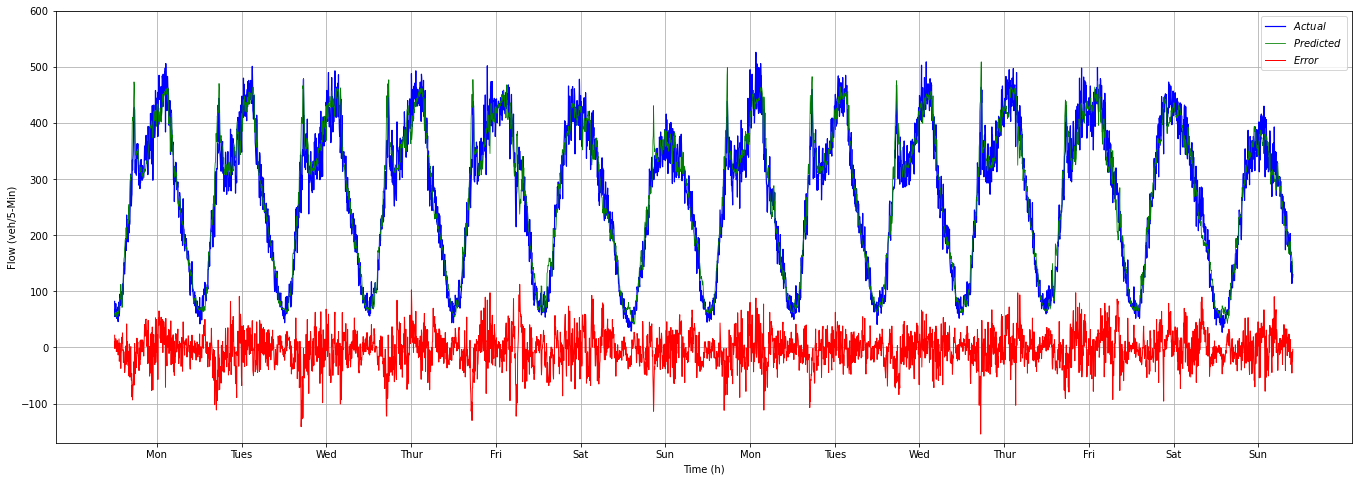

In [109]:
# Create Figure (empty canvas)
fig = plt.figure(figsize=(18,6))

# Add set of axes to figure
axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)

# Plot on that set of axes
axes.plot(yv60, lw=1.2, label=r'$Actual$', color='blue')
axes.plot(test_predictions60, lw=0.8, label=r'$Predicted$', color='green')
axes.plot((yv60-test_predictions60), lw=1, label=r'$Error$', color='red')

#axes.set_xlim(0,24)
axes.set_ylim(-170,600)
axes.set_xlabel('Time (h)')
axes.set_ylabel('Flow (veh/5-Min)')

axes.legend(loc=1)
axes.grid()

axes.set_xticks([144 + i for i in range(0, 4032, 288)])
axes.set_xticklabels(['Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']*2)

plt.show()

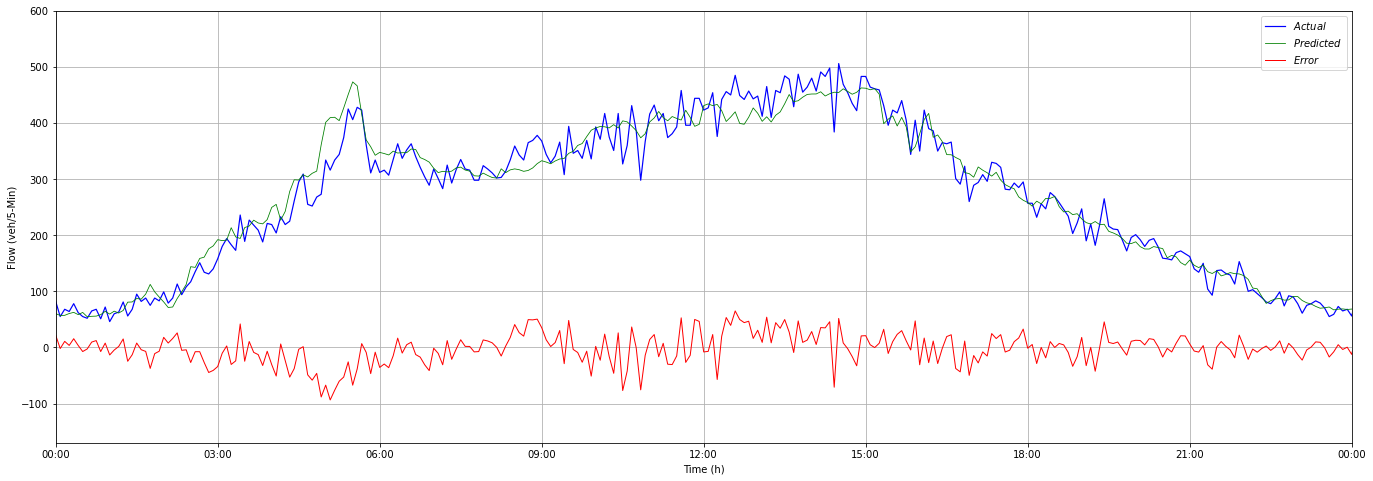

In [110]:
# Create Figure (empty canvas)
fig = plt.figure(figsize=(18,6))

# Add set of axes to figure
axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)

# Plot on that set of axes
axes.plot(yv60, lw=1.2, label=r'$Actual$', color='blue')
axes.plot(test_predictions60, lw=0.8, label=r'$Predicted$', color='green')
axes.plot((yv60-test_predictions60), lw=1, label=r'$Error$', color='red')

axes.set_xlim(0,24)
axes.set_ylim(-170,600)
axes.set_xlabel('Time (h)')
axes.set_ylabel('Flow (veh/5-Min)')

axes.legend(loc=1)
axes.grid()

axes.set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
axes.set_xticklabels(['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00','00:00'])

plt.show()

# RESULTS

## General results

In [85]:
l = ['MSE','MAE','RMSE','MAPE','Horizon']

In [86]:
eval5.append(5)
eval15.append(15)
eval30.append(30)
eval60.append(60)

In [87]:
df = pd.DataFrame(np.array([eval5,eval15,eval30,eval60]),columns=l)
df.set_index('Horizon')

,MSE,MAE,RMSE,MAPE
Horizon,,,,
5.0,552.359619,17.804987,23.488989,7.764074
15.0,1101.448541,25.629023,33.195764,10.551853
30.0,1345.373171,27.470835,36.681828,11.948749
60.0,1506.272187,28.518610,37.371581,13.211543


## Relative accuracy

In [88]:
m = ['10%','15%','20%','Horizon']

In [89]:
res5.append(5)
res15.append(15)
res30.append(30)
res60.append(60)

In [90]:
df1 = pd.DataFrame(np.array([res5,res15,res30,res60]),columns=m)
df1.set_index('Horizon')

,10%,15%,20%
Horizon,,,
5.0,71.296988,87.204381,94.224546
15.0,61.220423,78.132005,88.443337
30.0,60.294118,77.068794,86.640080
60.0,60.484274,78.307539,86.345482


## Save

In [91]:
x = np.array([eval5, eval15, eval30, eval60])
y = np.array([std5, std15, std30, std60])

In [92]:
np.savez("Results/6a", x=x, y=y)